# NN-VMC with self-attention wave function ansatz

In [13]:
import tqdm
import equinox as eqx
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import optax
import netket as nk
from jaxtyping import Array, PyTree, Float, Complex, PRNGKeyArray

import matplotlib.pyplot as plt

from models.slaternet import SlaterNet
from models.psi_solid import PsiSolid

from systems.continuous import moire
from utils.sampler import metropolis_hastings


key = jax.random.key(42)

\begin{equation}
    H=\sum_i\left(-\frac{1}{2}\nabla_i^2 + V(\mathbf r_i)\right) + \sum_{i < j}\frac{1}{|\mathbf r_i-\mathbf r_j|}
\end{equation}
- Moire potential:
\begin{equation}
    V(\mathbf r) = -2V_0\sum_{j=0}^2 \cos(\mathbf g_j\cdot\mathbf r + \varphi)
\end{equation}
Where $\mathbf g_j=\frac{4\pi}{\sqrt{3}a_M}\left(\cos\frac{2\pi j}{3},\sin\frac{2\pi j}{3}\right)$.

- Units
  - mass: Electron mass, $m_e$
  - Length: Effective Bohr radius, $a_0^* = \epsilon\dfrac{m_e}{m^*} a_0$
  - Energy: Effective Hartree, $\mathrm{Ha}^* = \dfrac{1}{\epsilon^2}\dfrac{m^*}{m_e}\mathrm{Ha}$

## System paramerters

In [25]:
# system parameters
a_0 = 5.291_772_105_44e-11 # m
m_e = 9.109_383_7139e-31 # kg
Ha = 4.359_744_722_2060e-18 # J = kg m^2/s^2
meV = 1.60218e-22 # J = kg m^2/s^2
nm = 1e-9 # m


epsilon = 5
# epsilon = 10
m_eff = 0.35 * m_e
a_B_eff = epsilon * (m_e / m_eff) * a_0
Ha_eff = (1 / (epsilon ** 2)) * (m_eff / m_e) * Ha


V0 = 15 * meV / Ha_eff
a_M = 8.031 * nm / a_B_eff
varphi = jnp.pi / 4
(V0, a_M, varphi)

(0.0393743564807352, 10.623473362015782, 0.7853981633974483)

In [26]:
primitive_latt_vects = a_M * jnp.array([
    [jnp.cos(-jnp.pi / 2), jnp.sin(-jnp.pi / 2)],
    [jnp.cos(jnp.pi / 6), jnp.sin(jnp.pi / 6)]
]) # [a_0, a_1]

primitive_recip_latt_vects = ((4 * jnp.pi) / (jnp.sqrt(3) * a_M)) * jnp.array([
    [jnp.cos(-jnp.pi / 3), jnp.sin(-jnp.pi / 3)],
    [jnp.cos(0), jnp.sin(0)]
]) # [b_0, b_1]
# a_i \cdot b_j = 2 \pi \delta_{ij}

(min1, max1) = (-2, 2)
(min2, max2) = (-2, 2)

(minu, maxu) = (min1 + 1/2, max1 + 1/2)
(minv, maxv) = (min2 + 1/2, max2 + 1/2)

N_elec = 16

# parametrization:
u, v = 0.1234, 1.1245
R = u * primitive_latt_vects[0] + v * primitive_latt_vects[1]
def indicator(x):
    u = jnp.dot(primitive_recip_latt_vects[0], x) / (2 * jnp.pi)
    v = jnp.dot(primitive_recip_latt_vects[1], x) / (2 * jnp.pi)
    return (minu <= u) & (u <= maxu) & (minv <= v) & (v <= maxv)

@jax.jit
def N_dim_indicator(R):
    projs = R @ primitive_recip_latt_vects.T        # (N, 2)
    uv    = projs / (2 * jnp.pi)                    # (N, 2)

    mask = (
        (minu <= uv[:, 0]) & (uv[:, 0] <= maxu) &
        (minv <= uv[:, 1]) & (uv[:, 1] <= maxv)
    )
    return jnp.all(mask)

# super cell: L_x := (max1 - min1) by L_y := (max2 - min2) cell, L_x L_y atoms)
from math import ceil
Nx = ceil(max1 - min1)
Ny = ceil(max2 - min2)
G = jnp.stack([
    primitive_recip_latt_vects[0] / Nx,
    primitive_recip_latt_vects[1] / Ny,
])

## Initializing Models

In [27]:
subkey, key = jax.random.split(key)

slater_wavefn = SlaterNet(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    mlp_depth=8,
    key=subkey,
)

In [28]:
subkey, key = jax.random.split(key)

psi_solid_wavefn = PsiSolid(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    intermediate_dim=64,
    attention_dim=16,
    num_heads=6,
    num_blocks=3, 
    num_mlp_layers=2,
    num_det=4,
    key=subkey,
)

## Samplers

In [29]:
subkey, key = jax.random.split(key)
R0 = jax.random.normal(subkey, (N_elec, 2))
psi_solid_wavefn(R0)

Array(-2.25735455e-43-5.40154838e-43j, dtype=complex128)

0.45209998
0.43341064


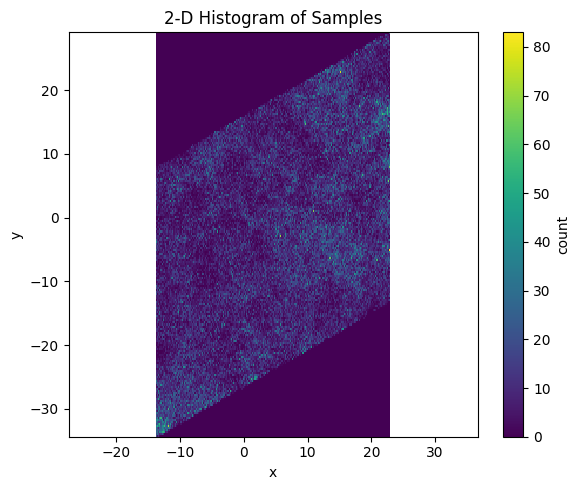

In [30]:
subkey, key = jax.random.split(key)

NDind = N_dim_indicator
rho = lambda x: psi_solid_wavefn(x).conj() * psi_solid_wavefn(x)

# burnin
samples, acceptance_rate = metropolis_hastings(
    subkey,
    R0,
    10000,
    0.5,
    NDind, rho
)
R0 = samples[-1]

print(acceptance_rate)

subkey, key = jax.random.split(key)

samples, acceptance_rate = metropolis_hastings(
    subkey,
    R0,
    16384,
    0.5,
    NDind, rho
)
R0 = samples[-1]

print(acceptance_rate)
points = samples.reshape(-1, 2)

plt.figure(figsize=(6, 5))
plt.hist2d(
    points[:, 0],   # x 축
    points[:, 1],   # y 축
    bins=200,             # 격자 수(원하는 해상도로 조정)
    density=False         # 빈도수 그대로 볼 때 False, 확률밀도로 보려면 True
)
plt.colorbar(label='count')  # 각 칸의 샘플 개수 표시
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Histogram of Samples')
plt.tight_layout()
plt.axis('equal')
plt.show()

## Train loop

In [8]:
from jax.profiler import TraceAnnotation
import time

def train(
    wave_fn: eqx.Module,
    optim: optax.GradientTransformation,
    R0: Float[Array, "n_par spc_dim"],
    batch_size: int,
    steps: int,
    key: PRNGKeyArray
):
    opt_state = optim.init(eqx.filter(wave_fn, eqx.is_array))

    energies = np.zeros(steps)
    gradnorms = np.zeros(steps)
    acceptance_rates = np.zeros(steps)
    
    @eqx.filter_jit
    def make_step(
        wave_fn: eqx.Module,
        opt_state: PyTree,
        samples: Float[Array, "b n_par spc_dim"],
    ):
        # local energy
        # start = time.time()
        E_locs = jax.vmap(moire.local_energy,
                          in_axes=(None, 0, None, None, None))(
            wave_fn, samples, V0, a_M, varphi
        ) # (batch,)
        # E_locs.block_until_ready()
        # elapsed = time.time() - start
        # print(f"local energy evaluation: {elapsed:.4f} sec")
        
        # grad_log_psi_square
        def log_psi_conj(wfn, x):
            return jnp.log(wfn(x).conj())

        def grad_log_psi_conj(wfn, x):
            trainables, statics = eqx.partition(wfn, eqx.is_inexact_array)
            def f(trainables, x):
                _wfn = eqx.combine(trainables, statics)
                return log_psi_conj(_wfn, x)
            return nk.jax.grad(f)(trainables, x)
        
        # start = time.time()
        grad_log_psi_conjs = jax.vmap(grad_log_psi_conj, in_axes=(None, 0))(wave_fn, samples)
        # grad_log_psi_conjs.periodic_embedding.linear.weight.block_until_ready()
        # elapsed = time.time() - start
        # print(f"grad_log_psi_conjs evaluation: {elapsed:.4f} sec")
        
        # batch mean
        # start = time.time()
        E_mean = jnp.mean(E_locs)
        grad_log_psi_conjs_mean = jax.tree_util.tree_map(lambda g: jnp.mean(g, axis=0), grad_log_psi_conjs)
        # E_mean.block_until_ready()
        # grad_log_psi_conjs_mean.periodic_embedding.linear.weight.block_until_ready()
        # elapsed = time.time() - start
        # print(f"batch means evaluation: {elapsed:.4f} sec")
        
        # covariance
        def vmc_cov(g, g_mean):
            centered_g = g - g_mean
            return 2 * jnp.real(jnp.einsum('b,b...->...', centered_E, centered_g) / batch_size)
        
        # start = time.time()
        centered_E = E_locs - E_mean
        grads = jax.tree_util.tree_map(vmc_cov, grad_log_psi_conjs, grad_log_psi_conjs_mean)
        # grads.periodic_embedding.linear.weight.block_until_ready()
        # elapsed = time.time() - start
        # print(f"covariance evaluation: {elapsed:.4f} sec")
        
        # start = time.time()
        updates, opt_state = optim.update(
            eqx.filter(grads, eqx.is_array), opt_state, eqx.filter(wave_fn, eqx.is_array)
        )
        wave_fn = eqx.apply_updates(wave_fn, updates)
        # wave_fn.periodic_embedding.linear.weight.block_until_ready()
        # elapsed = time.time() - start
        # print(f"update: {elapsed:.4f} sec")
        
        # start = time.time()
        grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)))
        # grad_norm.block_until_ready()
        # elapsed = time.time() - start
        # print(f"gradnorm: {elapsed:.4f} sec")
        return wave_fn, opt_state, jnp.real(E_mean), grad_norm
    
    pbar = tqdm.trange(steps, desc="training", unit="step")
    for step in pbar:
        key, subkey = jax.random.split(key)
        
        # MCMC sampling
        start = time.time()
        samples, acceptance_rate = metropolis_hastings(
            subkey,
            R0,
            batch_size,
            0.5,
            N_dim_indicator, 
            lambda x: jnp.abs(wave_fn(x).conj() * wave_fn(x))
        )
        R0 = samples[-1]
        elapsed = time.time() - start
        print(f"MCMC: {elapsed:.4f} sec")
        start = time.time()
        wave_fn, opt_state, energy, grad_norm = make_step(wave_fn, opt_state, samples)
        elapsed = time.time() - start
        print(f"grad eval & update: {elapsed:.4f} sec")
        
        energies[step] = float(energy)
        gradnorms[step] = float(grad_norm)
        acceptance_rates[step] = float(acceptance_rate)
        
        pbar.set_postfix(energy=float(energy), gradnorm=float(grad_norm), mh_acc=float(acceptance_rate))
    
    return wave_fn, energies, gradnorms, acceptance_rates

In [9]:
def count_parameters(model):
    leaves = jax.tree.leaves(model)
    return sum(x.size for x in leaves if isinstance(x, jnp.ndarray))

count_parameters(psi_solid_wavefn), count_parameters(slater_wavefn)

(106744, 35588)

In [11]:
n_batches = 1024
n_steps = 1536
start_learning_rate = 1e-3
optim = optax.adam(start_learning_rate)
# optim = optax.scale_by_lbfgs()

key, subkey = jax.random.split(key, 2)

wave_fn, energies, gradnorms, acceptance_rates = train(slater_wavefn, optim, R0, n_batches, n_steps, subkey)

training:   0%|          | 0/1536 [00:00<?, ?step/s]

MCMC: 0.6893 sec


training:   0%|          | 1/1536 [00:19<8:07:50, 19.07s/step, energy=8.04, gradnorm=25.8, mh_acc=0.478]

grad eval & update: 18.3774 sec
MCMC: 0.7202 sec


training:   0%|          | 2/1536 [00:35<7:21:30, 17.27s/step, energy=8.39, gradnorm=16.2, mh_acc=0.389]

grad eval & update: 15.2855 sec
MCMC: 0.7157 sec


training:   0%|          | 3/1536 [00:51<7:09:31, 16.81s/step, energy=7.81, gradnorm=19.5, mh_acc=0.337]

grad eval & update: 15.5458 sec
MCMC: 0.7436 sec


training:   0%|          | 4/1536 [01:08<7:08:28, 16.78s/step, energy=7.89, gradnorm=5.79, mh_acc=0.408]

grad eval & update: 15.9884 sec
MCMC: 0.7319 sec


training:   0%|          | 5/1536 [01:23<6:56:11, 16.31s/step, energy=7.8, gradnorm=17.7, mh_acc=0.415] 

grad eval & update: 14.7409 sec
MCMC: 0.7328 sec


training:   0%|          | 6/1536 [01:38<6:47:25, 15.98s/step, energy=8.57, gradnorm=25.2, mh_acc=0.485]

grad eval & update: 14.5923 sec
MCMC: 0.8266 sec


training:   0%|          | 7/1536 [01:54<6:40:41, 15.72s/step, energy=7.73, gradnorm=11.4, mh_acc=0.436]

grad eval & update: 14.3721 sec
MCMC: 0.8288 sec


training:   1%|          | 8/1536 [02:08<6:33:30, 15.45s/step, energy=7.7, gradnorm=8.11, mh_acc=0.359] 

grad eval & update: 14.0401 sec
MCMC: 0.8087 sec


training:   1%|          | 9/1536 [02:24<6:31:37, 15.39s/step, energy=8.36, gradnorm=16.5, mh_acc=0.464]

grad eval & update: 14.4350 sec
MCMC: 0.7931 sec


training:   1%|          | 10/1536 [02:39<6:33:49, 15.48s/step, energy=8.13, gradnorm=12.6, mh_acc=0.389]

grad eval & update: 14.9027 sec
MCMC: 1.0472 sec


training:   1%|          | 11/1536 [02:55<6:34:05, 15.50s/step, energy=7.83, gradnorm=11.5, mh_acc=0.45] 

grad eval & update: 14.4996 sec
MCMC: 0.8019 sec


training:   1%|          | 12/1536 [03:11<6:37:19, 15.64s/step, energy=8.24, gradnorm=7.98, mh_acc=0.396]

grad eval & update: 15.1533 sec
MCMC: 0.8722 sec


training:   1%|          | 13/1536 [03:27<6:39:52, 15.75s/step, energy=7.74, gradnorm=11.2, mh_acc=0.492]

grad eval & update: 15.1351 sec
MCMC: 0.8578 sec


training:   1%|          | 14/1536 [03:43<6:41:11, 15.82s/step, energy=7.51, gradnorm=9.9, mh_acc=0.423] 

grad eval & update: 15.0997 sec
MCMC: 0.8912 sec


training:   1%|          | 15/1536 [03:58<6:34:47, 15.57s/step, energy=7.36, gradnorm=5.21, mh_acc=0.439]

grad eval & update: 14.1172 sec
MCMC: 0.8336 sec


training:   1%|          | 16/1536 [04:13<6:32:25, 15.49s/step, energy=8.18, gradnorm=21.1, mh_acc=0.499]

grad eval & update: 14.4624 sec
MCMC: 0.8451 sec


training:   1%|          | 17/1536 [04:28<6:25:05, 15.21s/step, energy=7.83, gradnorm=6.28, mh_acc=0.514]

grad eval & update: 13.7109 sec
MCMC: 1.0418 sec


training:   1%|          | 18/1536 [04:43<6:24:12, 15.19s/step, energy=8.14, gradnorm=7.18, mh_acc=0.414]

grad eval & update: 14.0826 sec
MCMC: 0.8379 sec


training:   1%|          | 19/1536 [04:59<6:29:30, 15.41s/step, energy=7.96, gradnorm=12.1, mh_acc=0.395]

grad eval & update: 15.0755 sec
MCMC: 0.8112 sec


training:   1%|▏         | 20/1536 [05:15<6:31:53, 15.51s/step, energy=8.02, gradnorm=10.4, mh_acc=0.443]

grad eval & update: 14.9402 sec
MCMC: 0.7886 sec


training:   1%|▏         | 21/1536 [05:30<6:33:01, 15.57s/step, energy=8.39, gradnorm=7.55, mh_acc=0.43] 

grad eval & update: 14.9013 sec
MCMC: 0.7785 sec


training:   1%|▏         | 22/1536 [05:47<6:39:38, 15.84s/step, energy=7.66, gradnorm=5.38, mh_acc=0.451]

grad eval & update: 15.6918 sec
MCMC: 0.8649 sec


training:   1%|▏         | 23/1536 [06:03<6:44:02, 16.02s/step, energy=8.1, gradnorm=11.5, mh_acc=0.501] 

grad eval & update: 15.5858 sec
MCMC: 0.8066 sec


training:   2%|▏         | 24/1536 [06:19<6:44:16, 16.04s/step, energy=8.19, gradnorm=6.33, mh_acc=0.414]

grad eval & update: 15.2783 sec
MCMC: 0.8184 sec


training:   2%|▏         | 25/1536 [06:36<6:45:33, 16.10s/step, energy=7.7, gradnorm=9.56, mh_acc=0.421] 

grad eval & update: 15.4250 sec
MCMC: 0.7865 sec


training:   2%|▏         | 26/1536 [06:52<6:46:55, 16.17s/step, energy=8.03, gradnorm=5.55, mh_acc=0.416]

grad eval & update: 15.5328 sec
MCMC: 0.8405 sec


training:   2%|▏         | 27/1536 [07:08<6:50:12, 16.31s/step, energy=8.3, gradnorm=7.38, mh_acc=0.326] 

grad eval & update: 15.7957 sec
MCMC: 0.7751 sec


training:   2%|▏         | 28/1536 [07:25<6:49:35, 16.30s/step, energy=7.94, gradnorm=9.2, mh_acc=0.366]

grad eval & update: 15.4863 sec
MCMC: 0.8679 sec


training:   2%|▏         | 29/1536 [07:42<6:55:41, 16.55s/step, energy=8.02, gradnorm=12.3, mh_acc=0.431]

grad eval & update: 16.2708 sec
MCMC: 0.8282 sec


training:   2%|▏         | 30/1536 [08:00<7:04:03, 16.89s/step, energy=8.11, gradnorm=6.82, mh_acc=0.487]

grad eval & update: 16.8660 sec
MCMC: 0.8489 sec


training:   2%|▏         | 31/1536 [08:17<7:07:42, 17.05s/step, energy=8.25, gradnorm=8.94, mh_acc=0.447]

grad eval & update: 16.5654 sec
MCMC: 0.7603 sec


training:   2%|▏         | 32/1536 [08:34<7:04:20, 16.93s/step, energy=8.27, gradnorm=8.87, mh_acc=0.444]

grad eval & update: 15.8778 sec
MCMC: 0.7639 sec


training:   2%|▏         | 33/1536 [08:49<6:55:16, 16.58s/step, energy=8.21, gradnorm=14, mh_acc=0.484]  

grad eval & update: 14.9918 sec
MCMC: 0.7326 sec


training:   2%|▏         | 34/1536 [09:04<6:43:02, 16.10s/step, energy=7.58, gradnorm=6.1, mh_acc=0.415]

grad eval & update: 14.2475 sec
MCMC: 0.7596 sec


training:   2%|▏         | 35/1536 [09:20<6:38:23, 15.93s/step, energy=7.9, gradnorm=7.51, mh_acc=0.403]

grad eval & update: 14.7520 sec
MCMC: 0.7220 sec


training:   2%|▏         | 36/1536 [09:35<6:34:39, 15.79s/step, energy=7.43, gradnorm=12.1, mh_acc=0.407]

grad eval & update: 14.7387 sec
MCMC: 0.7783 sec


training:   2%|▏         | 37/1536 [09:52<6:40:41, 16.04s/step, energy=7.77, gradnorm=7.51, mh_acc=0.415]

grad eval & update: 15.8428 sec
MCMC: 1.0699 sec


training:   2%|▏         | 38/1536 [10:12<7:11:25, 17.28s/step, energy=7.76, gradnorm=4.24, mh_acc=0.405]

grad eval & update: 19.1047 sec
MCMC: 1.0043 sec


training:   3%|▎         | 39/1536 [10:32<7:27:36, 17.94s/step, energy=7.41, gradnorm=11, mh_acc=0.434]  

grad eval & update: 18.4724 sec
MCMC: 0.7381 sec


training:   3%|▎         | 40/1536 [10:47<7:09:16, 17.22s/step, energy=7.49, gradnorm=5.41, mh_acc=0.449]

grad eval & update: 14.7862 sec
MCMC: 0.8116 sec


training:   3%|▎         | 41/1536 [11:05<7:12:00, 17.34s/step, energy=7.91, gradnorm=11.8, mh_acc=0.464]

grad eval & update: 16.8069 sec
MCMC: 0.8073 sec


training:   3%|▎         | 42/1536 [11:23<7:19:34, 17.65s/step, energy=8.93, gradnorm=8.65, mh_acc=0.51] 

grad eval & update: 17.5794 sec
MCMC: 0.7799 sec


training:   3%|▎         | 43/1536 [11:42<7:26:11, 17.93s/step, energy=7.74, gradnorm=10.1, mh_acc=0.427]

grad eval & update: 17.7962 sec
MCMC: 0.7464 sec


training:   3%|▎         | 44/1536 [12:00<7:31:07, 18.14s/step, energy=7.97, gradnorm=9.84, mh_acc=0.466]

grad eval & update: 17.8836 sec
MCMC: 0.8951 sec


training:   3%|▎         | 45/1536 [12:20<7:39:32, 18.49s/step, energy=8.21, gradnorm=6.77, mh_acc=0.435]

grad eval & update: 18.4128 sec
MCMC: 0.8040 sec


training:   3%|▎         | 46/1536 [12:37<7:28:51, 18.08s/step, energy=8.28, gradnorm=8.85, mh_acc=0.4]  

grad eval & update: 16.2933 sec
MCMC: 0.8584 sec


training:   3%|▎         | 47/1536 [12:55<7:30:13, 18.14s/step, energy=7.5, gradnorm=5.62, mh_acc=0.405]

grad eval & update: 17.4373 sec
MCMC: 0.8815 sec


training:   3%|▎         | 48/1536 [13:13<7:29:12, 18.11s/step, energy=7.34, gradnorm=5.03, mh_acc=0.443]

grad eval & update: 17.1598 sec
MCMC: 0.8119 sec


training:   3%|▎         | 49/1536 [13:31<7:23:35, 17.90s/step, energy=7.81, gradnorm=3.62, mh_acc=0.476]

grad eval & update: 16.5817 sec
MCMC: 0.9426 sec


training:   3%|▎         | 50/1536 [13:50<7:34:42, 18.36s/step, energy=7.93, gradnorm=5.17, mh_acc=0.429]

grad eval & update: 18.4883 sec
MCMC: 1.1281 sec


training:   3%|▎         | 51/1536 [14:09<7:42:45, 18.70s/step, energy=8.2, gradnorm=5.19, mh_acc=0.52]  

grad eval & update: 18.3553 sec
MCMC: 1.1873 sec


training:   3%|▎         | 52/1536 [14:28<7:42:05, 18.68s/step, energy=7.41, gradnorm=6.59, mh_acc=0.444]

grad eval & update: 17.4580 sec
MCMC: 1.1811 sec


training:   3%|▎         | 53/1536 [14:48<7:50:13, 19.02s/step, energy=7.23, gradnorm=5.52, mh_acc=0.429]

grad eval & update: 18.6341 sec
MCMC: 1.0973 sec


training:   4%|▎         | 54/1536 [15:08<7:55:42, 19.26s/step, energy=7.7, gradnorm=6.61, mh_acc=0.362] 

grad eval & update: 18.7082 sec
MCMC: 1.1069 sec


training:   4%|▎         | 55/1536 [15:28<8:03:53, 19.60s/step, energy=7.63, gradnorm=5.92, mh_acc=0.348]

grad eval & update: 19.2985 sec
MCMC: 1.9702 sec


training:   4%|▎         | 56/1536 [15:48<8:04:28, 19.64s/step, energy=7.64, gradnorm=7.92, mh_acc=0.442]

grad eval & update: 17.7542 sec
MCMC: 1.1200 sec


training:   4%|▎         | 57/1536 [16:08<8:06:38, 19.74s/step, energy=7.5, gradnorm=5.92, mh_acc=0.497] 

grad eval & update: 18.8546 sec
MCMC: 1.1371 sec


training:   4%|▍         | 58/1536 [16:27<8:00:36, 19.51s/step, energy=7.29, gradnorm=4.87, mh_acc=0.417]

grad eval & update: 17.8311 sec
MCMC: 1.1235 sec


training:   4%|▍         | 59/1536 [16:46<8:00:20, 19.51s/step, energy=7.72, gradnorm=4.36, mh_acc=0.39] 

grad eval & update: 18.3922 sec
MCMC: 0.9830 sec


training:   4%|▍         | 60/1536 [17:05<7:55:32, 19.33s/step, energy=7.75, gradnorm=3.26, mh_acc=0.364]

grad eval & update: 17.9195 sec
MCMC: 1.1192 sec


training:   4%|▍         | 61/1536 [17:26<8:06:40, 19.80s/step, energy=7.72, gradnorm=5.45, mh_acc=0.281]

grad eval & update: 19.7635 sec
MCMC: 1.1503 sec


training:   4%|▍         | 62/1536 [17:46<8:08:25, 19.88s/step, energy=7.46, gradnorm=5.44, mh_acc=0.329]

grad eval & update: 18.9216 sec
MCMC: 1.2124 sec


training:   4%|▍         | 63/1536 [18:06<8:05:26, 19.77s/step, energy=7.58, gradnorm=6.36, mh_acc=0.369]

grad eval & update: 18.3060 sec
MCMC: 1.1342 sec


training:   4%|▍         | 64/1536 [18:25<8:01:12, 19.61s/step, energy=6.81, gradnorm=3.8, mh_acc=0.384] 

grad eval & update: 18.1042 sec
MCMC: 1.0773 sec


training:   4%|▍         | 65/1536 [18:42<7:39:38, 18.75s/step, energy=7.36, gradnorm=4.2, mh_acc=0.409]

grad eval & update: 15.6424 sec
MCMC: 0.9538 sec


training:   4%|▍         | 66/1536 [18:59<7:27:42, 18.27s/step, energy=8.17, gradnorm=4.93, mh_acc=0.511]

grad eval & update: 16.2097 sec
MCMC: 1.0768 sec


training:   4%|▍         | 67/1536 [19:19<7:40:36, 18.81s/step, energy=7.58, gradnorm=7.71, mh_acc=0.489]

grad eval & update: 18.9930 sec
MCMC: 0.9279 sec


training:   4%|▍         | 68/1536 [19:39<7:49:42, 19.20s/step, energy=7.6, gradnorm=7.75, mh_acc=0.452] 

grad eval & update: 19.1649 sec
MCMC: 1.1496 sec


training:   4%|▍         | 69/1536 [20:00<7:59:14, 19.60s/step, energy=7.79, gradnorm=7.22, mh_acc=0.386]

grad eval & update: 19.3878 sec
MCMC: 1.1155 sec


training:   5%|▍         | 70/1536 [20:20<8:03:46, 19.80s/step, energy=7.89, gradnorm=8.55, mh_acc=0.435]

grad eval & update: 19.1428 sec
MCMC: 1.0949 sec


training:   5%|▍         | 71/1536 [20:40<8:03:45, 19.81s/step, energy=7.29, gradnorm=5.58, mh_acc=0.441]

grad eval & update: 18.7439 sec
MCMC: 1.1248 sec


training:   5%|▍         | 72/1536 [20:59<7:58:17, 19.60s/step, energy=7.68, gradnorm=7.6, mh_acc=0.405] 

grad eval & update: 17.9813 sec
MCMC: 1.1075 sec


training:   5%|▍         | 73/1536 [21:19<8:00:54, 19.72s/step, energy=7.81, gradnorm=4.42, mh_acc=0.415]

grad eval & update: 18.8916 sec
MCMC: 0.9881 sec


training:   5%|▍         | 74/1536 [21:38<7:59:39, 19.69s/step, energy=8.04, gradnorm=9.73, mh_acc=0.394]

grad eval & update: 18.6073 sec
MCMC: 1.0531 sec


training:   5%|▍         | 75/1536 [21:58<7:57:42, 19.62s/step, energy=7.45, gradnorm=4.11, mh_acc=0.436]

grad eval & update: 18.4026 sec
MCMC: 1.0145 sec


training:   5%|▍         | 76/1536 [22:18<8:00:15, 19.74s/step, energy=7.43, gradnorm=7.85, mh_acc=0.398]

grad eval & update: 18.9937 sec
MCMC: 1.0699 sec


training:   5%|▌         | 77/1536 [22:37<7:57:56, 19.66s/step, energy=7.29, gradnorm=7.58, mh_acc=0.375]

grad eval & update: 18.3917 sec
MCMC: 1.0547 sec


training:   5%|▌         | 78/1536 [22:57<7:59:02, 19.71s/step, energy=7.52, gradnorm=11.8, mh_acc=0.469]

grad eval & update: 18.7915 sec
MCMC: 1.0808 sec


training:   5%|▌         | 79/1536 [23:18<8:03:09, 19.90s/step, energy=7.61, gradnorm=6.17, mh_acc=0.438]

grad eval & update: 19.2377 sec
MCMC: 1.0380 sec


training:   5%|▌         | 80/1536 [23:37<8:01:11, 19.83s/step, energy=7.2, gradnorm=5.13, mh_acc=0.39]  

grad eval & update: 18.6309 sec
MCMC: 1.0858 sec


training:   5%|▌         | 81/1536 [23:57<8:01:00, 19.84s/step, energy=7.75, gradnorm=6.06, mh_acc=0.398]

grad eval & update: 18.7610 sec
MCMC: 1.0668 sec


training:   5%|▌         | 82/1536 [24:16<7:57:27, 19.70s/step, energy=7.59, gradnorm=10, mh_acc=0.417]  

grad eval & update: 18.3207 sec
MCMC: 0.9713 sec


training:   5%|▌         | 83/1536 [24:36<7:52:46, 19.52s/step, energy=7.11, gradnorm=6.89, mh_acc=0.458]

grad eval & update: 18.1290 sec
MCMC: 1.0210 sec


training:   5%|▌         | 84/1536 [24:55<7:48:53, 19.38s/step, energy=7.54, gradnorm=11, mh_acc=0.487]  

grad eval & update: 18.0072 sec
MCMC: 1.0120 sec


training:   6%|▌         | 85/1536 [25:14<7:47:00, 19.31s/step, energy=7.29, gradnorm=6.68, mh_acc=0.43]

grad eval & update: 18.1461 sec
MCMC: 1.0938 sec


training:   6%|▌         | 86/1536 [25:32<7:42:05, 19.12s/step, energy=7.39, gradnorm=12.6, mh_acc=0.455]

grad eval & update: 17.5820 sec
MCMC: 1.0578 sec


training:   6%|▌         | 87/1536 [25:53<7:50:05, 19.47s/step, energy=7.89, gradnorm=9.32, mh_acc=0.544]

grad eval & update: 19.2051 sec
MCMC: 1.0628 sec


training:   6%|▌         | 88/1536 [26:13<7:55:17, 19.69s/step, energy=7.67, gradnorm=6.14, mh_acc=0.381]

grad eval & update: 19.1629 sec
MCMC: 1.1830 sec


training:   6%|▌         | 89/1536 [26:33<7:57:42, 19.81s/step, energy=7.56, gradnorm=5.65, mh_acc=0.345]

grad eval & update: 18.8872 sec
MCMC: 1.0516 sec


training:   6%|▌         | 90/1536 [26:56<8:17:16, 20.63s/step, energy=7.24, gradnorm=5.5, mh_acc=0.449] 

grad eval & update: 21.5074 sec
MCMC: 1.0737 sec


training:   6%|▌         | 91/1536 [27:15<8:08:52, 20.30s/step, energy=7.39, gradnorm=3.77, mh_acc=0.42]

grad eval & update: 18.4407 sec
MCMC: 1.1277 sec


training:   6%|▌         | 92/1536 [27:35<8:08:26, 20.30s/step, energy=7.59, gradnorm=7.69, mh_acc=0.452]

grad eval & update: 19.1550 sec
MCMC: 1.0631 sec


training:   6%|▌         | 93/1536 [27:55<8:04:06, 20.13s/step, energy=7.6, gradnorm=4.11, mh_acc=0.494] 

grad eval & update: 18.6745 sec
MCMC: 1.0666 sec


training:   6%|▌         | 94/1536 [28:15<8:04:57, 20.18s/step, energy=7.78, gradnorm=7.47, mh_acc=0.49]

grad eval & update: 19.2223 sec
MCMC: 1.0898 sec


training:   6%|▌         | 95/1536 [28:36<8:07:47, 20.31s/step, energy=7.34, gradnorm=6.07, mh_acc=0.504]

grad eval & update: 19.5248 sec
MCMC: 1.0933 sec


training:   6%|▋         | 96/1536 [28:57<8:10:45, 20.45s/step, energy=7.54, gradnorm=5.73, mh_acc=0.511]

grad eval & update: 19.6737 sec
MCMC: 1.0129 sec


training:   6%|▋         | 97/1536 [29:17<8:07:33, 20.33s/step, energy=7.23, gradnorm=4.35, mh_acc=0.414]

grad eval & update: 19.0330 sec
MCMC: 1.0772 sec


training:   6%|▋         | 98/1536 [29:36<8:01:19, 20.08s/step, energy=7.35, gradnorm=4.98, mh_acc=0.422]

grad eval & update: 18.4298 sec
MCMC: 1.0799 sec


training:   6%|▋         | 99/1536 [29:55<7:50:48, 19.66s/step, energy=7.37, gradnorm=5.08, mh_acc=0.469]

grad eval & update: 17.5821 sec
MCMC: 0.8907 sec


training:   7%|▋         | 100/1536 [30:13<7:38:34, 19.16s/step, energy=7.31, gradnorm=4.62, mh_acc=0.404]

grad eval & update: 17.1049 sec
MCMC: 0.9316 sec


training:   7%|▋         | 101/1536 [30:31<7:29:53, 18.81s/step, energy=7.13, gradnorm=2.24, mh_acc=0.418]

grad eval & update: 17.0610 sec
MCMC: 1.5494 sec


training:   7%|▋         | 102/1536 [30:50<7:30:24, 18.85s/step, energy=7.18, gradnorm=3.55, mh_acc=0.441]

grad eval & update: 17.3736 sec
MCMC: 0.9050 sec


training:   7%|▋         | 103/1536 [31:08<7:21:37, 18.49s/step, energy=7.51, gradnorm=4.39, mh_acc=0.496]

grad eval & update: 16.7552 sec
MCMC: 0.9499 sec


training:   7%|▋         | 104/1536 [31:25<7:11:57, 18.10s/step, energy=7.67, gradnorm=5.48, mh_acc=0.402]

grad eval & update: 16.2309 sec
MCMC: 0.9714 sec


training:   7%|▋         | 105/1536 [31:42<7:07:36, 17.93s/step, energy=7.57, gradnorm=7.96, mh_acc=0.438]

grad eval & update: 16.5566 sec
MCMC: 0.9004 sec


training:   7%|▋         | 106/1536 [31:59<6:57:52, 17.53s/step, energy=8.05, gradnorm=9.48, mh_acc=0.455]

grad eval & update: 15.7055 sec
MCMC: 0.9259 sec


training:   7%|▋         | 107/1536 [32:16<6:53:25, 17.36s/step, energy=8.04, gradnorm=6.45, mh_acc=0.412]

grad eval & update: 16.0227 sec
MCMC: 0.8992 sec


training:   7%|▋         | 108/1536 [32:34<6:55:43, 17.47s/step, energy=7.34, gradnorm=7.66, mh_acc=0.354]

grad eval & update: 16.8169 sec
MCMC: 0.7589 sec


training:   7%|▋         | 109/1536 [32:52<7:02:49, 17.78s/step, energy=7.43, gradnorm=5.06, mh_acc=0.475]

grad eval & update: 17.7407 sec
MCMC: 0.7200 sec


training:   7%|▋         | 110/1536 [33:08<6:48:45, 17.20s/step, energy=7.35, gradnorm=6.76, mh_acc=0.451]

grad eval & update: 15.1238 sec
MCMC: 0.6787 sec


training:   7%|▋         | 111/1536 [33:24<6:43:42, 17.00s/step, energy=7.65, gradnorm=7.18, mh_acc=0.467]

grad eval & update: 15.8467 sec
MCMC: 0.6223 sec


training:   7%|▋         | 112/1536 [33:41<6:37:47, 16.76s/step, energy=7.68, gradnorm=4.41, mh_acc=0.467]

grad eval & update: 15.5830 sec
MCMC: 0.6552 sec


training:   7%|▋         | 113/1536 [33:58<6:42:27, 16.97s/step, energy=7.75, gradnorm=10.5, mh_acc=0.461]

grad eval & update: 16.7976 sec
MCMC: 0.6712 sec


training:   7%|▋         | 114/1536 [34:15<6:38:57, 16.83s/step, energy=7.49, gradnorm=5.14, mh_acc=0.439]

grad eval & update: 15.8437 sec
MCMC: 0.6721 sec


training:   7%|▋         | 115/1536 [34:32<6:40:26, 16.91s/step, energy=7.91, gradnorm=7.4, mh_acc=0.339] 

grad eval & update: 16.4086 sec
MCMC: 0.7063 sec


training:   8%|▊         | 116/1536 [34:49<6:41:32, 16.97s/step, energy=8.5, gradnorm=5.11, mh_acc=0.391]

grad eval & update: 16.3926 sec
MCMC: 0.6661 sec


training:   8%|▊         | 117/1536 [35:04<6:30:25, 16.51s/step, energy=7.74, gradnorm=2.98, mh_acc=0.432]

grad eval & update: 14.7696 sec
MCMC: 0.6223 sec


training:   8%|▊         | 118/1536 [35:21<6:32:02, 16.59s/step, energy=7.31, gradnorm=5.25, mh_acc=0.453]

grad eval & update: 16.1495 sec
MCMC: 0.6532 sec


training:   8%|▊         | 119/1536 [35:37<6:29:56, 16.51s/step, energy=7.26, gradnorm=4.38, mh_acc=0.422]

grad eval & update: 15.6765 sec
MCMC: 0.6800 sec


training:   8%|▊         | 120/1536 [35:54<6:27:50, 16.43s/step, energy=7.47, gradnorm=3.68, mh_acc=0.48] 

grad eval & update: 15.5711 sec
MCMC: 0.6251 sec


training:   8%|▊         | 121/1536 [36:10<6:25:09, 16.33s/step, energy=7.51, gradnorm=5.38, mh_acc=0.422]

grad eval & update: 15.4632 sec
MCMC: 0.6678 sec


training:   8%|▊         | 122/1536 [36:26<6:23:55, 16.29s/step, energy=7.48, gradnorm=8.1, mh_acc=0.454] 

grad eval & update: 15.5233 sec
MCMC: 0.6310 sec


training:   8%|▊         | 123/1536 [36:41<6:17:13, 16.02s/step, energy=7.61, gradnorm=3.08, mh_acc=0.408]

grad eval & update: 14.7469 sec
MCMC: 0.6378 sec


training:   8%|▊         | 124/1536 [36:57<6:11:53, 15.80s/step, energy=7.47, gradnorm=11, mh_acc=0.448]  

grad eval & update: 14.6602 sec
MCMC: 0.6450 sec


training:   8%|▊         | 125/1536 [37:13<6:14:13, 15.91s/step, energy=7.33, gradnorm=3.59, mh_acc=0.412]

grad eval & update: 15.5212 sec
MCMC: 0.6511 sec


training:   8%|▊         | 126/1536 [37:29<6:19:23, 16.14s/step, energy=7.32, gradnorm=4.99, mh_acc=0.556]

grad eval & update: 16.0303 sec
MCMC: 0.6790 sec


training:   8%|▊         | 127/1536 [37:45<6:17:55, 16.09s/step, energy=7.31, gradnorm=4.2, mh_acc=0.478] 

grad eval & update: 15.2922 sec
MCMC: 0.6750 sec


training:   8%|▊         | 128/1536 [38:02<6:19:31, 16.17s/step, energy=7.42, gradnorm=5.68, mh_acc=0.473]

grad eval & update: 15.6807 sec
MCMC: 0.6935 sec


training:   8%|▊         | 129/1536 [38:17<6:11:43, 15.85s/step, energy=7.44, gradnorm=6.58, mh_acc=0.43] 

grad eval & update: 14.4078 sec
MCMC: 0.6678 sec


training:   8%|▊         | 130/1536 [38:32<6:06:02, 15.62s/step, energy=7.08, gradnorm=4.51, mh_acc=0.394]

grad eval & update: 14.4111 sec
MCMC: 0.6982 sec


training:   9%|▊         | 131/1536 [38:47<6:01:08, 15.42s/step, energy=7.36, gradnorm=7.05, mh_acc=0.388]

grad eval & update: 14.2576 sec
MCMC: 0.6511 sec


training:   9%|▊         | 132/1536 [39:03<6:06:10, 15.65s/step, energy=7.52, gradnorm=10.4, mh_acc=0.475]

grad eval & update: 15.5218 sec
MCMC: 0.7137 sec


training:   9%|▊         | 133/1536 [39:18<6:00:38, 15.42s/step, energy=7.64, gradnorm=5.34, mh_acc=0.349]

grad eval & update: 14.1806 sec
MCMC: 0.6818 sec


training:   9%|▊         | 134/1536 [39:34<6:02:44, 15.52s/step, energy=7.16, gradnorm=4.97, mh_acc=0.4]  

grad eval & update: 15.0760 sec
MCMC: 0.6923 sec


training:   9%|▉         | 135/1536 [39:49<6:01:40, 15.49s/step, energy=7.34, gradnorm=9.55, mh_acc=0.402]

grad eval & update: 14.7142 sec
MCMC: 0.6490 sec


training:   9%|▉         | 136/1536 [40:04<5:59:01, 15.39s/step, energy=7.01, gradnorm=7.65, mh_acc=0.408]

grad eval & update: 14.4955 sec
MCMC: 0.6958 sec


training:   9%|▉         | 137/1536 [40:19<5:55:58, 15.27s/step, energy=7.26, gradnorm=5.77, mh_acc=0.444]

grad eval & update: 14.2858 sec
MCMC: 0.6369 sec


training:   9%|▉         | 138/1536 [40:34<5:54:24, 15.21s/step, energy=7.19, gradnorm=3.72, mh_acc=0.479]

grad eval & update: 14.4405 sec
MCMC: 0.6716 sec


training:   9%|▉         | 139/1536 [40:50<6:00:03, 15.46s/step, energy=7.33, gradnorm=7.92, mh_acc=0.41] 

grad eval & update: 15.3797 sec
MCMC: 0.6692 sec


training:   9%|▉         | 140/1536 [41:05<5:56:55, 15.34s/step, energy=7.21, gradnorm=4.89, mh_acc=0.412]

grad eval & update: 14.3812 sec
MCMC: 0.6375 sec


training:   9%|▉         | 141/1536 [41:21<5:56:09, 15.32s/step, energy=8.1, gradnorm=8.2, mh_acc=0.483]  

grad eval & update: 14.6277 sec
MCMC: 0.6705 sec


training:   9%|▉         | 142/1536 [41:37<5:58:56, 15.45s/step, energy=8.16, gradnorm=7.89, mh_acc=0.407]

grad eval & update: 15.0824 sec
MCMC: 0.6503 sec


training:   9%|▉         | 143/1536 [41:53<6:04:32, 15.70s/step, energy=7.63, gradnorm=3.4, mh_acc=0.406] 

grad eval & update: 15.6398 sec
MCMC: 0.6399 sec


training:   9%|▉         | 144/1536 [42:09<6:10:13, 15.96s/step, energy=7.78, gradnorm=8.09, mh_acc=0.438]

grad eval & update: 15.9131 sec
MCMC: 0.6763 sec


training:   9%|▉         | 145/1536 [42:25<6:07:01, 15.83s/step, energy=7.49, gradnorm=7.27, mh_acc=0.431]

grad eval & update: 14.8564 sec
MCMC: 0.6878 sec


training:  10%|▉         | 146/1536 [42:41<6:05:52, 15.79s/step, energy=7.25, gradnorm=4.08, mh_acc=0.483]

grad eval & update: 15.0128 sec
MCMC: 0.6792 sec


training:  10%|▉         | 147/1536 [42:57<6:08:53, 15.94s/step, energy=7.5, gradnorm=9.28, mh_acc=0.454] 

grad eval & update: 15.5830 sec
MCMC: 0.6637 sec


training:  10%|▉         | 148/1536 [43:14<6:15:20, 16.22s/step, energy=7.26, gradnorm=6.38, mh_acc=0.423]

grad eval & update: 16.2343 sec
MCMC: 0.6691 sec


training:  10%|▉         | 149/1536 [43:30<6:15:38, 16.25s/step, energy=7.19, gradnorm=6.04, mh_acc=0.375]

grad eval & update: 15.6372 sec
MCMC: 0.7172 sec


training:  10%|▉         | 150/1536 [43:46<6:11:24, 16.08s/step, energy=7.87, gradnorm=13.4, mh_acc=0.418]

grad eval & update: 14.9573 sec
MCMC: 0.6481 sec


training:  10%|▉         | 151/1536 [44:02<6:13:52, 16.20s/step, energy=7.63, gradnorm=4.01, mh_acc=0.427]

grad eval & update: 15.8241 sec
MCMC: 0.6758 sec


training:  10%|▉         | 152/1536 [44:17<6:06:33, 15.89s/step, energy=7.77, gradnorm=5.76, mh_acc=0.43] 

grad eval & update: 14.5009 sec
MCMC: 0.6325 sec


training:  10%|▉         | 153/1536 [44:33<6:03:59, 15.79s/step, energy=7.95, gradnorm=5.15, mh_acc=0.396]

grad eval & update: 14.9230 sec
MCMC: 0.6348 sec


training:  10%|█         | 154/1536 [44:48<5:59:33, 15.61s/step, energy=7.75, gradnorm=4.1, mh_acc=0.403] 

grad eval & update: 14.5509 sec
MCMC: 1.1737 sec


training:  10%|█         | 155/1536 [45:05<6:07:43, 15.98s/step, energy=7.36, gradnorm=5.29, mh_acc=0.436]

grad eval & update: 15.6552 sec
MCMC: 0.6548 sec


training:  10%|█         | 156/1536 [45:21<6:05:23, 15.89s/step, energy=7.04, gradnorm=5.18, mh_acc=0.412]

grad eval & update: 15.0170 sec
MCMC: 1.1970 sec


training:  10%|█         | 157/1536 [45:37<6:05:19, 15.90s/step, energy=6.71, gradnorm=3.84, mh_acc=0.37] 

grad eval & update: 14.7136 sec
MCMC: 0.7505 sec


training:  10%|█         | 158/1536 [45:53<6:08:17, 16.04s/step, energy=7.12, gradnorm=4.72, mh_acc=0.384]

grad eval & update: 15.6111 sec
MCMC: 0.7394 sec


training:  10%|█         | 159/1536 [46:09<6:08:30, 16.06s/step, energy=7.37, gradnorm=3.53, mh_acc=0.455]

grad eval & update: 15.3615 sec
MCMC: 0.7248 sec


training:  10%|█         | 160/1536 [46:24<5:59:08, 15.66s/step, energy=7.24, gradnorm=4.35, mh_acc=0.366]

grad eval & update: 14.0064 sec
MCMC: 0.7132 sec


training:  10%|█         | 161/1536 [46:40<6:03:46, 15.87s/step, energy=7.85, gradnorm=11, mh_acc=0.463]  

grad eval & update: 15.6587 sec
MCMC: 0.7293 sec


training:  11%|█         | 162/1536 [46:57<6:07:54, 16.07s/step, energy=7.29, gradnorm=5, mh_acc=0.418] 

grad eval & update: 15.7826 sec
MCMC: 0.6883 sec


training:  11%|█         | 163/1536 [47:13<6:07:35, 16.06s/step, energy=8.03, gradnorm=6.75, mh_acc=0.439]

grad eval & update: 15.3655 sec
MCMC: 0.7101 sec


training:  11%|█         | 164/1536 [47:29<6:06:06, 16.01s/step, energy=7.53, gradnorm=4.07, mh_acc=0.469]

grad eval & update: 15.1737 sec
MCMC: 0.7006 sec


training:  11%|█         | 165/1536 [47:44<6:02:44, 15.87s/step, energy=7.81, gradnorm=7.51, mh_acc=0.326]

grad eval & update: 14.8545 sec
MCMC: 0.6968 sec


training:  11%|█         | 166/1536 [48:00<5:59:05, 15.73s/step, energy=7.23, gradnorm=6.97, mh_acc=0.431]

grad eval & update: 14.6826 sec
MCMC: 0.7002 sec


training:  11%|█         | 167/1536 [48:15<5:55:17, 15.57s/step, energy=7.18, gradnorm=4.67, mh_acc=0.452]

grad eval & update: 14.5074 sec
MCMC: 0.7378 sec


training:  11%|█         | 168/1536 [48:32<6:08:25, 16.16s/step, energy=7.11, gradnorm=5.2, mh_acc=0.386] 

grad eval & update: 16.7893 sec
MCMC: 0.6672 sec


training:  11%|█         | 169/1536 [48:49<6:09:46, 16.23s/step, energy=7.23, gradnorm=5.47, mh_acc=0.45]

grad eval & update: 15.7243 sec
MCMC: 0.7312 sec


training:  11%|█         | 170/1536 [49:05<6:08:53, 16.20s/step, energy=7.46, gradnorm=4.97, mh_acc=0.394]

grad eval & update: 15.4054 sec
MCMC: 0.7324 sec


training:  11%|█         | 171/1536 [49:21<6:11:42, 16.34s/step, energy=7.48, gradnorm=4.68, mh_acc=0.394]

grad eval & update: 15.9193 sec
MCMC: 0.7011 sec


training:  11%|█         | 172/1536 [49:37<6:08:34, 16.21s/step, energy=7.62, gradnorm=10.4, mh_acc=0.45] 

grad eval & update: 15.2133 sec
MCMC: 0.7252 sec


training:  11%|█▏        | 173/1536 [49:54<6:11:48, 16.37s/step, energy=7.04, gradnorm=4.22, mh_acc=0.442]

grad eval & update: 15.9988 sec
MCMC: 0.7494 sec


training:  11%|█▏        | 174/1536 [50:10<6:11:00, 16.34s/step, energy=7.52, gradnorm=10.8, mh_acc=0.409]

grad eval & update: 15.5401 sec
MCMC: 0.7370 sec


training:  11%|█▏        | 175/1536 [50:27<6:13:51, 16.48s/step, energy=7.2, gradnorm=5.25, mh_acc=0.432] 

grad eval & update: 16.0636 sec
MCMC: 0.7045 sec


training:  11%|█▏        | 176/1536 [50:42<6:04:51, 16.10s/step, energy=7.48, gradnorm=7.26, mh_acc=0.426]

grad eval & update: 14.4889 sec
MCMC: 0.6810 sec


training:  12%|█▏        | 177/1536 [50:58<6:01:04, 15.94s/step, energy=7.48, gradnorm=5.65, mh_acc=0.448]

grad eval & update: 14.8947 sec
MCMC: 0.7437 sec


training:  12%|█▏        | 178/1536 [51:14<6:04:12, 16.09s/step, energy=7.1, gradnorm=2.89, mh_acc=0.289] 

grad eval & update: 15.6965 sec
MCMC: 0.7087 sec


training:  12%|█▏        | 179/1536 [51:30<6:02:18, 16.02s/step, energy=7.2, gradnorm=6.59, mh_acc=0.453]

grad eval & update: 15.1385 sec
MCMC: 0.6891 sec


training:  12%|█▏        | 180/1536 [51:46<5:59:29, 15.91s/step, energy=6.98, gradnorm=2.95, mh_acc=0.396]

grad eval & update: 14.9490 sec
MCMC: 0.7264 sec


training:  12%|█▏        | 181/1536 [52:03<6:06:06, 16.21s/step, energy=7.41, gradnorm=3.68, mh_acc=0.461]

grad eval & update: 16.1935 sec
MCMC: 0.7329 sec


training:  12%|█▏        | 182/1536 [52:20<6:11:16, 16.45s/step, energy=7.55, gradnorm=6.48, mh_acc=0.466]

grad eval & update: 16.2800 sec
MCMC: 0.7323 sec


training:  12%|█▏        | 183/1536 [52:37<6:15:38, 16.66s/step, energy=8.05, gradnorm=3.61, mh_acc=0.362]

grad eval & update: 16.4045 sec
MCMC: 0.7130 sec


training:  12%|█▏        | 184/1536 [52:53<6:13:01, 16.55s/step, energy=7.75, gradnorm=7.65, mh_acc=0.452]

grad eval & update: 15.5966 sec
MCMC: 0.7365 sec


training:  12%|█▏        | 185/1536 [53:09<6:08:08, 16.35s/step, energy=7.89, gradnorm=7.18, mh_acc=0.42] 

grad eval & update: 15.1317 sec
MCMC: 0.7449 sec


training:  12%|█▏        | 186/1536 [53:26<6:09:09, 16.41s/step, energy=7.24, gradnorm=3.14, mh_acc=0.412]

grad eval & update: 15.7932 sec
MCMC: 0.6816 sec


training:  12%|█▏        | 187/1536 [53:42<6:08:52, 16.41s/step, energy=7.51, gradnorm=5.61, mh_acc=0.413]

grad eval & update: 15.7209 sec
MCMC: 0.7153 sec


training:  12%|█▏        | 188/1536 [54:00<6:16:31, 16.76s/step, energy=7.33, gradnorm=6.52, mh_acc=0.427]

grad eval & update: 16.8653 sec
MCMC: 0.7174 sec


training:  12%|█▏        | 189/1536 [54:17<6:22:16, 17.03s/step, energy=7.81, gradnorm=6.84, mh_acc=0.376]

grad eval & update: 16.9332 sec
MCMC: 0.6834 sec


training:  12%|█▏        | 190/1536 [54:33<6:11:18, 16.55s/step, energy=7.31, gradnorm=4.83, mh_acc=0.442]

grad eval & update: 14.7527 sec
MCMC: 0.7231 sec


training:  12%|█▏        | 191/1536 [54:49<6:09:45, 16.49s/step, energy=7.29, gradnorm=4.9, mh_acc=0.46]  

grad eval & update: 15.6356 sec
MCMC: 0.6449 sec


training:  12%|█▎        | 192/1536 [55:05<6:07:21, 16.40s/step, energy=7.24, gradnorm=4.28, mh_acc=0.428]

grad eval & update: 15.5306 sec
MCMC: 0.7143 sec


training:  13%|█▎        | 193/1536 [55:21<6:00:55, 16.12s/step, energy=7.16, gradnorm=4.13, mh_acc=0.468]

grad eval & update: 14.7647 sec
MCMC: 0.7321 sec


training:  13%|█▎        | 194/1536 [55:37<6:02:07, 16.19s/step, energy=7.23, gradnorm=5.84, mh_acc=0.435]

grad eval & update: 15.6092 sec
MCMC: 0.6714 sec


training:  13%|█▎        | 195/1536 [55:54<6:04:45, 16.32s/step, energy=7.39, gradnorm=4.7, mh_acc=0.494] 

grad eval & update: 15.9489 sec
MCMC: 0.6892 sec


training:  13%|█▎        | 196/1536 [56:10<6:05:05, 16.35s/step, energy=7.25, gradnorm=5.06, mh_acc=0.498]

grad eval & update: 15.7194 sec
MCMC: 0.7120 sec


training:  13%|█▎        | 197/1536 [56:26<6:00:09, 16.14s/step, energy=7.19, gradnorm=4.1, mh_acc=0.45]  

grad eval & update: 14.9348 sec
MCMC: 0.6976 sec


training:  13%|█▎        | 198/1536 [56:42<5:57:40, 16.04s/step, energy=7.28, gradnorm=5.87, mh_acc=0.475]

grad eval & update: 15.1050 sec
MCMC: 0.7262 sec


training:  13%|█▎        | 199/1536 [56:58<5:56:52, 16.02s/step, energy=8.01, gradnorm=6.99, mh_acc=0.438]

grad eval & update: 15.2320 sec
MCMC: 0.7203 sec


training:  13%|█▎        | 200/1536 [57:13<5:54:24, 15.92s/step, energy=7.29, gradnorm=3.38, mh_acc=0.462]

grad eval & update: 14.9614 sec
MCMC: 0.6855 sec


training:  13%|█▎        | 201/1536 [57:28<5:44:38, 15.49s/step, energy=7.29, gradnorm=4.25, mh_acc=0.385]

grad eval & update: 13.8067 sec
MCMC: 0.7236 sec


training:  13%|█▎        | 202/1536 [57:44<5:49:49, 15.73s/step, energy=7.47, gradnorm=7.7, mh_acc=0.43]  

grad eval & update: 15.5782 sec
MCMC: 0.7096 sec


training:  13%|█▎        | 203/1536 [58:00<5:52:34, 15.87s/step, energy=7.77, gradnorm=5.95, mh_acc=0.46]

grad eval & update: 15.4719 sec
MCMC: 0.6790 sec


training:  13%|█▎        | 204/1536 [58:16<5:50:15, 15.78s/step, energy=7.03, gradnorm=5.27, mh_acc=0.457]

grad eval & update: 14.8826 sec
MCMC: 0.6955 sec


training:  13%|█▎        | 205/1536 [58:31<5:45:04, 15.56s/step, energy=7.15, gradnorm=5.05, mh_acc=0.477]

grad eval & update: 14.3382 sec
MCMC: 0.7073 sec


training:  13%|█▎        | 206/1536 [58:46<5:45:00, 15.56s/step, energy=7.85, gradnorm=7.13, mh_acc=0.462]

grad eval & update: 14.8750 sec
MCMC: 0.7023 sec


training:  13%|█▎        | 207/1536 [59:02<5:47:27, 15.69s/step, energy=7.21, gradnorm=4.58, mh_acc=0.431]

grad eval & update: 15.2679 sec
MCMC: 0.7284 sec


training:  14%|█▎        | 208/1536 [59:19<5:50:56, 15.86s/step, energy=7.32, gradnorm=8.74, mh_acc=0.386]

grad eval & update: 15.5184 sec
MCMC: 0.7270 sec


training:  14%|█▎        | 209/1536 [59:34<5:47:01, 15.69s/step, energy=7.32, gradnorm=8.78, mh_acc=0.483]

grad eval & update: 14.5740 sec
MCMC: 0.7614 sec


training:  14%|█▎        | 210/1536 [59:50<5:46:19, 15.67s/step, energy=7.44, gradnorm=8.66, mh_acc=0.435]

grad eval & update: 14.8624 sec
MCMC: 0.7337 sec


training:  14%|█▎        | 211/1536 [1:00:05<5:46:03, 15.67s/step, energy=7.26, gradnorm=3.96, mh_acc=0.425]

grad eval & update: 14.9336 sec
MCMC: 0.7250 sec


training:  14%|█▍        | 212/1536 [1:00:21<5:47:53, 15.77s/step, energy=6.88, gradnorm=5.88, mh_acc=0.423]

grad eval & update: 15.2597 sec
MCMC: 0.7258 sec


training:  14%|█▍        | 213/1536 [1:00:38<5:54:28, 16.08s/step, energy=6.96, gradnorm=3.4, mh_acc=0.381] 

grad eval & update: 16.0708 sec
MCMC: 0.7348 sec


training:  14%|█▍        | 214/1536 [1:00:54<5:54:44, 16.10s/step, energy=7.19, gradnorm=4.3, mh_acc=0.469]

grad eval & update: 15.4184 sec
MCMC: 0.7717 sec


training:  14%|█▍        | 215/1536 [1:01:11<6:00:50, 16.39s/step, energy=7.27, gradnorm=6.09, mh_acc=0.448]

grad eval & update: 16.2899 sec
MCMC: 0.6974 sec


training:  14%|█▍        | 216/1536 [1:01:28<6:01:59, 16.45s/step, energy=7.03, gradnorm=6.62, mh_acc=0.445]

grad eval & update: 15.9063 sec
MCMC: 0.7097 sec


training:  14%|█▍        | 217/1536 [1:01:45<6:04:08, 16.56s/step, energy=7.37, gradnorm=6.55, mh_acc=0.44] 

grad eval & update: 16.1090 sec
MCMC: 0.7298 sec


training:  14%|█▍        | 218/1536 [1:02:01<6:04:28, 16.59s/step, energy=7.37, gradnorm=4.37, mh_acc=0.477]

grad eval & update: 15.9238 sec
MCMC: 0.6930 sec


training:  14%|█▍        | 219/1536 [1:02:18<6:02:54, 16.53s/step, energy=7.23, gradnorm=5.85, mh_acc=0.474]

grad eval & update: 15.6974 sec
MCMC: 1.4336 sec


training:  14%|█▍        | 220/1536 [1:02:36<6:10:22, 16.89s/step, energy=7.17, gradnorm=7.01, mh_acc=0.452]

grad eval & update: 16.2738 sec
MCMC: 0.6779 sec


training:  14%|█▍        | 221/1536 [1:02:52<6:04:31, 16.63s/step, energy=7.41, gradnorm=7.49, mh_acc=0.497]

grad eval & update: 15.3562 sec
MCMC: 0.7236 sec


training:  14%|█▍        | 222/1536 [1:03:07<5:57:34, 16.33s/step, energy=7.14, gradnorm=5.21, mh_acc=0.37] 

grad eval & update: 14.8917 sec
MCMC: 0.7609 sec


training:  15%|█▍        | 223/1536 [1:03:24<5:58:29, 16.38s/step, energy=7.13, gradnorm=4.28, mh_acc=0.342]

grad eval & update: 15.7445 sec
MCMC: 0.7262 sec


training:  15%|█▍        | 224/1536 [1:03:39<5:54:29, 16.21s/step, energy=7.53, gradnorm=9.53, mh_acc=0.441]

grad eval & update: 15.0855 sec
MCMC: 0.7534 sec


training:  15%|█▍        | 225/1536 [1:03:56<5:55:11, 16.26s/step, energy=7.35, gradnorm=6.48, mh_acc=0.429]

grad eval & update: 15.6036 sec
MCMC: 0.7066 sec


training:  15%|█▍        | 226/1536 [1:04:12<5:54:39, 16.24s/step, energy=7.7, gradnorm=5.54, mh_acc=0.385] 

grad eval & update: 15.5061 sec
MCMC: 0.7497 sec


training:  15%|█▍        | 227/1536 [1:04:29<5:58:42, 16.44s/step, energy=7.08, gradnorm=5.6, mh_acc=0.371]

grad eval & update: 16.1512 sec
MCMC: 0.7014 sec


training:  15%|█▍        | 228/1536 [1:04:45<5:55:35, 16.31s/step, energy=7.73, gradnorm=4.26, mh_acc=0.332]

grad eval & update: 15.2999 sec
MCMC: 0.7042 sec


training:  15%|█▍        | 229/1536 [1:05:01<5:56:16, 16.36s/step, energy=7.65, gradnorm=7.27, mh_acc=0.271]

grad eval & update: 15.7503 sec
MCMC: 0.7220 sec


training:  15%|█▍        | 230/1536 [1:05:19<6:02:12, 16.64s/step, energy=7.59, gradnorm=5.53, mh_acc=0.373]

grad eval & update: 16.5790 sec
MCMC: 0.6937 sec


training:  15%|█▌        | 231/1536 [1:05:36<6:03:03, 16.69s/step, energy=7.33, gradnorm=4.01, mh_acc=0.386]

grad eval & update: 16.1173 sec
MCMC: 0.7171 sec


training:  15%|█▌        | 232/1536 [1:05:51<5:55:47, 16.37s/step, energy=6.98, gradnorm=4.98, mh_acc=0.354]

grad eval & update: 14.8995 sec
MCMC: 0.7052 sec


training:  15%|█▌        | 233/1536 [1:06:07<5:53:57, 16.30s/step, energy=6.95, gradnorm=5.5, mh_acc=0.377] 

grad eval & update: 15.4215 sec
MCMC: 0.7279 sec


training:  15%|█▌        | 234/1536 [1:06:23<5:49:36, 16.11s/step, energy=7.13, gradnorm=6.12, mh_acc=0.439]

grad eval & update: 14.9450 sec
MCMC: 0.7294 sec


training:  15%|█▌        | 235/1536 [1:06:38<5:42:00, 15.77s/step, energy=7.19, gradnorm=5.11, mh_acc=0.396]

grad eval & update: 14.2499 sec
MCMC: 0.7040 sec


training:  15%|█▌        | 236/1536 [1:06:54<5:45:12, 15.93s/step, energy=7.26, gradnorm=6.56, mh_acc=0.369]

grad eval & update: 15.5985 sec
MCMC: 0.6946 sec


training:  15%|█▌        | 237/1536 [1:07:10<5:43:13, 15.85s/step, energy=7.34, gradnorm=3.69, mh_acc=0.391]

grad eval & update: 14.9699 sec
MCMC: 0.6991 sec


training:  15%|█▌        | 238/1536 [1:07:25<5:40:44, 15.75s/step, energy=7.21, gradnorm=2.87, mh_acc=0.348]

grad eval & update: 14.8094 sec
MCMC: 0.7256 sec


training:  16%|█▌        | 239/1536 [1:07:41<5:36:46, 15.58s/step, energy=7.45, gradnorm=5.08, mh_acc=0.365]

grad eval & update: 14.4488 sec
MCMC: 0.7232 sec


training:  16%|█▌        | 240/1536 [1:07:58<5:47:11, 16.07s/step, energy=7.18, gradnorm=2.54, mh_acc=0.346]

grad eval & update: 16.5013 sec
MCMC: 0.7192 sec


training:  16%|█▌        | 241/1536 [1:08:14<5:44:52, 15.98s/step, energy=7.22, gradnorm=5.69, mh_acc=0.359]

grad eval & update: 15.0355 sec
MCMC: 0.7312 sec


training:  16%|█▌        | 242/1536 [1:08:30<5:45:55, 16.04s/step, energy=7.16, gradnorm=2.95, mh_acc=0.418]

grad eval & update: 15.4514 sec
MCMC: 0.7526 sec


training:  16%|█▌        | 243/1536 [1:08:47<5:51:52, 16.33s/step, energy=7.22, gradnorm=6.56, mh_acc=0.409]

grad eval & update: 16.2438 sec
MCMC: 0.7007 sec


training:  16%|█▌        | 244/1536 [1:09:03<5:50:18, 16.27s/step, energy=7.5, gradnorm=5.82, mh_acc=0.391] 

grad eval & update: 15.4268 sec
MCMC: 0.7414 sec


training:  16%|█▌        | 245/1536 [1:09:20<5:53:18, 16.42s/step, energy=6.98, gradnorm=2.35, mh_acc=0.419]

grad eval & update: 16.0320 sec
MCMC: 0.7216 sec


training:  16%|█▌        | 246/1536 [1:09:35<5:48:38, 16.22s/step, energy=7.09, gradnorm=3.71, mh_acc=0.378]

grad eval & update: 15.0154 sec
MCMC: 0.7055 sec


training:  16%|█▌        | 247/1536 [1:09:53<5:54:32, 16.50s/step, energy=7.36, gradnorm=9.15, mh_acc=0.377]

grad eval & update: 16.4645 sec
MCMC: 0.7158 sec


training:  16%|█▌        | 248/1536 [1:10:10<6:01:52, 16.86s/step, energy=7, gradnorm=5.41, mh_acc=0.369]   

grad eval & update: 16.9686 sec
MCMC: 0.7237 sec


training:  16%|█▌        | 249/1536 [1:10:26<5:56:00, 16.60s/step, energy=6.99, gradnorm=4.24, mh_acc=0.409]

grad eval & update: 15.2607 sec
MCMC: 0.7467 sec


training:  16%|█▋        | 250/1536 [1:10:43<5:57:56, 16.70s/step, energy=7.35, gradnorm=5.93, mh_acc=0.384]

grad eval & update: 16.1941 sec
MCMC: 0.7413 sec


training:  16%|█▋        | 251/1536 [1:10:59<5:53:26, 16.50s/step, energy=7.4, gradnorm=6.43, mh_acc=0.295] 

grad eval & update: 15.2957 sec
MCMC: 0.7527 sec


training:  16%|█▋        | 252/1536 [1:11:16<5:52:34, 16.48s/step, energy=7.4, gradnorm=5.13, mh_acc=0.402]

grad eval & update: 15.6556 sec
MCMC: 0.7215 sec


training:  16%|█▋        | 253/1536 [1:11:33<5:56:39, 16.68s/step, energy=7.37, gradnorm=4.3, mh_acc=0.501]

grad eval & update: 16.4291 sec
MCMC: 0.7090 sec


training:  17%|█▋        | 254/1536 [1:11:50<6:00:13, 16.86s/step, energy=7.58, gradnorm=7.62, mh_acc=0.43]

grad eval & update: 16.5679 sec
MCMC: 0.7246 sec


training:  17%|█▋        | 255/1536 [1:12:06<5:54:15, 16.59s/step, energy=7.4, gradnorm=5.73, mh_acc=0.41] 

grad eval & update: 15.2417 sec
MCMC: 0.7580 sec


training:  17%|█▋        | 256/1536 [1:12:21<5:45:05, 16.18s/step, energy=7.57, gradnorm=6.12, mh_acc=0.423]

grad eval & update: 14.4429 sec
MCMC: 0.7304 sec


training:  17%|█▋        | 257/1536 [1:12:38<5:46:20, 16.25s/step, energy=7.19, gradnorm=4.28, mh_acc=0.346]

grad eval & update: 15.6816 sec
MCMC: 0.7075 sec


training:  17%|█▋        | 258/1536 [1:12:53<5:41:57, 16.05s/step, energy=7.69, gradnorm=6.47, mh_acc=0.413]

grad eval & update: 14.8949 sec
MCMC: 0.7279 sec


training:  17%|█▋        | 259/1536 [1:13:09<5:39:41, 15.96s/step, energy=7.46, gradnorm=4.21, mh_acc=0.36] 

grad eval & update: 15.0098 sec
MCMC: 0.7281 sec


training:  17%|█▋        | 260/1536 [1:13:25<5:37:48, 15.88s/step, energy=7.4, gradnorm=7.4, mh_acc=0.33]  

grad eval & update: 14.9760 sec
MCMC: 0.7088 sec


training:  17%|█▋        | 261/1536 [1:13:41<5:37:42, 15.89s/step, energy=7.83, gradnorm=5.56, mh_acc=0.442]

grad eval & update: 15.1988 sec
MCMC: 0.7481 sec


training:  17%|█▋        | 262/1536 [1:13:57<5:38:25, 15.94s/step, energy=7.4, gradnorm=11.1, mh_acc=0.428] 

grad eval & update: 15.2945 sec
MCMC: 0.6508 sec


training:  17%|█▋        | 263/1536 [1:14:12<5:36:42, 15.87s/step, energy=7.72, gradnorm=5.6, mh_acc=0.382]

grad eval & update: 15.0562 sec
MCMC: 0.7054 sec


training:  17%|█▋        | 264/1536 [1:14:28<5:34:15, 15.77s/step, energy=7.44, gradnorm=7.25, mh_acc=0.449]

grad eval & update: 14.8193 sec
MCMC: 0.7292 sec


training:  17%|█▋        | 265/1536 [1:14:45<5:40:52, 16.09s/step, energy=7.26, gradnorm=3.52, mh_acc=0.445]

grad eval & update: 16.1155 sec
MCMC: 0.7024 sec


training:  17%|█▋        | 266/1536 [1:15:01<5:38:27, 15.99s/step, energy=7.45, gradnorm=5.14, mh_acc=0.39] 

grad eval & update: 15.0493 sec
MCMC: 0.7216 sec


training:  17%|█▋        | 267/1536 [1:15:16<5:37:15, 15.95s/step, energy=7.57, gradnorm=3.6, mh_acc=0.381]

grad eval & update: 15.1203 sec
MCMC: 0.6658 sec


training:  17%|█▋        | 268/1536 [1:15:32<5:34:25, 15.82s/step, energy=7.87, gradnorm=5.87, mh_acc=0.32]

grad eval & update: 14.8703 sec
MCMC: 0.6772 sec


training:  18%|█▊        | 269/1536 [1:15:48<5:34:42, 15.85s/step, energy=7.82, gradnorm=3.82, mh_acc=0.409]

grad eval & update: 15.2316 sec
MCMC: 0.7192 sec


training:  18%|█▊        | 270/1536 [1:16:04<5:35:46, 15.91s/step, energy=7.7, gradnorm=7.67, mh_acc=0.384] 

grad eval & update: 15.3399 sec
MCMC: 0.6900 sec


training:  18%|█▊        | 271/1536 [1:16:19<5:33:22, 15.81s/step, energy=7.03, gradnorm=4.3, mh_acc=0.399]

grad eval & update: 14.8829 sec
MCMC: 0.7365 sec


training:  18%|█▊        | 272/1536 [1:16:37<5:42:41, 16.27s/step, energy=7.13, gradnorm=3.12, mh_acc=0.425]

grad eval & update: 16.5890 sec
MCMC: 0.6920 sec


training:  18%|█▊        | 273/1536 [1:16:53<5:42:26, 16.27s/step, energy=7.72, gradnorm=4.79, mh_acc=0.403]

grad eval & update: 15.5736 sec
MCMC: 0.7382 sec


training:  18%|█▊        | 274/1536 [1:17:10<5:44:05, 16.36s/step, energy=7.42, gradnorm=3.59, mh_acc=0.384]

grad eval & update: 15.8317 sec
MCMC: 0.7255 sec


training:  18%|█▊        | 275/1536 [1:17:26<5:45:14, 16.43s/step, energy=7.21, gradnorm=5.19, mh_acc=0.4]  

grad eval & update: 15.8585 sec
MCMC: 0.7443 sec


training:  18%|█▊        | 276/1536 [1:17:42<5:42:28, 16.31s/step, energy=7.21, gradnorm=4.01, mh_acc=0.478]

grad eval & update: 15.2835 sec
MCMC: 0.7280 sec


training:  18%|█▊        | 277/1536 [1:18:00<5:50:10, 16.69s/step, energy=8.08, gradnorm=6.19, mh_acc=0.325]

grad eval & update: 16.8412 sec
MCMC: 0.7261 sec


training:  18%|█▊        | 278/1536 [1:18:15<5:43:02, 16.36s/step, energy=7.75, gradnorm=3.15, mh_acc=0.396]

grad eval & update: 14.8714 sec
MCMC: 0.7213 sec


training:  18%|█▊        | 279/1536 [1:18:31<5:39:27, 16.20s/step, energy=8.44, gradnorm=11.9, mh_acc=0.436]

grad eval & update: 15.1095 sec
MCMC: 0.7149 sec


training:  18%|█▊        | 280/1536 [1:18:48<5:39:31, 16.22s/step, energy=7.46, gradnorm=6.83, mh_acc=0.394]

grad eval & update: 15.5368 sec
MCMC: 0.7001 sec


training:  18%|█▊        | 281/1536 [1:19:04<5:40:16, 16.27s/step, energy=7.4, gradnorm=5.37, mh_acc=0.397] 

grad eval & update: 15.6782 sec
MCMC: 0.7072 sec


training:  18%|█▊        | 282/1536 [1:19:21<5:44:18, 16.47s/step, energy=7.39, gradnorm=4.5, mh_acc=0.379]

grad eval & update: 16.2437 sec
MCMC: 0.6985 sec


training:  18%|█▊        | 283/1536 [1:19:36<5:38:24, 16.21s/step, energy=7.6, gradnorm=5.05, mh_acc=0.487]

grad eval & update: 14.8772 sec
MCMC: 0.7021 sec


training:  18%|█▊        | 284/1536 [1:19:53<5:37:40, 16.18s/step, energy=7.58, gradnorm=3.51, mh_acc=0.444]

grad eval & update: 15.4263 sec
MCMC: 0.7409 sec


training:  19%|█▊        | 285/1536 [1:20:08<5:34:15, 16.03s/step, energy=7.32, gradnorm=4.22, mh_acc=0.4]  

grad eval & update: 14.9373 sec
MCMC: 0.7906 sec


training:  19%|█▊        | 286/1536 [1:20:24<5:33:17, 16.00s/step, energy=7.43, gradnorm=4.94, mh_acc=0.4]

grad eval & update: 15.1245 sec
MCMC: 0.6934 sec


training:  19%|█▊        | 287/1536 [1:20:40<5:34:27, 16.07s/step, energy=8.22, gradnorm=4.54, mh_acc=0.321]

grad eval & update: 15.5323 sec
MCMC: 0.6907 sec


training:  19%|█▉        | 288/1536 [1:20:57<5:38:29, 16.27s/step, energy=7.46, gradnorm=4.74, mh_acc=0.378]

grad eval & update: 16.0616 sec
MCMC: 0.7131 sec


training:  19%|█▉        | 289/1536 [1:21:13<5:35:02, 16.12s/step, energy=7.36, gradnorm=8.24, mh_acc=0.423]

grad eval & update: 15.0489 sec
MCMC: 0.7770 sec


training:  19%|█▉        | 290/1536 [1:21:29<5:34:34, 16.11s/step, energy=7.46, gradnorm=8.38, mh_acc=0.436]

grad eval & update: 15.3095 sec
MCMC: 0.7471 sec


training:  19%|█▉        | 291/1536 [1:21:45<5:33:19, 16.06s/step, energy=7.3, gradnorm=10.7, mh_acc=0.395] 

grad eval & update: 15.2038 sec
MCMC: 0.7366 sec


training:  19%|█▉        | 292/1536 [1:22:02<5:41:08, 16.45s/step, energy=7.25, gradnorm=10.4, mh_acc=0.372]

grad eval & update: 16.6262 sec
MCMC: 1.3640 sec


training:  19%|█▉        | 293/1536 [1:22:19<5:44:45, 16.64s/step, energy=7.78, gradnorm=8.09, mh_acc=0.448]

grad eval & update: 15.7134 sec
MCMC: 0.7230 sec


training:  19%|█▉        | 294/1536 [1:22:36<5:45:29, 16.69s/step, energy=7.39, gradnorm=4.37, mh_acc=0.436]

grad eval & update: 16.0797 sec
MCMC: 0.7018 sec


training:  19%|█▉        | 295/1536 [1:22:52<5:38:50, 16.38s/step, energy=7.52, gradnorm=4.91, mh_acc=0.41] 

grad eval & update: 14.9591 sec
MCMC: 0.6999 sec


training:  19%|█▉        | 296/1536 [1:23:08<5:35:17, 16.22s/step, energy=7.65, gradnorm=3.31, mh_acc=0.395]

grad eval & update: 15.1493 sec
MCMC: 0.7146 sec


training:  19%|█▉        | 297/1536 [1:23:24<5:36:07, 16.28s/step, energy=7.81, gradnorm=5.73, mh_acc=0.376]

grad eval & update: 15.6868 sec
MCMC: 0.7161 sec


training:  19%|█▉        | 298/1536 [1:23:41<5:39:14, 16.44s/step, energy=7.41, gradnorm=8.68, mh_acc=0.42] 

grad eval & update: 16.1052 sec
MCMC: 0.7514 sec


training:  19%|█▉        | 299/1536 [1:23:58<5:41:31, 16.57s/step, energy=7.83, gradnorm=5.08, mh_acc=0.341]

grad eval & update: 16.1022 sec
MCMC: 0.7313 sec


training:  20%|█▉        | 300/1536 [1:24:14<5:40:25, 16.53s/step, energy=7.65, gradnorm=5.7, mh_acc=0.358] 

grad eval & update: 15.6969 sec
MCMC: 0.6900 sec


training:  20%|█▉        | 301/1536 [1:24:31<5:38:36, 16.45s/step, energy=7.13, gradnorm=6.26, mh_acc=0.458]

grad eval & update: 15.5839 sec
MCMC: 0.7558 sec


training:  20%|█▉        | 302/1536 [1:24:46<5:34:33, 16.27s/step, energy=7.53, gradnorm=4.79, mh_acc=0.367]

grad eval & update: 15.0810 sec
MCMC: 0.7168 sec


training:  20%|█▉        | 303/1536 [1:25:03<5:34:56, 16.30s/step, energy=7.99, gradnorm=10.1, mh_acc=0.396]

grad eval & update: 15.6519 sec
MCMC: 0.7565 sec


training:  20%|█▉        | 304/1536 [1:25:19<5:36:59, 16.41s/step, energy=7.91, gradnorm=10, mh_acc=0.315]  

grad eval & update: 15.9187 sec
MCMC: 0.7823 sec


training:  20%|█▉        | 305/1536 [1:25:35<5:33:35, 16.26s/step, energy=7.88, gradnorm=9.88, mh_acc=0.366]

grad eval & update: 15.1195 sec
MCMC: 0.7333 sec


training:  20%|█▉        | 306/1536 [1:25:51<5:32:36, 16.22s/step, energy=7.7, gradnorm=6.3, mh_acc=0.396]  

grad eval & update: 15.4068 sec
MCMC: 0.7486 sec


training:  20%|█▉        | 307/1536 [1:26:08<5:36:10, 16.41s/step, energy=7.54, gradnorm=6.47, mh_acc=0.343]

grad eval & update: 16.0980 sec
MCMC: 0.7905 sec


training:  20%|██        | 308/1536 [1:26:24<5:30:42, 16.16s/step, energy=7.56, gradnorm=4.71, mh_acc=0.464]

grad eval & update: 14.7745 sec
MCMC: 0.7216 sec


training:  20%|██        | 309/1536 [1:26:39<5:25:05, 15.90s/step, energy=7.37, gradnorm=3.05, mh_acc=0.482]

grad eval & update: 14.5585 sec
MCMC: 0.7184 sec


training:  20%|██        | 310/1536 [1:26:56<5:28:49, 16.09s/step, energy=7.65, gradnorm=6.91, mh_acc=0.497]

grad eval & update: 15.8268 sec
MCMC: 0.7279 sec


training:  20%|██        | 311/1536 [1:27:13<5:34:00, 16.36s/step, energy=7.21, gradnorm=2.36, mh_acc=0.417]

grad eval & update: 16.2534 sec
MCMC: 0.7073 sec


training:  20%|██        | 312/1536 [1:27:29<5:31:46, 16.26s/step, energy=7.46, gradnorm=3.29, mh_acc=0.396]

grad eval & update: 15.3302 sec
MCMC: 0.7402 sec


training:  20%|██        | 313/1536 [1:27:46<5:38:15, 16.60s/step, energy=7.54, gradnorm=5.43, mh_acc=0.391]

grad eval & update: 16.6258 sec
MCMC: 0.7059 sec


training:  20%|██        | 314/1536 [1:28:02<5:34:25, 16.42s/step, energy=7.53, gradnorm=4.46, mh_acc=0.476]

grad eval & update: 15.3041 sec
MCMC: 0.6863 sec


training:  21%|██        | 315/1536 [1:28:17<5:27:47, 16.11s/step, energy=7.56, gradnorm=4.59, mh_acc=0.449]

grad eval & update: 14.6871 sec
MCMC: 0.7361 sec


training:  21%|██        | 316/1536 [1:28:33<5:26:01, 16.03s/step, energy=7.67, gradnorm=3.6, mh_acc=0.477] 

grad eval & update: 15.1222 sec
MCMC: 0.7589 sec


training:  21%|██        | 317/1536 [1:28:48<5:19:23, 15.72s/step, energy=8.03, gradnorm=3.23, mh_acc=0.362]

grad eval & update: 14.2289 sec
MCMC: 0.6931 sec


training:  21%|██        | 318/1536 [1:29:05<5:24:44, 16.00s/step, energy=7.92, gradnorm=5.55, mh_acc=0.364]

grad eval & update: 15.9474 sec
MCMC: 0.7545 sec


training:  21%|██        | 319/1536 [1:29:21<5:24:18, 15.99s/step, energy=7.47, gradnorm=6.28, mh_acc=0.358]

grad eval & update: 15.2104 sec
MCMC: 0.7616 sec


training:  21%|██        | 320/1536 [1:29:36<5:19:51, 15.78s/step, energy=7.21, gradnorm=5.17, mh_acc=0.463]

grad eval & update: 14.5348 sec
MCMC: 0.7275 sec


training:  21%|██        | 321/1536 [1:29:53<5:26:53, 16.14s/step, energy=6.95, gradnorm=3.52, mh_acc=0.377]

grad eval & update: 16.2539 sec
MCMC: 0.7198 sec


training:  21%|██        | 322/1536 [1:30:09<5:26:21, 16.13s/step, energy=7.66, gradnorm=5.78, mh_acc=0.406]

grad eval & update: 15.3753 sec
MCMC: 0.7607 sec


training:  21%|██        | 323/1536 [1:30:25<5:21:30, 15.90s/step, energy=7.61, gradnorm=3.36, mh_acc=0.371]

grad eval & update: 14.6097 sec
MCMC: 0.7625 sec


training:  21%|██        | 324/1536 [1:30:41<5:21:51, 15.93s/step, energy=7.57, gradnorm=4.1, mh_acc=0.432] 

grad eval & update: 15.2398 sec
MCMC: 0.7428 sec


training:  21%|██        | 325/1536 [1:30:57<5:23:53, 16.05s/step, energy=8.3, gradnorm=8.76, mh_acc=0.497]

grad eval & update: 15.5676 sec
MCMC: 0.7710 sec


training:  21%|██        | 326/1536 [1:31:13<5:24:07, 16.07s/step, energy=7.63, gradnorm=2.17, mh_acc=0.374]

grad eval & update: 15.3565 sec
MCMC: 0.7194 sec


training:  21%|██▏       | 327/1536 [1:31:30<5:28:29, 16.30s/step, energy=7.45, gradnorm=4.6, mh_acc=0.366] 

grad eval & update: 16.1169 sec
MCMC: 0.7217 sec


training:  21%|██▏       | 328/1536 [1:31:47<5:33:56, 16.59s/step, energy=7.47, gradnorm=3.91, mh_acc=0.471]

grad eval & update: 16.5240 sec
MCMC: 0.7499 sec


training:  21%|██▏       | 329/1536 [1:32:04<5:36:06, 16.71s/step, energy=6.94, gradnorm=5.61, mh_acc=0.418]

grad eval & update: 16.2404 sec
MCMC: 0.7367 sec


training:  21%|██▏       | 330/1536 [1:32:20<5:30:43, 16.45s/step, energy=7.99, gradnorm=3.75, mh_acc=0.413]

grad eval & update: 15.1214 sec
MCMC: 0.7399 sec


training:  22%|██▏       | 331/1536 [1:32:37<5:31:43, 16.52s/step, energy=7.81, gradnorm=4.63, mh_acc=0.306]

grad eval & update: 15.9226 sec
MCMC: 0.7152 sec


training:  22%|██▏       | 332/1536 [1:32:54<5:32:45, 16.58s/step, energy=7.66, gradnorm=4.91, mh_acc=0.386]

grad eval & update: 16.0164 sec
MCMC: 0.7520 sec


training:  22%|██▏       | 333/1536 [1:33:10<5:34:27, 16.68s/step, energy=7.05, gradnorm=2.98, mh_acc=0.367]

grad eval & update: 16.1546 sec
MCMC: 0.7339 sec


training:  22%|██▏       | 334/1536 [1:33:27<5:31:08, 16.53s/step, energy=7.2, gradnorm=3.34, mh_acc=0.438] 

grad eval & update: 15.4378 sec
MCMC: 0.7096 sec


training:  22%|██▏       | 335/1536 [1:33:43<5:29:59, 16.49s/step, energy=7.43, gradnorm=7.5, mh_acc=0.462]

grad eval & update: 15.6717 sec
MCMC: 0.7207 sec


training:  22%|██▏       | 336/1536 [1:33:59<5:29:05, 16.45s/step, energy=7.15, gradnorm=3.3, mh_acc=0.417]

grad eval & update: 15.6554 sec
MCMC: 0.7469 sec


training:  22%|██▏       | 337/1536 [1:34:16<5:31:05, 16.57s/step, energy=7.32, gradnorm=5.7, mh_acc=0.429]

grad eval & update: 16.0860 sec
MCMC: 0.7370 sec


training:  22%|██▏       | 338/1536 [1:34:32<5:26:48, 16.37s/step, energy=7.31, gradnorm=6.04, mh_acc=0.508]

grad eval & update: 15.1570 sec
MCMC: 0.7454 sec


training:  22%|██▏       | 339/1536 [1:34:49<5:30:35, 16.57s/step, energy=7.85, gradnorm=8.16, mh_acc=0.478]

grad eval & update: 16.2966 sec
MCMC: 0.7122 sec


training:  22%|██▏       | 340/1536 [1:35:06<5:30:56, 16.60s/step, energy=7.22, gradnorm=5.27, mh_acc=0.323]

grad eval & update: 15.9616 sec
MCMC: 0.7302 sec


training:  22%|██▏       | 341/1536 [1:35:23<5:34:13, 16.78s/step, energy=7.8, gradnorm=9.85, mh_acc=0.342] 

grad eval & update: 16.4641 sec
MCMC: 0.7418 sec


training:  22%|██▏       | 342/1536 [1:35:39<5:27:52, 16.48s/step, energy=7.29, gradnorm=2.42, mh_acc=0.366]

grad eval & update: 15.0195 sec
MCMC: 0.7239 sec


training:  22%|██▏       | 343/1536 [1:35:56<5:29:55, 16.59s/step, energy=7.26, gradnorm=3.77, mh_acc=0.377]

grad eval & update: 16.1370 sec
MCMC: 0.7373 sec


training:  22%|██▏       | 344/1536 [1:36:13<5:32:40, 16.75s/step, energy=7.4, gradnorm=3.09, mh_acc=0.436] 

grad eval & update: 16.3633 sec
MCMC: 0.7524 sec


training:  22%|██▏       | 345/1536 [1:36:29<5:31:20, 16.69s/step, energy=7.09, gradnorm=3.17, mh_acc=0.386]

grad eval & update: 15.8139 sec
MCMC: 0.7661 sec


training:  23%|██▎       | 346/1536 [1:36:46<5:29:56, 16.64s/step, energy=7.02, gradnorm=4.2, mh_acc=0.407] 

grad eval & update: 15.7335 sec
MCMC: 0.7021 sec


training:  23%|██▎       | 347/1536 [1:37:03<5:33:35, 16.83s/step, energy=7.21, gradnorm=4.18, mh_acc=0.428]

grad eval & update: 16.5908 sec
MCMC: 0.7714 sec


training:  23%|██▎       | 348/1536 [1:37:19<5:28:50, 16.61s/step, energy=6.9, gradnorm=3.51, mh_acc=0.423] 

grad eval & update: 15.3084 sec
MCMC: 0.7481 sec


training:  23%|██▎       | 349/1536 [1:37:36<5:27:35, 16.56s/step, energy=7.18, gradnorm=3.25, mh_acc=0.37]

grad eval & update: 15.6925 sec
MCMC: 0.7208 sec


training:  23%|██▎       | 350/1536 [1:37:52<5:26:12, 16.50s/step, energy=7.4, gradnorm=6.41, mh_acc=0.284]

grad eval & update: 15.6486 sec
MCMC: 0.8064 sec


training:  23%|██▎       | 351/1536 [1:38:09<5:26:05, 16.51s/step, energy=7.36, gradnorm=4.65, mh_acc=0.391]

grad eval & update: 15.7188 sec
MCMC: 0.7187 sec


training:  23%|██▎       | 352/1536 [1:38:25<5:24:07, 16.42s/step, energy=7.28, gradnorm=4.79, mh_acc=0.358]

grad eval & update: 15.5040 sec
MCMC: 0.7636 sec


training:  23%|██▎       | 353/1536 [1:38:41<5:23:27, 16.40s/step, energy=7.6, gradnorm=3.95, mh_acc=0.409] 

grad eval & update: 15.5906 sec
MCMC: 0.7420 sec


training:  23%|██▎       | 354/1536 [1:38:58<5:26:48, 16.59s/step, energy=7.43, gradnorm=3.02, mh_acc=0.366]

grad eval & update: 16.2752 sec
MCMC: 0.7424 sec


training:  23%|██▎       | 355/1536 [1:39:14<5:24:06, 16.47s/step, energy=7.61, gradnorm=4.58, mh_acc=0.361]

grad eval & update: 15.4322 sec
MCMC: 0.6889 sec


training:  23%|██▎       | 356/1536 [1:39:31<5:23:16, 16.44s/step, energy=7.66, gradnorm=1.34, mh_acc=0.405]

grad eval & update: 15.6802 sec
MCMC: 0.7062 sec


training:  23%|██▎       | 357/1536 [1:39:49<5:32:04, 16.90s/step, energy=7.9, gradnorm=5.14, mh_acc=0.368] 

grad eval & update: 17.2677 sec
MCMC: 0.8561 sec


training:  23%|██▎       | 358/1536 [1:40:04<5:23:34, 16.48s/step, energy=8.02, gradnorm=4.76, mh_acc=0.416]

grad eval & update: 14.6456 sec
MCMC: 0.7864 sec


training:  23%|██▎       | 359/1536 [1:40:21<5:22:53, 16.46s/step, energy=7.85, gradnorm=3.96, mh_acc=0.457]

grad eval & update: 15.6212 sec
MCMC: 0.7466 sec


training:  23%|██▎       | 360/1536 [1:40:37<5:19:35, 16.31s/step, energy=7.87, gradnorm=7.53, mh_acc=0.419]

grad eval & update: 15.1955 sec
MCMC: 0.7264 sec


training:  24%|██▎       | 361/1536 [1:40:53<5:21:24, 16.41s/step, energy=8.06, gradnorm=5.29, mh_acc=0.445]

grad eval & update: 15.9325 sec
MCMC: 0.7171 sec


training:  24%|██▎       | 362/1536 [1:41:09<5:18:10, 16.26s/step, energy=7.91, gradnorm=2.48, mh_acc=0.374]

grad eval & update: 15.1875 sec
MCMC: 0.7779 sec


training:  24%|██▎       | 363/1536 [1:41:26<5:19:41, 16.35s/step, energy=8.02, gradnorm=3.59, mh_acc=0.341]

grad eval & update: 15.7873 sec
MCMC: 0.7455 sec


training:  24%|██▎       | 364/1536 [1:41:43<5:26:43, 16.73s/step, energy=7.56, gradnorm=8.63, mh_acc=0.354]

grad eval & update: 16.8507 sec
MCMC: 0.7370 sec


training:  24%|██▍       | 365/1536 [1:42:00<5:24:26, 16.62s/step, energy=7.26, gradnorm=5.86, mh_acc=0.432]

grad eval & update: 15.6442 sec
MCMC: 0.7400 sec


training:  24%|██▍       | 366/1536 [1:42:16<5:23:31, 16.59s/step, energy=7.29, gradnorm=7.54, mh_acc=0.417]

grad eval & update: 15.7713 sec
MCMC: 0.7378 sec


training:  24%|██▍       | 367/1536 [1:42:33<5:23:48, 16.62s/step, energy=7.76, gradnorm=8.37, mh_acc=0.375]

grad eval & update: 15.9486 sec
MCMC: 0.7630 sec


training:  24%|██▍       | 368/1536 [1:42:50<5:25:37, 16.73s/step, energy=7.21, gradnorm=5, mh_acc=0.414]   

grad eval & update: 16.2106 sec
MCMC: 0.7477 sec


training:  24%|██▍       | 369/1536 [1:43:06<5:24:13, 16.67s/step, energy=7.78, gradnorm=11.4, mh_acc=0.433]

grad eval & update: 15.7850 sec
MCMC: 0.7643 sec


training:  24%|██▍       | 370/1536 [1:43:22<5:20:18, 16.48s/step, energy=7.19, gradnorm=5.85, mh_acc=0.443]

grad eval & update: 15.2771 sec
MCMC: 0.7559 sec


training:  24%|██▍       | 371/1536 [1:43:40<5:25:43, 16.78s/step, energy=7.4, gradnorm=4.28, mh_acc=0.424] 

grad eval & update: 16.7028 sec
MCMC: 0.7231 sec


training:  24%|██▍       | 372/1536 [1:43:56<5:22:51, 16.64s/step, energy=7.68, gradnorm=4.66, mh_acc=0.384]

grad eval & update: 15.6050 sec
MCMC: 0.7475 sec


training:  24%|██▍       | 373/1536 [1:44:13<5:26:18, 16.83s/step, energy=7.72, gradnorm=4.95, mh_acc=0.419]

grad eval & update: 16.5332 sec
MCMC: 0.7961 sec


training:  24%|██▍       | 374/1536 [1:44:30<5:23:32, 16.71s/step, energy=7.43, gradnorm=5.21, mh_acc=0.433]

grad eval & update: 15.6070 sec
MCMC: 0.7549 sec


training:  24%|██▍       | 375/1536 [1:44:45<5:11:59, 16.12s/step, energy=7.39, gradnorm=5.43, mh_acc=0.43] 

grad eval & update: 14.0046 sec
MCMC: 0.7325 sec


training:  24%|██▍       | 376/1536 [1:45:02<5:18:37, 16.48s/step, energy=7.47, gradnorm=3.62, mh_acc=0.408]

grad eval & update: 16.5792 sec
MCMC: 0.7577 sec


training:  25%|██▍       | 377/1536 [1:45:19<5:20:34, 16.60s/step, energy=7.26, gradnorm=5.55, mh_acc=0.396]

grad eval & update: 16.1031 sec
MCMC: 0.7556 sec


training:  25%|██▍       | 378/1536 [1:45:35<5:18:37, 16.51s/step, energy=7.83, gradnorm=13.8, mh_acc=0.374]

grad eval & update: 15.5479 sec
MCMC: 0.7816 sec


training:  25%|██▍       | 379/1536 [1:45:51<5:12:23, 16.20s/step, energy=7.71, gradnorm=9.32, mh_acc=0.388]

grad eval & update: 14.6940 sec
MCMC: 1.4620 sec


training:  25%|██▍       | 380/1536 [1:46:08<5:19:54, 16.60s/step, energy=7.7, gradnorm=6.84, mh_acc=0.45]  

grad eval & update: 16.0817 sec
MCMC: 0.7818 sec


training:  25%|██▍       | 381/1536 [1:46:24<5:16:24, 16.44s/step, energy=7.56, gradnorm=3.37, mh_acc=0.362]

grad eval & update: 15.2589 sec
MCMC: 0.7594 sec


training:  25%|██▍       | 382/1536 [1:46:42<5:26:01, 16.95s/step, energy=7.4, gradnorm=4.99, mh_acc=0.447] 

grad eval & update: 17.3888 sec
MCMC: 0.7103 sec


training:  25%|██▍       | 383/1536 [1:46:59<5:22:43, 16.79s/step, energy=7.71, gradnorm=6.27, mh_acc=0.483]

grad eval & update: 15.7158 sec
MCMC: 0.7234 sec


training:  25%|██▌       | 384/1536 [1:47:16<5:24:58, 16.93s/step, energy=7.76, gradnorm=3.58, mh_acc=0.389]

grad eval & update: 16.5047 sec
MCMC: 0.7421 sec


training:  25%|██▌       | 385/1536 [1:47:32<5:22:03, 16.79s/step, energy=8.17, gradnorm=5.43, mh_acc=0.382]

grad eval & update: 15.7238 sec
MCMC: 0.7412 sec


training:  25%|██▌       | 386/1536 [1:47:50<5:24:26, 16.93s/step, energy=8.03, gradnorm=3.96, mh_acc=0.387]

grad eval & update: 16.5072 sec
MCMC: 0.7071 sec


training:  25%|██▌       | 387/1536 [1:48:06<5:17:51, 16.60s/step, energy=7.31, gradnorm=5.74, mh_acc=0.376]

grad eval & update: 15.1208 sec
MCMC: 0.7563 sec


training:  25%|██▌       | 388/1536 [1:48:24<5:27:02, 17.09s/step, energy=7.99, gradnorm=6.36, mh_acc=0.405]

grad eval & update: 17.4903 sec
MCMC: 0.7577 sec


training:  25%|██▌       | 389/1536 [1:48:41<5:27:03, 17.11s/step, energy=7.87, gradnorm=6.82, mh_acc=0.383]

grad eval & update: 16.3848 sec
MCMC: 0.7421 sec


training:  25%|██▌       | 390/1536 [1:48:58<5:24:09, 16.97s/step, energy=7.64, gradnorm=3.96, mh_acc=0.444]

grad eval & update: 15.9083 sec
MCMC: 0.7444 sec


training:  25%|██▌       | 391/1536 [1:49:14<5:22:04, 16.88s/step, energy=7.76, gradnorm=9.69, mh_acc=0.321]

grad eval & update: 15.9096 sec
MCMC: 0.7399 sec


training:  26%|██▌       | 392/1536 [1:49:30<5:16:40, 16.61s/step, energy=7.47, gradnorm=3.62, mh_acc=0.341]

grad eval & update: 15.2376 sec
MCMC: 0.7213 sec


training:  26%|██▌       | 393/1536 [1:49:47<5:14:48, 16.53s/step, energy=7.22, gradnorm=4.82, mh_acc=0.413]

grad eval & update: 15.6086 sec
MCMC: 0.6938 sec


training:  26%|██▌       | 394/1536 [1:50:03<5:13:07, 16.45s/step, energy=7.8, gradnorm=7, mh_acc=0.39]     

grad eval & update: 15.5805 sec
MCMC: 0.7325 sec


training:  26%|██▌       | 395/1536 [1:50:19<5:12:25, 16.43s/step, energy=8.09, gradnorm=10.3, mh_acc=0.337]

grad eval & update: 15.6425 sec
MCMC: 0.7408 sec


training:  26%|██▌       | 396/1536 [1:50:36<5:11:41, 16.41s/step, energy=7.25, gradnorm=5.19, mh_acc=0.395]

grad eval & update: 15.6067 sec
MCMC: 0.7146 sec


training:  26%|██▌       | 397/1536 [1:50:52<5:11:10, 16.39s/step, energy=7.37, gradnorm=8.14, mh_acc=0.354]

grad eval & update: 15.6461 sec
MCMC: 0.7412 sec


training:  26%|██▌       | 398/1536 [1:51:08<5:10:50, 16.39s/step, energy=7.75, gradnorm=7.04, mh_acc=0.309]

grad eval & update: 15.6359 sec
MCMC: 0.7608 sec


training:  26%|██▌       | 399/1536 [1:51:24<5:08:51, 16.30s/step, energy=7.33, gradnorm=6.29, mh_acc=0.437]

grad eval & update: 15.3242 sec
MCMC: 0.7855 sec


training:  26%|██▌       | 400/1536 [1:51:41<5:08:37, 16.30s/step, energy=7.72, gradnorm=7.58, mh_acc=0.251]

grad eval & update: 15.5157 sec
MCMC: 0.7130 sec


training:  26%|██▌       | 401/1536 [1:51:56<5:04:48, 16.11s/step, energy=7.2, gradnorm=3.44, mh_acc=0.394] 

grad eval & update: 14.9603 sec
MCMC: 0.7579 sec


training:  26%|██▌       | 402/1536 [1:52:13<5:08:10, 16.31s/step, energy=7.67, gradnorm=4.76, mh_acc=0.396]

grad eval & update: 15.9931 sec
MCMC: 0.7363 sec


training:  26%|██▌       | 403/1536 [1:52:30<5:08:37, 16.34s/step, energy=7.47, gradnorm=7.06, mh_acc=0.421]

grad eval & update: 15.6956 sec
MCMC: 0.7463 sec


training:  26%|██▋       | 404/1536 [1:52:46<5:09:41, 16.42s/step, energy=7.53, gradnorm=8.96, mh_acc=0.407]

grad eval & update: 15.8322 sec
MCMC: 0.7582 sec


training:  26%|██▋       | 405/1536 [1:53:02<5:08:55, 16.39s/step, energy=7.43, gradnorm=4.78, mh_acc=0.434]

grad eval & update: 15.5642 sec
MCMC: 0.8102 sec


training:  26%|██▋       | 406/1536 [1:53:18<5:02:04, 16.04s/step, energy=7.28, gradnorm=7.35, mh_acc=0.445]

grad eval & update: 14.4121 sec
MCMC: 0.7372 sec


training:  26%|██▋       | 407/1536 [1:53:34<5:00:34, 15.97s/step, energy=7.53, gradnorm=4.6, mh_acc=0.418] 

grad eval & update: 15.0817 sec
MCMC: 0.7840 sec


training:  27%|██▋       | 408/1536 [1:53:50<5:02:07, 16.07s/step, energy=7.64, gradnorm=4.77, mh_acc=0.336]

grad eval & update: 15.5095 sec
MCMC: 0.7675 sec


training:  27%|██▋       | 409/1536 [1:54:06<5:03:24, 16.15s/step, energy=7.41, gradnorm=5.38, mh_acc=0.407]

grad eval & update: 15.5740 sec
MCMC: 0.8099 sec


training:  27%|██▋       | 410/1536 [1:54:23<5:08:58, 16.46s/step, energy=7.22, gradnorm=4.16, mh_acc=0.443]

grad eval & update: 16.3766 sec
MCMC: 0.7452 sec


training:  27%|██▋       | 411/1536 [1:54:41<5:13:29, 16.72s/step, energy=7.88, gradnorm=6.31, mh_acc=0.4]  

grad eval & update: 16.5667 sec
MCMC: 0.7632 sec


training:  27%|██▋       | 412/1536 [1:54:56<5:06:53, 16.38s/step, energy=7.24, gradnorm=4.82, mh_acc=0.377]

grad eval & update: 14.8291 sec
MCMC: 0.7987 sec


training:  27%|██▋       | 413/1536 [1:55:13<5:06:35, 16.38s/step, energy=7.13, gradnorm=3.61, mh_acc=0.407]

grad eval & update: 15.5758 sec
MCMC: 0.7573 sec


training:  27%|██▋       | 414/1536 [1:55:28<5:03:09, 16.21s/step, energy=7.28, gradnorm=5.81, mh_acc=0.449]

grad eval & update: 15.0569 sec
MCMC: 0.7813 sec


training:  27%|██▋       | 415/1536 [1:55:45<5:06:36, 16.41s/step, energy=7.05, gradnorm=5.08, mh_acc=0.392]

grad eval & update: 16.0919 sec
MCMC: 0.7409 sec


training:  27%|██▋       | 416/1536 [1:56:02<5:06:28, 16.42s/step, energy=7.21, gradnorm=4.55, mh_acc=0.4]  

grad eval & update: 15.6909 sec
MCMC: 0.7813 sec


training:  27%|██▋       | 417/1536 [1:56:19<5:08:45, 16.56s/step, energy=7.7, gradnorm=5.96, mh_acc=0.386]

grad eval & update: 16.0906 sec
MCMC: 0.8242 sec


training:  27%|██▋       | 418/1536 [1:56:35<5:09:06, 16.59s/step, energy=7.42, gradnorm=2.83, mh_acc=0.401]

grad eval & update: 15.8404 sec
MCMC: 0.7749 sec


training:  27%|██▋       | 419/1536 [1:56:52<5:11:47, 16.75s/step, energy=7.72, gradnorm=6.22, mh_acc=0.345]

grad eval & update: 16.3435 sec
MCMC: 0.7660 sec


training:  27%|██▋       | 420/1536 [1:57:08<5:04:58, 16.40s/step, energy=7.29, gradnorm=6.31, mh_acc=0.412]

grad eval & update: 14.8081 sec
MCMC: 0.7433 sec


training:  27%|██▋       | 421/1536 [1:57:24<4:59:53, 16.14s/step, energy=7.49, gradnorm=7.65, mh_acc=0.394]

grad eval & update: 14.7869 sec
MCMC: 0.7634 sec


training:  27%|██▋       | 422/1536 [1:57:39<4:54:09, 15.84s/step, energy=7.55, gradnorm=4.92, mh_acc=0.411]

grad eval & update: 14.3899 sec
MCMC: 0.7387 sec


training:  28%|██▊       | 423/1536 [1:57:54<4:49:59, 15.63s/step, energy=7.29, gradnorm=4.75, mh_acc=0.454]

grad eval & update: 14.4023 sec
MCMC: 0.7481 sec


training:  28%|██▊       | 424/1536 [1:58:11<4:55:41, 15.95s/step, energy=7.27, gradnorm=4.59, mh_acc=0.408]

grad eval & update: 15.9537 sec
MCMC: 0.8121 sec


training:  28%|██▊       | 425/1536 [1:58:27<4:56:31, 16.01s/step, energy=7.27, gradnorm=4.41, mh_acc=0.379]

grad eval & update: 15.3359 sec
MCMC: 0.7382 sec


training:  28%|██▊       | 426/1536 [1:58:43<4:58:42, 16.15s/step, energy=6.94, gradnorm=3.47, mh_acc=0.466]

grad eval & update: 15.7170 sec
MCMC: 0.7509 sec


training:  28%|██▊       | 427/1536 [1:59:01<5:05:05, 16.51s/step, energy=7.28, gradnorm=5.78, mh_acc=0.398]

grad eval & update: 16.5929 sec
MCMC: 0.7421 sec


training:  28%|██▊       | 428/1536 [1:59:18<5:07:43, 16.66s/step, energy=7.2, gradnorm=3.04, mh_acc=0.393] 

grad eval & update: 16.2872 sec
MCMC: 0.7935 sec


training:  28%|██▊       | 429/1536 [1:59:34<5:06:29, 16.61s/step, energy=7.62, gradnorm=4.71, mh_acc=0.402]

grad eval & update: 15.6930 sec
MCMC: 0.7728 sec


training:  28%|██▊       | 430/1536 [1:59:51<5:06:11, 16.61s/step, energy=7.73, gradnorm=9, mh_acc=0.402]   

grad eval & update: 15.8331 sec
MCMC: 0.7804 sec


training:  28%|██▊       | 431/1536 [2:00:06<5:00:53, 16.34s/step, energy=7.48, gradnorm=8.3, mh_acc=0.412]

grad eval & update: 14.9175 sec
MCMC: 0.7592 sec


training:  28%|██▊       | 432/1536 [2:00:22<4:57:59, 16.19s/step, energy=7.68, gradnorm=7.5, mh_acc=0.392]

grad eval & update: 15.1002 sec
MCMC: 0.7562 sec


training:  28%|██▊       | 433/1536 [2:00:38<4:56:47, 16.14s/step, energy=7.22, gradnorm=7.13, mh_acc=0.434]

grad eval & update: 15.2672 sec
MCMC: 0.7270 sec


training:  28%|██▊       | 434/1536 [2:00:54<4:57:05, 16.18s/step, energy=6.9, gradnorm=3.43, mh_acc=0.414] 

grad eval & update: 15.5161 sec
MCMC: 0.7657 sec


training:  28%|██▊       | 435/1536 [2:01:13<5:09:42, 16.88s/step, energy=7.49, gradnorm=8.42, mh_acc=0.396]

grad eval & update: 17.7492 sec
MCMC: 0.7701 sec


training:  28%|██▊       | 436/1536 [2:01:30<5:10:02, 16.91s/step, energy=7.24, gradnorm=5.45, mh_acc=0.41] 

grad eval & update: 16.2178 sec
MCMC: 0.7877 sec


training:  28%|██▊       | 437/1536 [2:01:46<5:02:03, 16.49s/step, energy=7.42, gradnorm=4.55, mh_acc=0.401]

grad eval & update: 14.7194 sec
MCMC: 0.8150 sec


training:  29%|██▊       | 438/1536 [2:02:01<4:58:24, 16.31s/step, energy=7.44, gradnorm=6.09, mh_acc=0.386]

grad eval & update: 15.0573 sec
MCMC: 0.7620 sec


training:  29%|██▊       | 439/1536 [2:02:19<5:05:19, 16.70s/step, energy=7.08, gradnorm=3.93, mh_acc=0.406]

grad eval & update: 16.8505 sec
MCMC: 0.7975 sec


training:  29%|██▊       | 440/1536 [2:02:36<5:09:15, 16.93s/step, energy=7.05, gradnorm=4.34, mh_acc=0.411]

grad eval & update: 16.6695 sec
MCMC: 0.7691 sec


training:  29%|██▊       | 441/1536 [2:02:54<5:11:18, 17.06s/step, energy=7.02, gradnorm=3.9, mh_acc=0.365] 

grad eval & update: 16.5861 sec
MCMC: 0.8070 sec


training:  29%|██▉       | 442/1536 [2:03:10<5:08:32, 16.92s/step, energy=7.15, gradnorm=3.85, mh_acc=0.467]

grad eval & update: 15.7925 sec
MCMC: 0.7996 sec


training:  29%|██▉       | 443/1536 [2:03:27<5:07:25, 16.88s/step, energy=7.17, gradnorm=4.1, mh_acc=0.46]  

grad eval & update: 15.9663 sec
MCMC: 0.7758 sec


training:  29%|██▉       | 444/1536 [2:03:44<5:04:25, 16.73s/step, energy=7.26, gradnorm=3.45, mh_acc=0.416]

grad eval & update: 15.5989 sec
MCMC: 0.7340 sec


training:  29%|██▉       | 445/1536 [2:04:00<5:03:00, 16.66s/step, energy=7.36, gradnorm=4.2, mh_acc=0.425] 

grad eval & update: 15.7825 sec
MCMC: 0.7631 sec


training:  29%|██▉       | 446/1536 [2:04:16<4:59:23, 16.48s/step, energy=7.38, gradnorm=2.86, mh_acc=0.383]

grad eval & update: 15.2862 sec
MCMC: 0.7713 sec


training:  29%|██▉       | 447/1536 [2:04:33<5:01:53, 16.63s/step, energy=7.22, gradnorm=6.01, mh_acc=0.373]

grad eval & update: 16.2170 sec
MCMC: 0.7826 sec


training:  29%|██▉       | 448/1536 [2:04:50<5:04:28, 16.79s/step, energy=7.2, gradnorm=2.96, mh_acc=0.497] 

grad eval & update: 16.3737 sec
MCMC: 0.7537 sec


training:  29%|██▉       | 449/1536 [2:05:06<4:58:05, 16.45s/step, energy=7.6, gradnorm=4.98, mh_acc=0.473]

grad eval & update: 14.9118 sec
MCMC: 0.7758 sec


training:  29%|██▉       | 450/1536 [2:05:23<5:01:37, 16.66s/step, energy=7.45, gradnorm=5.91, mh_acc=0.401]

grad eval & update: 16.3777 sec
MCMC: 0.8749 sec


training:  29%|██▉       | 451/1536 [2:05:41<5:06:50, 16.97s/step, energy=7.2, gradnorm=4.85, mh_acc=0.435] 

grad eval & update: 16.7980 sec
MCMC: 0.7693 sec


training:  29%|██▉       | 452/1536 [2:05:58<5:06:50, 16.98s/step, energy=7.02, gradnorm=3.1, mh_acc=0.385]

grad eval & update: 16.2465 sec
MCMC: 0.7954 sec


training:  29%|██▉       | 453/1536 [2:06:14<5:02:00, 16.73s/step, energy=7.07, gradnorm=3.46, mh_acc=0.412]

grad eval & update: 15.3464 sec
MCMC: 0.8050 sec


training:  30%|██▉       | 454/1536 [2:06:30<4:56:56, 16.47s/step, energy=7.58, gradnorm=8.82, mh_acc=0.437]

grad eval & update: 15.0398 sec
MCMC: 0.7707 sec


training:  30%|██▉       | 455/1536 [2:06:46<4:52:36, 16.24s/step, energy=7.11, gradnorm=6.4, mh_acc=0.436] 

grad eval & update: 14.9436 sec
MCMC: 0.7803 sec


training:  30%|██▉       | 456/1536 [2:07:03<4:56:56, 16.50s/step, energy=7.8, gradnorm=6.38, mh_acc=0.333]

grad eval & update: 16.3101 sec
MCMC: 0.7676 sec


training:  30%|██▉       | 457/1536 [2:07:18<4:51:57, 16.23s/step, energy=7.97, gradnorm=4.18, mh_acc=0.325]

grad eval & update: 14.8527 sec
MCMC: 0.7960 sec


training:  30%|██▉       | 458/1536 [2:07:35<4:56:31, 16.50s/step, energy=7.6, gradnorm=5.23, mh_acc=0.347] 

grad eval & update: 16.3342 sec
MCMC: 0.7668 sec


training:  30%|██▉       | 459/1536 [2:07:53<5:04:30, 16.96s/step, energy=7.36, gradnorm=2.8, mh_acc=0.473]

grad eval & update: 17.2682 sec
MCMC: 0.7578 sec


training:  30%|██▉       | 460/1536 [2:08:09<4:59:11, 16.68s/step, energy=7.65, gradnorm=3.11, mh_acc=0.432]

grad eval & update: 15.2694 sec
MCMC: 0.7247 sec


training:  30%|███       | 461/1536 [2:08:25<4:54:52, 16.46s/step, energy=7.44, gradnorm=5.82, mh_acc=0.443]

grad eval & update: 15.2060 sec
MCMC: 0.7659 sec


training:  30%|███       | 462/1536 [2:08:42<4:54:36, 16.46s/step, energy=7.52, gradnorm=3.11, mh_acc=0.437]

grad eval & update: 15.6922 sec
MCMC: 0.7840 sec


training:  30%|███       | 463/1536 [2:08:58<4:53:47, 16.43s/step, energy=7.56, gradnorm=9.02, mh_acc=0.403]

grad eval & update: 15.5699 sec
MCMC: 0.7827 sec


training:  30%|███       | 464/1536 [2:09:14<4:51:09, 16.30s/step, energy=7.26, gradnorm=3.94, mh_acc=0.409]

grad eval & update: 15.2025 sec
MCMC: 0.8242 sec


training:  30%|███       | 465/1536 [2:09:30<4:48:28, 16.16s/step, energy=7.41, gradnorm=3.46, mh_acc=0.385]

grad eval & update: 15.0171 sec
MCMC: 0.7377 sec


training:  30%|███       | 466/1536 [2:09:48<4:56:21, 16.62s/step, energy=7.63, gradnorm=6.45, mh_acc=0.314]

grad eval & update: 16.9441 sec
MCMC: 0.7454 sec


training:  30%|███       | 467/1536 [2:10:04<4:55:12, 16.57s/step, energy=7.45, gradnorm=3.07, mh_acc=0.358]

grad eval & update: 15.7071 sec
MCMC: 0.8182 sec


training:  30%|███       | 468/1536 [2:10:20<4:52:17, 16.42s/step, energy=7.76, gradnorm=3.1, mh_acc=0.305] 

grad eval & update: 15.2553 sec
MCMC: 0.7936 sec


training:  31%|███       | 469/1536 [2:10:37<4:51:41, 16.40s/step, energy=7.91, gradnorm=4.48, mh_acc=0.373]

grad eval & update: 15.5618 sec
MCMC: 0.7848 sec


training:  31%|███       | 470/1536 [2:10:53<4:52:12, 16.45s/step, energy=7.76, gradnorm=7.55, mh_acc=0.396]

grad eval & update: 15.7638 sec
MCMC: 0.7736 sec


training:  31%|███       | 471/1536 [2:11:09<4:50:55, 16.39s/step, energy=7.29, gradnorm=7.06, mh_acc=0.432]

grad eval & update: 15.4810 sec
MCMC: 0.7846 sec


training:  31%|███       | 472/1536 [2:11:26<4:52:32, 16.50s/step, energy=7.42, gradnorm=10.7, mh_acc=0.347]

grad eval & update: 15.9574 sec
MCMC: 0.7897 sec


training:  31%|███       | 473/1536 [2:11:42<4:50:13, 16.38s/step, energy=7.02, gradnorm=4.54, mh_acc=0.416]

grad eval & update: 15.3179 sec
MCMC: 0.7658 sec


training:  31%|███       | 474/1536 [2:12:00<4:57:47, 16.82s/step, energy=7.26, gradnorm=4.2, mh_acc=0.29]  

grad eval & update: 17.0893 sec
MCMC: 0.7519 sec


training:  31%|███       | 475/1536 [2:12:17<4:59:52, 16.96s/step, energy=7.06, gradnorm=3.32, mh_acc=0.372]

grad eval & update: 16.5150 sec
MCMC: 0.8009 sec


training:  31%|███       | 476/1536 [2:12:34<4:59:40, 16.96s/step, energy=7.29, gradnorm=5.09, mh_acc=0.424]

grad eval & update: 16.1720 sec
MCMC: 0.7905 sec


training:  31%|███       | 477/1536 [2:12:51<4:59:49, 16.99s/step, energy=6.97, gradnorm=5.08, mh_acc=0.388]

grad eval & update: 16.2476 sec
MCMC: 1.5717 sec


training:  31%|███       | 478/1536 [2:13:10<5:08:51, 17.52s/step, energy=7.16, gradnorm=6.84, mh_acc=0.353]

grad eval & update: 17.1768 sec
MCMC: 0.7824 sec


training:  31%|███       | 479/1536 [2:13:27<5:06:12, 17.38s/step, energy=7.15, gradnorm=5.09, mh_acc=0.429]

grad eval & update: 16.2841 sec
MCMC: 0.7893 sec


training:  31%|███▏      | 480/1536 [2:13:44<5:01:36, 17.14s/step, energy=7.23, gradnorm=2.97, mh_acc=0.331]

grad eval & update: 15.7719 sec
MCMC: 0.7941 sec


training:  31%|███▏      | 481/1536 [2:14:01<5:00:14, 17.08s/step, energy=6.73, gradnorm=2.03, mh_acc=0.398]

grad eval & update: 16.1357 sec
MCMC: 0.7886 sec


training:  31%|███▏      | 482/1536 [2:14:17<4:54:16, 16.75s/step, energy=7.15, gradnorm=3.43, mh_acc=0.295]

grad eval & update: 15.2028 sec
MCMC: 0.7742 sec


training:  31%|███▏      | 483/1536 [2:14:34<4:54:31, 16.78s/step, energy=6.88, gradnorm=3.67, mh_acc=0.432]

grad eval & update: 16.0772 sec
MCMC: 0.8078 sec


training:  32%|███▏      | 484/1536 [2:14:49<4:48:22, 16.45s/step, energy=7.03, gradnorm=2.63, mh_acc=0.363]

grad eval & update: 14.8547 sec
MCMC: 0.8140 sec


training:  32%|███▏      | 485/1536 [2:15:06<4:47:59, 16.44s/step, energy=7.16, gradnorm=3.66, mh_acc=0.362]

grad eval & update: 15.6092 sec
MCMC: 0.7664 sec


training:  32%|███▏      | 486/1536 [2:15:22<4:46:06, 16.35s/step, energy=7.31, gradnorm=3.64, mh_acc=0.428]

grad eval & update: 15.3661 sec
MCMC: 0.8011 sec


training:  32%|███▏      | 487/1536 [2:15:38<4:42:28, 16.16s/step, energy=6.97, gradnorm=5.67, mh_acc=0.409]

grad eval & update: 14.9034 sec
MCMC: 0.7496 sec


training:  32%|███▏      | 488/1536 [2:15:54<4:41:31, 16.12s/step, energy=7.64, gradnorm=6.11, mh_acc=0.351]

grad eval & update: 15.2741 sec
MCMC: 0.7885 sec


training:  32%|███▏      | 489/1536 [2:16:10<4:43:08, 16.23s/step, energy=7.6, gradnorm=4.92, mh_acc=0.391] 

grad eval & update: 15.6880 sec
MCMC: 0.7674 sec


training:  32%|███▏      | 490/1536 [2:16:26<4:43:15, 16.25s/step, energy=7.1, gradnorm=7.82, mh_acc=0.433]

grad eval & update: 15.5284 sec
MCMC: 0.7819 sec


training:  32%|███▏      | 491/1536 [2:16:42<4:42:09, 16.20s/step, energy=7.56, gradnorm=6.99, mh_acc=0.404]

grad eval & update: 15.3050 sec
MCMC: 0.7660 sec


training:  32%|███▏      | 492/1536 [2:16:58<4:36:53, 15.91s/step, energy=7.25, gradnorm=5.86, mh_acc=0.342]

grad eval & update: 14.4721 sec
MCMC: 0.8607 sec


training:  32%|███▏      | 493/1536 [2:17:15<4:42:40, 16.26s/step, energy=7.07, gradnorm=4.65, mh_acc=0.305]

grad eval & update: 16.2112 sec
MCMC: 0.8388 sec


training:  32%|███▏      | 494/1536 [2:17:31<4:45:02, 16.41s/step, energy=7.24, gradnorm=6.63, mh_acc=0.306]

grad eval & update: 15.9266 sec
MCMC: 0.7718 sec


training:  32%|███▏      | 495/1536 [2:17:47<4:42:36, 16.29s/step, energy=7.34, gradnorm=6.05, mh_acc=0.382]

grad eval & update: 15.2237 sec
MCMC: 0.7772 sec


training:  32%|███▏      | 496/1536 [2:18:05<4:47:50, 16.61s/step, energy=7.3, gradnorm=4.59, mh_acc=0.361] 

grad eval & update: 16.5651 sec
MCMC: 0.7919 sec


training:  32%|███▏      | 497/1536 [2:18:21<4:47:09, 16.58s/step, energy=7.16, gradnorm=3.72, mh_acc=0.373]

grad eval & update: 15.7330 sec
MCMC: 0.8174 sec


training:  32%|███▏      | 498/1536 [2:18:39<4:52:00, 16.88s/step, energy=6.91, gradnorm=4.44, mh_acc=0.354]

grad eval & update: 16.7473 sec
MCMC: 0.7690 sec


training:  32%|███▏      | 499/1536 [2:18:55<4:48:20, 16.68s/step, energy=6.88, gradnorm=3.2, mh_acc=0.359] 

grad eval & update: 15.4531 sec
MCMC: 0.8339 sec


training:  33%|███▎      | 500/1536 [2:19:12<4:49:46, 16.78s/step, energy=7.1, gradnorm=4.79, mh_acc=0.447]

grad eval & update: 16.1789 sec
MCMC: 0.8024 sec


training:  33%|███▎      | 501/1536 [2:19:29<4:51:24, 16.89s/step, energy=7.08, gradnorm=3.21, mh_acc=0.417]

grad eval & update: 16.3475 sec
MCMC: 0.7850 sec


training:  33%|███▎      | 502/1536 [2:19:45<4:46:59, 16.65s/step, energy=7.49, gradnorm=5.85, mh_acc=0.427]

grad eval & update: 15.3053 sec
MCMC: 0.8071 sec


training:  33%|███▎      | 503/1536 [2:20:02<4:45:24, 16.58s/step, energy=7.32, gradnorm=3.92, mh_acc=0.4]  

grad eval & update: 15.5916 sec
MCMC: 0.8199 sec


training:  33%|███▎      | 504/1536 [2:20:19<4:47:07, 16.69s/step, energy=7.13, gradnorm=4.28, mh_acc=0.413]

grad eval & update: 16.1427 sec
MCMC: 0.7870 sec


training:  33%|███▎      | 505/1536 [2:20:35<4:46:46, 16.69s/step, energy=7.26, gradnorm=2.92, mh_acc=0.407]

grad eval & update: 15.8885 sec
MCMC: 0.9421 sec


training:  33%|███▎      | 506/1536 [2:20:53<4:48:58, 16.83s/step, energy=7.96, gradnorm=4.46, mh_acc=0.342]

grad eval & update: 16.2269 sec
MCMC: 0.8084 sec


training:  33%|███▎      | 507/1536 [2:21:09<4:45:21, 16.64s/step, energy=7.89, gradnorm=6.03, mh_acc=0.276]

grad eval & update: 15.3739 sec
MCMC: 0.7601 sec


training:  33%|███▎      | 508/1536 [2:21:25<4:42:19, 16.48s/step, energy=7.21, gradnorm=5.19, mh_acc=0.403]

grad eval & update: 15.3421 sec
MCMC: 0.7923 sec


training:  33%|███▎      | 509/1536 [2:21:42<4:42:43, 16.52s/step, energy=7.29, gradnorm=4.58, mh_acc=0.381]

grad eval & update: 15.8119 sec
MCMC: 0.8133 sec


training:  33%|███▎      | 510/1536 [2:21:58<4:40:24, 16.40s/step, energy=7.33, gradnorm=3.85, mh_acc=0.373]

grad eval & update: 15.3041 sec
MCMC: 0.8752 sec


training:  33%|███▎      | 511/1536 [2:22:13<4:37:06, 16.22s/step, energy=7.31, gradnorm=3.92, mh_acc=0.363]

grad eval & update: 14.9298 sec
MCMC: 0.8034 sec


training:  33%|███▎      | 512/1536 [2:22:30<4:38:33, 16.32s/step, energy=7.57, gradnorm=4.73, mh_acc=0.363]

grad eval & update: 15.7509 sec
MCMC: 0.8300 sec


training:  33%|███▎      | 513/1536 [2:22:47<4:44:12, 16.67s/step, energy=7.5, gradnorm=4.23, mh_acc=0.312] 

grad eval & update: 16.6472 sec
MCMC: 0.8003 sec


training:  33%|███▎      | 514/1536 [2:23:05<4:45:48, 16.78s/step, energy=7.47, gradnorm=2.54, mh_acc=0.405]

grad eval & update: 16.2353 sec
MCMC: 0.8008 sec


training:  34%|███▎      | 515/1536 [2:23:20<4:40:22, 16.48s/step, energy=7.34, gradnorm=3.09, mh_acc=0.413]

grad eval & update: 14.9660 sec
MCMC: 0.7942 sec


training:  34%|███▎      | 516/1536 [2:23:37<4:42:25, 16.61s/step, energy=7.33, gradnorm=4.93, mh_acc=0.409]

grad eval & update: 16.1358 sec
MCMC: 0.8432 sec


training:  34%|███▎      | 517/1536 [2:23:53<4:39:34, 16.46s/step, energy=7.08, gradnorm=2.46, mh_acc=0.421]

grad eval & update: 15.2573 sec
MCMC: 0.8000 sec


training:  34%|███▎      | 518/1536 [2:24:10<4:39:03, 16.45s/step, energy=7.08, gradnorm=3.39, mh_acc=0.427]

grad eval & update: 15.6115 sec
MCMC: 0.7997 sec


training:  34%|███▍      | 519/1536 [2:24:26<4:38:36, 16.44s/step, energy=7.03, gradnorm=3.94, mh_acc=0.423]

grad eval & update: 15.6124 sec
MCMC: 0.7942 sec


training:  34%|███▍      | 520/1536 [2:24:43<4:37:59, 16.42s/step, energy=6.85, gradnorm=4.92, mh_acc=0.47] 

grad eval & update: 15.5723 sec
MCMC: 0.8096 sec


training:  34%|███▍      | 521/1536 [2:25:00<4:41:52, 16.66s/step, energy=7.14, gradnorm=6.63, mh_acc=0.342]

grad eval & update: 16.4226 sec
MCMC: 0.7838 sec


training:  34%|███▍      | 522/1536 [2:25:16<4:40:24, 16.59s/step, energy=7.1, gradnorm=2.57, mh_acc=0.491] 

grad eval & update: 15.6434 sec
MCMC: 0.8295 sec


training:  34%|███▍      | 523/1536 [2:25:34<4:44:34, 16.86s/step, energy=7.9, gradnorm=5.51, mh_acc=0.418]

grad eval & update: 16.6394 sec
MCMC: 0.7755 sec


training:  34%|███▍      | 524/1536 [2:25:50<4:41:40, 16.70s/step, energy=8.05, gradnorm=6.59, mh_acc=0.444]

grad eval & update: 15.5578 sec
MCMC: 0.7774 sec


training:  34%|███▍      | 525/1536 [2:26:06<4:35:28, 16.35s/step, energy=7.03, gradnorm=4.07, mh_acc=0.449]

grad eval & update: 14.7496 sec
MCMC: 0.7800 sec


training:  34%|███▍      | 526/1536 [2:26:22<4:34:12, 16.29s/step, energy=7.17, gradnorm=5.59, mh_acc=0.436]

grad eval & update: 15.3685 sec
MCMC: 0.8076 sec


training:  34%|███▍      | 527/1536 [2:26:39<4:39:23, 16.61s/step, energy=7.12, gradnorm=4.09, mh_acc=0.404]

grad eval & update: 16.5607 sec
MCMC: 0.8476 sec


training:  34%|███▍      | 528/1536 [2:26:56<4:40:53, 16.72s/step, energy=6.74, gradnorm=3.88, mh_acc=0.378]

grad eval & update: 16.1177 sec
MCMC: 0.8402 sec


training:  34%|███▍      | 529/1536 [2:27:12<4:39:15, 16.64s/step, energy=6.88, gradnorm=3.83, mh_acc=0.42] 

grad eval & update: 15.6081 sec
MCMC: 0.8392 sec


training:  35%|███▍      | 530/1536 [2:27:28<4:35:20, 16.42s/step, energy=6.99, gradnorm=3.28, mh_acc=0.449]

grad eval & update: 15.0746 sec
MCMC: 0.8309 sec


training:  35%|███▍      | 531/1536 [2:27:45<4:38:25, 16.62s/step, energy=6.96, gradnorm=3.38, mh_acc=0.382]

grad eval & update: 16.2549 sec
MCMC: 0.8532 sec


training:  35%|███▍      | 532/1536 [2:28:03<4:42:58, 16.91s/step, energy=7.34, gradnorm=4.12, mh_acc=0.395]

grad eval & update: 16.7270 sec
MCMC: 0.8295 sec


training:  35%|███▍      | 533/1536 [2:28:18<4:32:31, 16.30s/step, energy=7.43, gradnorm=2.25, mh_acc=0.381]

grad eval & update: 14.0512 sec
MCMC: 0.8462 sec


training:  35%|███▍      | 534/1536 [2:28:35<4:38:27, 16.67s/step, energy=7.27, gradnorm=5.1, mh_acc=0.444] 

grad eval & update: 16.6912 sec
MCMC: 0.7871 sec


training:  35%|███▍      | 535/1536 [2:28:52<4:36:41, 16.59s/step, energy=6.99, gradnorm=6.38, mh_acc=0.359]

grad eval & update: 15.5892 sec
MCMC: 0.7885 sec


training:  35%|███▍      | 536/1536 [2:29:08<4:34:48, 16.49s/step, energy=7.34, gradnorm=7.67, mh_acc=0.396]

grad eval & update: 15.4706 sec
MCMC: 0.8214 sec


training:  35%|███▍      | 537/1536 [2:29:24<4:32:05, 16.34s/step, energy=7.47, gradnorm=8.26, mh_acc=0.404]

grad eval & update: 15.1767 sec
MCMC: 0.8010 sec


training:  35%|███▌      | 538/1536 [2:29:40<4:30:43, 16.28s/step, energy=7.29, gradnorm=3.05, mh_acc=0.355]

grad eval & update: 15.3191 sec
MCMC: 0.7920 sec


training:  35%|███▌      | 539/1536 [2:29:57<4:33:43, 16.47s/step, energy=7.31, gradnorm=4.78, mh_acc=0.4]  

grad eval & update: 16.1393 sec
MCMC: 0.7962 sec


training:  35%|███▌      | 540/1536 [2:30:15<4:39:40, 16.85s/step, energy=7.16, gradnorm=4.68, mh_acc=0.425]

grad eval & update: 16.9233 sec
MCMC: 0.9123 sec


training:  35%|███▌      | 541/1536 [2:30:31<4:38:00, 16.76s/step, energy=7.23, gradnorm=5.03, mh_acc=0.388]

grad eval & update: 15.6543 sec
MCMC: 0.8417 sec


training:  35%|███▌      | 542/1536 [2:30:49<4:39:01, 16.84s/step, energy=7.26, gradnorm=5.47, mh_acc=0.467]

grad eval & update: 16.1818 sec
MCMC: 0.8083 sec


training:  35%|███▌      | 543/1536 [2:31:06<4:40:11, 16.93s/step, energy=7.76, gradnorm=6.44, mh_acc=0.458]

grad eval & update: 16.3214 sec
MCMC: 0.7931 sec


training:  35%|███▌      | 544/1536 [2:31:22<4:36:42, 16.74s/step, energy=7.64, gradnorm=5.61, mh_acc=0.403]

grad eval & update: 15.4883 sec
MCMC: 0.8010 sec


training:  35%|███▌      | 545/1536 [2:31:39<4:39:33, 16.93s/step, energy=7.23, gradnorm=2.87, mh_acc=0.385]

grad eval & update: 16.5627 sec
MCMC: 0.8173 sec


training:  36%|███▌      | 546/1536 [2:31:55<4:34:24, 16.63s/step, energy=7.33, gradnorm=8.05, mh_acc=0.432]

grad eval & update: 15.1217 sec
MCMC: 0.8087 sec


training:  36%|███▌      | 547/1536 [2:32:12<4:36:21, 16.77s/step, energy=7.05, gradnorm=5, mh_acc=0.364]   

grad eval & update: 16.2723 sec
MCMC: 0.8306 sec


training:  36%|███▌      | 548/1536 [2:32:29<4:37:51, 16.87s/step, energy=7.14, gradnorm=4.19, mh_acc=0.378]

grad eval & update: 16.2917 sec
MCMC: 0.8332 sec


training:  36%|███▌      | 549/1536 [2:32:46<4:38:25, 16.93s/step, energy=6.97, gradnorm=4.03, mh_acc=0.414]

grad eval & update: 16.2108 sec
MCMC: 0.8008 sec


training:  36%|███▌      | 550/1536 [2:33:03<4:34:28, 16.70s/step, energy=7.06, gradnorm=5.86, mh_acc=0.501]

grad eval & update: 15.3775 sec
MCMC: 0.8154 sec


training:  36%|███▌      | 551/1536 [2:33:19<4:32:44, 16.61s/step, energy=7.29, gradnorm=5.03, mh_acc=0.464]

grad eval & update: 15.5888 sec
MCMC: 0.8185 sec


training:  36%|███▌      | 552/1536 [2:33:35<4:30:57, 16.52s/step, energy=7.15, gradnorm=4.77, mh_acc=0.413]

grad eval & update: 15.4836 sec
MCMC: 0.8226 sec


training:  36%|███▌      | 553/1536 [2:33:52<4:32:12, 16.62s/step, energy=7.41, gradnorm=3.65, mh_acc=0.374]

grad eval & update: 16.0087 sec
MCMC: 0.7845 sec


training:  36%|███▌      | 554/1536 [2:34:09<4:30:26, 16.52s/step, energy=7.28, gradnorm=5.72, mh_acc=0.446]

grad eval & update: 15.5237 sec
MCMC: 0.8192 sec


training:  36%|███▌      | 555/1536 [2:34:25<4:29:44, 16.50s/step, energy=7.35, gradnorm=3.88, mh_acc=0.448]

grad eval & update: 15.6147 sec
MCMC: 0.8329 sec


training:  36%|███▌      | 556/1536 [2:34:42<4:32:33, 16.69s/step, energy=7.39, gradnorm=9.09, mh_acc=0.438]

grad eval & update: 16.2949 sec
MCMC: 0.8029 sec


training:  36%|███▋      | 557/1536 [2:34:58<4:27:58, 16.42s/step, energy=7.02, gradnorm=4.19, mh_acc=0.341]

grad eval & update: 15.0027 sec
MCMC: 0.8463 sec


training:  36%|███▋      | 558/1536 [2:35:14<4:24:40, 16.24s/step, energy=7.3, gradnorm=3.69, mh_acc=0.419] 

grad eval & update: 14.9556 sec
MCMC: 0.8575 sec


training:  36%|███▋      | 559/1536 [2:35:31<4:30:31, 16.61s/step, energy=7.25, gradnorm=5.98, mh_acc=0.397]

grad eval & update: 16.6280 sec
MCMC: 0.8137 sec


training:  36%|███▋      | 560/1536 [2:35:49<4:35:33, 16.94s/step, energy=7.5, gradnorm=4.57, mh_acc=0.319] 

grad eval & update: 16.8882 sec
MCMC: 0.8275 sec


training:  37%|███▋      | 561/1536 [2:36:06<4:36:11, 17.00s/step, energy=7.38, gradnorm=3.17, mh_acc=0.369]

grad eval & update: 16.2961 sec
MCMC: 0.8288 sec


training:  37%|███▋      | 562/1536 [2:36:24<4:41:16, 17.33s/step, energy=7.46, gradnorm=3.08, mh_acc=0.363]

grad eval & update: 17.2675 sec
MCMC: 0.8165 sec


training:  37%|███▋      | 563/1536 [2:36:41<4:39:54, 17.26s/step, energy=7.97, gradnorm=7.66, mh_acc=0.309]

grad eval & update: 16.2874 sec
MCMC: 0.8318 sec


training:  37%|███▋      | 564/1536 [2:36:58<4:38:48, 17.21s/step, energy=7.68, gradnorm=7.81, mh_acc=0.379]

grad eval & update: 16.2615 sec
MCMC: 0.8117 sec


training:  37%|███▋      | 565/1536 [2:37:14<4:33:16, 16.89s/step, energy=7.65, gradnorm=3.18, mh_acc=0.424]

grad eval & update: 15.3147 sec
MCMC: 0.8355 sec


training:  37%|███▋      | 566/1536 [2:37:31<4:32:39, 16.87s/step, energy=7.36, gradnorm=4.61, mh_acc=0.39] 

grad eval & update: 15.9777 sec
MCMC: 0.8711 sec


training:  37%|███▋      | 567/1536 [2:37:46<4:24:07, 16.35s/step, energy=6.92, gradnorm=2, mh_acc=0.434]  

grad eval & update: 14.2898 sec
MCMC: 0.8434 sec


training:  37%|███▋      | 568/1536 [2:38:01<4:16:05, 15.87s/step, energy=6.99, gradnorm=3.96, mh_acc=0.361]

grad eval & update: 13.9036 sec
MCMC: 0.8820 sec


training:  37%|███▋      | 569/1536 [2:38:17<4:15:54, 15.88s/step, energy=7.08, gradnorm=3.27, mh_acc=0.368]

grad eval & update: 15.0069 sec
MCMC: 0.8444 sec


training:  37%|███▋      | 570/1536 [2:38:32<4:10:31, 15.56s/step, energy=7.1, gradnorm=5.75, mh_acc=0.323] 

grad eval & update: 13.9712 sec
MCMC: 0.8612 sec


training:  37%|███▋      | 571/1536 [2:38:48<4:12:56, 15.73s/step, energy=7.26, gradnorm=4.7, mh_acc=0.387]

grad eval & update: 15.2495 sec
MCMC: 0.8244 sec


training:  37%|███▋      | 572/1536 [2:39:05<4:18:21, 16.08s/step, energy=7.47, gradnorm=6, mh_acc=0.387]  

grad eval & update: 16.0775 sec
MCMC: 0.8382 sec


training:  37%|███▋      | 573/1536 [2:39:22<4:22:02, 16.33s/step, energy=7.12, gradnorm=4.79, mh_acc=0.455]

grad eval & update: 16.0608 sec
MCMC: 0.8309 sec


training:  37%|███▋      | 574/1536 [2:39:39<4:24:42, 16.51s/step, energy=7.55, gradnorm=8.46, mh_acc=0.402]

grad eval & update: 16.1032 sec
MCMC: 0.8554 sec


training:  37%|███▋      | 575/1536 [2:39:55<4:23:59, 16.48s/step, energy=7.2, gradnorm=2.73, mh_acc=0.393] 

grad eval & update: 15.5616 sec
MCMC: 0.8091 sec


training:  38%|███▊      | 576/1536 [2:40:13<4:28:57, 16.81s/step, energy=7.43, gradnorm=4.82, mh_acc=0.425]

grad eval & update: 16.7590 sec
MCMC: 0.8080 sec


training:  38%|███▊      | 577/1536 [2:40:30<4:30:20, 16.91s/step, energy=7.03, gradnorm=6.29, mh_acc=0.344]

grad eval & update: 16.3465 sec
MCMC: 0.8255 sec


training:  38%|███▊      | 578/1536 [2:40:47<4:31:25, 17.00s/step, energy=6.93, gradnorm=3.97, mh_acc=0.431]

grad eval & update: 16.3736 sec
MCMC: 0.8246 sec


training:  38%|███▊      | 579/1536 [2:41:02<4:23:26, 16.52s/step, energy=7.03, gradnorm=3.45, mh_acc=0.393]

grad eval & update: 14.5622 sec
MCMC: 0.8673 sec


training:  38%|███▊      | 580/1536 [2:41:19<4:25:04, 16.64s/step, energy=7.52, gradnorm=4.5, mh_acc=0.294] 

grad eval & update: 16.0466 sec
MCMC: 0.8365 sec


training:  38%|███▊      | 581/1536 [2:41:35<4:21:21, 16.42s/step, energy=7.94, gradnorm=5.82, mh_acc=0.337]

grad eval & update: 15.0770 sec
MCMC: 0.8186 sec


training:  38%|███▊      | 582/1536 [2:41:54<4:30:22, 17.00s/step, energy=7.77, gradnorm=3.02, mh_acc=0.347]

grad eval & update: 17.5460 sec
MCMC: 0.7647 sec


training:  38%|███▊      | 583/1536 [2:42:10<4:27:10, 16.82s/step, energy=7.61, gradnorm=3.25, mh_acc=0.418]

grad eval & update: 15.6240 sec
MCMC: 0.8079 sec


training:  38%|███▊      | 584/1536 [2:42:27<4:29:35, 16.99s/step, energy=7.57, gradnorm=4.55, mh_acc=0.362]

grad eval & update: 16.5762 sec
MCMC: 0.8436 sec


training:  38%|███▊      | 585/1536 [2:42:45<4:30:55, 17.09s/step, energy=7.98, gradnorm=6.2, mh_acc=0.353] 

grad eval & update: 16.4833 sec
MCMC: 0.8617 sec


training:  38%|███▊      | 586/1536 [2:43:02<4:31:07, 17.12s/step, energy=8.31, gradnorm=4.5, mh_acc=0.335]

grad eval & update: 16.3300 sec
MCMC: 0.8474 sec


training:  38%|███▊      | 587/1536 [2:43:19<4:30:01, 17.07s/step, energy=8.05, gradnorm=3.63, mh_acc=0.334]

grad eval & update: 16.1029 sec
MCMC: 0.8848 sec


training:  38%|███▊      | 588/1536 [2:43:36<4:27:21, 16.92s/step, energy=7.33, gradnorm=2.8, mh_acc=0.298] 

grad eval & update: 15.6837 sec
MCMC: 0.8385 sec


training:  38%|███▊      | 589/1536 [2:43:53<4:27:25, 16.94s/step, energy=7.32, gradnorm=5.51, mh_acc=0.446]

grad eval & update: 16.1531 sec
MCMC: 2.0356 sec


training:  38%|███▊      | 590/1536 [2:44:11<4:32:19, 17.27s/step, energy=7.05, gradnorm=6.38, mh_acc=0.359]

grad eval & update: 15.9999 sec
MCMC: 0.8745 sec


training:  38%|███▊      | 591/1536 [2:44:26<4:25:32, 16.86s/step, energy=7.15, gradnorm=5.98, mh_acc=0.365]

grad eval & update: 15.0228 sec
MCMC: 0.8367 sec


training:  39%|███▊      | 592/1536 [2:44:42<4:21:00, 16.59s/step, energy=7.43, gradnorm=9.89, mh_acc=0.351]

grad eval & update: 15.1196 sec
MCMC: 0.8294 sec


training:  39%|███▊      | 593/1536 [2:44:59<4:20:29, 16.57s/step, energy=7.21, gradnorm=4.61, mh_acc=0.396]

grad eval & update: 15.7061 sec
MCMC: 0.8438 sec


training:  39%|███▊      | 594/1536 [2:45:16<4:20:44, 16.61s/step, energy=7.37, gradnorm=2.73, mh_acc=0.346]

grad eval & update: 15.8392 sec
MCMC: 0.8155 sec


training:  39%|███▊      | 595/1536 [2:45:33<4:22:32, 16.74s/step, energy=7.59, gradnorm=7.56, mh_acc=0.375]

grad eval & update: 16.2309 sec
MCMC: 0.9113 sec


training:  39%|███▉      | 596/1536 [2:45:49<4:21:14, 16.68s/step, energy=7.33, gradnorm=4.79, mh_acc=0.368]

grad eval & update: 15.6121 sec
MCMC: 0.8918 sec


training:  39%|███▉      | 597/1536 [2:46:07<4:23:53, 16.86s/step, energy=7.82, gradnorm=6.66, mh_acc=0.335]

grad eval & update: 16.4018 sec
MCMC: 0.8360 sec


training:  39%|███▉      | 598/1536 [2:46:24<4:24:35, 16.92s/step, energy=7.29, gradnorm=3.75, mh_acc=0.353]

grad eval & update: 16.2308 sec
MCMC: 0.8653 sec


training:  39%|███▉      | 599/1536 [2:46:40<4:22:12, 16.79s/step, energy=7.74, gradnorm=3.71, mh_acc=0.36] 

grad eval & update: 15.6103 sec
MCMC: 0.8231 sec


training:  39%|███▉      | 600/1536 [2:46:56<4:18:14, 16.55s/step, energy=7.33, gradnorm=6.72, mh_acc=0.41]

grad eval & update: 15.1747 sec
MCMC: 0.8649 sec


training:  39%|███▉      | 601/1536 [2:47:13<4:21:20, 16.77s/step, energy=7.41, gradnorm=6.64, mh_acc=0.415]

grad eval & update: 16.4097 sec
MCMC: 0.8822 sec


training:  39%|███▉      | 602/1536 [2:47:30<4:19:49, 16.69s/step, energy=7.52, gradnorm=3.77, mh_acc=0.413]

grad eval & update: 15.6205 sec
MCMC: 0.8346 sec


training:  39%|███▉      | 603/1536 [2:47:47<4:21:04, 16.79s/step, energy=7.17, gradnorm=5.26, mh_acc=0.378]

grad eval & update: 16.1819 sec
MCMC: 0.8997 sec


training:  39%|███▉      | 604/1536 [2:48:03<4:18:47, 16.66s/step, energy=7.17, gradnorm=4.89, mh_acc=0.39] 

grad eval & update: 15.4563 sec
MCMC: 0.8552 sec


training:  39%|███▉      | 605/1536 [2:48:21<4:25:28, 17.11s/step, energy=7.37, gradnorm=4.37, mh_acc=0.353]

grad eval & update: 17.2993 sec
MCMC: 0.8151 sec


training:  39%|███▉      | 606/1536 [2:48:38<4:22:09, 16.91s/step, energy=7.21, gradnorm=4.5, mh_acc=0.417] 

grad eval & update: 15.6376 sec
MCMC: 0.8951 sec


training:  40%|███▉      | 607/1536 [2:48:55<4:23:26, 17.01s/step, energy=7.42, gradnorm=3.3, mh_acc=0.427]

grad eval & update: 16.3549 sec
MCMC: 0.8784 sec


training:  40%|███▉      | 608/1536 [2:49:13<4:26:29, 17.23s/step, energy=7.34, gradnorm=3.11, mh_acc=0.438]

grad eval & update: 16.8519 sec
MCMC: 0.8629 sec


training:  40%|███▉      | 609/1536 [2:49:29<4:21:37, 16.93s/step, energy=7.57, gradnorm=7.03, mh_acc=0.428]

grad eval & update: 15.3782 sec
MCMC: 0.8695 sec


training:  40%|███▉      | 610/1536 [2:49:47<4:25:22, 17.19s/step, energy=7.54, gradnorm=4.17, mh_acc=0.427]

grad eval & update: 16.9297 sec
MCMC: 0.8836 sec


training:  40%|███▉      | 611/1536 [2:50:04<4:24:29, 17.16s/step, energy=7.28, gradnorm=3.69, mh_acc=0.4]  

grad eval & update: 16.1790 sec
MCMC: 0.8616 sec


training:  40%|███▉      | 612/1536 [2:50:21<4:22:22, 17.04s/step, energy=7.59, gradnorm=6.46, mh_acc=0.361]

grad eval & update: 15.8935 sec
MCMC: 0.8697 sec


training:  40%|███▉      | 613/1536 [2:50:37<4:20:22, 16.93s/step, energy=7.11, gradnorm=6.09, mh_acc=0.408]

grad eval & update: 15.7940 sec
MCMC: 0.8587 sec


training:  40%|███▉      | 614/1536 [2:50:53<4:15:21, 16.62s/step, energy=7.35, gradnorm=2.65, mh_acc=0.349]

grad eval & update: 15.0386 sec
MCMC: 0.8833 sec


training:  40%|████      | 615/1536 [2:51:10<4:16:45, 16.73s/step, energy=7.5, gradnorm=3.84, mh_acc=0.333] 

grad eval & update: 16.0954 sec
MCMC: 0.8855 sec


training:  40%|████      | 616/1536 [2:51:26<4:14:10, 16.58s/step, energy=7.32, gradnorm=3.87, mh_acc=0.511]

grad eval & update: 15.3376 sec
MCMC: 0.8719 sec


training:  40%|████      | 617/1536 [2:51:42<4:10:14, 16.34s/step, energy=7.11, gradnorm=3.16, mh_acc=0.448]

grad eval & update: 14.9052 sec
MCMC: 0.8618 sec


training:  40%|████      | 618/1536 [2:51:59<4:14:08, 16.61s/step, energy=7.54, gradnorm=3.38, mh_acc=0.401]

grad eval & update: 16.3841 sec
MCMC: 0.8526 sec


training:  40%|████      | 619/1536 [2:52:16<4:13:30, 16.59s/step, energy=7.6, gradnorm=3.58, mh_acc=0.425] 

grad eval & update: 15.6740 sec
MCMC: 0.8373 sec


training:  40%|████      | 620/1536 [2:52:32<4:08:29, 16.28s/step, energy=7.72, gradnorm=5.62, mh_acc=0.347]

grad eval & update: 14.7134 sec
MCMC: 0.8268 sec


training:  40%|████      | 621/1536 [2:52:49<4:11:14, 16.47s/step, energy=7.43, gradnorm=3.92, mh_acc=0.368]

grad eval & update: 16.1054 sec
MCMC: 0.9489 sec


training:  40%|████      | 622/1536 [2:53:05<4:10:01, 16.41s/step, energy=7.14, gradnorm=2.78, mh_acc=0.394]

grad eval & update: 15.3167 sec
MCMC: 0.8350 sec


training:  41%|████      | 623/1536 [2:53:22<4:13:22, 16.65s/step, energy=7.67, gradnorm=6.29, mh_acc=0.386]

grad eval & update: 16.3702 sec
MCMC: 0.8826 sec


training:  41%|████      | 624/1536 [2:53:38<4:09:49, 16.44s/step, energy=7.81, gradnorm=6.23, mh_acc=0.428]

grad eval & update: 15.0474 sec
MCMC: 0.8875 sec


training:  41%|████      | 625/1536 [2:53:54<4:09:52, 16.46s/step, energy=7.26, gradnorm=4.16, mh_acc=0.418]

grad eval & update: 15.6189 sec
MCMC: 0.9014 sec


training:  41%|████      | 626/1536 [2:54:11<4:09:52, 16.47s/step, energy=7.33, gradnorm=4.31, mh_acc=0.358]

grad eval & update: 15.6103 sec
MCMC: 0.8696 sec


training:  41%|████      | 627/1536 [2:54:27<4:09:24, 16.46s/step, energy=7.25, gradnorm=5.53, mh_acc=0.41] 

grad eval & update: 15.5614 sec
MCMC: 0.8496 sec


training:  41%|████      | 628/1536 [2:54:43<4:06:29, 16.29s/step, energy=7.4, gradnorm=7.8, mh_acc=0.345] 

grad eval & update: 15.0302 sec
MCMC: 0.8042 sec


training:  41%|████      | 629/1536 [2:54:59<4:05:57, 16.27s/step, energy=7.23, gradnorm=7.62, mh_acc=0.382]

grad eval & update: 15.4206 sec
MCMC: 0.8422 sec


training:  41%|████      | 630/1536 [2:55:16<4:08:57, 16.49s/step, energy=7.71, gradnorm=4.37, mh_acc=0.457]

grad eval & update: 16.1464 sec
MCMC: 0.8458 sec


training:  41%|████      | 631/1536 [2:55:34<4:15:31, 16.94s/step, energy=7.4, gradnorm=7.74, mh_acc=0.413] 

grad eval & update: 17.1508 sec
MCMC: 0.8555 sec


training:  41%|████      | 632/1536 [2:55:51<4:15:02, 16.93s/step, energy=7.24, gradnorm=3.32, mh_acc=0.388]

grad eval & update: 16.0378 sec
MCMC: 0.8181 sec


training:  41%|████      | 633/1536 [2:56:07<4:08:57, 16.54s/step, energy=7.5, gradnorm=5.32, mh_acc=0.359] 

grad eval & update: 14.8206 sec
MCMC: 0.8979 sec


training:  41%|████▏     | 634/1536 [2:56:25<4:16:22, 17.05s/step, energy=7.69, gradnorm=2.5, mh_acc=0.379]

grad eval & update: 17.3508 sec
MCMC: 0.8641 sec


training:  41%|████▏     | 635/1536 [2:56:42<4:12:54, 16.84s/step, energy=7.76, gradnorm=6.44, mh_acc=0.363]

grad eval & update: 15.4796 sec
MCMC: 0.8311 sec


training:  41%|████▏     | 636/1536 [2:56:58<4:10:05, 16.67s/step, energy=8.31, gradnorm=3.97, mh_acc=0.401]

grad eval & update: 15.4418 sec
MCMC: 0.8399 sec


training:  41%|████▏     | 637/1536 [2:57:15<4:13:13, 16.90s/step, energy=7.55, gradnorm=1.98, mh_acc=0.358]

grad eval & update: 16.5881 sec
MCMC: 0.8814 sec


training:  42%|████▏     | 638/1536 [2:57:33<4:16:26, 17.13s/step, energy=7.46, gradnorm=3.12, mh_acc=0.449]

grad eval & update: 16.7934 sec
MCMC: 0.9058 sec


training:  42%|████▏     | 639/1536 [2:57:50<4:15:21, 17.08s/step, energy=7.22, gradnorm=3.48, mh_acc=0.407]

grad eval & update: 16.0492 sec
MCMC: 0.8656 sec


training:  42%|████▏     | 640/1536 [2:58:07<4:16:26, 17.17s/step, energy=7.09, gradnorm=7.46, mh_acc=0.34] 

grad eval & update: 16.5167 sec
MCMC: 0.8436 sec


training:  42%|████▏     | 641/1536 [2:58:24<4:14:51, 17.09s/step, energy=7.21, gradnorm=4.95, mh_acc=0.473]

grad eval & update: 16.0353 sec
MCMC: 0.8597 sec


training:  42%|████▏     | 642/1536 [2:58:41<4:11:58, 16.91s/step, energy=7.24, gradnorm=6.15, mh_acc=0.464]

grad eval & update: 15.6411 sec
MCMC: 0.8915 sec


training:  42%|████▏     | 643/1536 [2:58:57<4:09:02, 16.73s/step, energy=7.1, gradnorm=7.2, mh_acc=0.379]  

grad eval & update: 15.4222 sec
MCMC: 0.8483 sec


training:  42%|████▏     | 644/1536 [2:59:14<4:10:53, 16.88s/step, energy=7.72, gradnorm=4.39, mh_acc=0.434]

grad eval & update: 16.3580 sec
MCMC: 0.8853 sec


training:  42%|████▏     | 645/1536 [2:59:32<4:13:15, 17.05s/step, energy=7.17, gradnorm=4.44, mh_acc=0.415]

grad eval & update: 16.5817 sec
MCMC: 0.8735 sec


training:  42%|████▏     | 646/1536 [2:59:48<4:11:38, 16.96s/step, energy=7.34, gradnorm=3.03, mh_acc=0.378]

grad eval & update: 15.8791 sec
MCMC: 0.8935 sec


training:  42%|████▏     | 647/1536 [3:00:06<4:13:28, 17.11s/step, energy=7.2, gradnorm=4.51, mh_acc=0.413] 

grad eval & update: 16.5477 sec
MCMC: 0.8731 sec


training:  42%|████▏     | 648/1536 [3:00:22<4:08:57, 16.82s/step, energy=7.29, gradnorm=2.44, mh_acc=0.395]

grad eval & update: 15.2774 sec
MCMC: 0.8602 sec


training:  42%|████▏     | 649/1536 [3:00:38<4:05:39, 16.62s/step, energy=7.47, gradnorm=5.02, mh_acc=0.384]

grad eval & update: 15.2779 sec
MCMC: 0.8458 sec


training:  42%|████▏     | 650/1536 [3:00:54<4:00:19, 16.27s/step, energy=7.66, gradnorm=4.51, mh_acc=0.374]

grad eval & update: 14.6247 sec
MCMC: 0.9468 sec


training:  42%|████▏     | 651/1536 [3:01:09<3:57:12, 16.08s/step, energy=7.88, gradnorm=3.26, mh_acc=0.384]

grad eval & update: 14.6824 sec
MCMC: 0.8654 sec


training:  42%|████▏     | 652/1536 [3:01:25<3:54:23, 15.91s/step, energy=7.27, gradnorm=4.23, mh_acc=0.394]

grad eval & update: 14.6376 sec
MCMC: 0.8899 sec


training:  43%|████▎     | 653/1536 [3:01:42<4:00:51, 16.37s/step, energy=7.71, gradnorm=3.71, mh_acc=0.375]

grad eval & update: 16.5401 sec
MCMC: 0.8385 sec


training:  43%|████▎     | 654/1536 [3:01:58<3:59:30, 16.29s/step, energy=7.65, gradnorm=4.4, mh_acc=0.402] 

grad eval & update: 15.2805 sec
MCMC: 0.8922 sec


training:  43%|████▎     | 655/1536 [3:02:15<4:02:16, 16.50s/step, energy=7.81, gradnorm=5.2, mh_acc=0.412]

grad eval & update: 16.0903 sec
MCMC: 0.8927 sec


training:  43%|████▎     | 656/1536 [3:02:33<4:05:33, 16.74s/step, energy=7.73, gradnorm=5.41, mh_acc=0.348]

grad eval & update: 16.4114 sec
MCMC: 0.8836 sec


training:  43%|████▎     | 657/1536 [3:02:49<4:03:06, 16.59s/step, energy=7.11, gradnorm=2.65, mh_acc=0.359]

grad eval & update: 15.3638 sec
MCMC: 0.8621 sec


training:  43%|████▎     | 658/1536 [3:03:06<4:04:21, 16.70s/step, energy=7.54, gradnorm=3.92, mh_acc=0.366]

grad eval & update: 16.0755 sec
MCMC: 0.8764 sec


training:  43%|████▎     | 659/1536 [3:03:23<4:06:23, 16.86s/step, energy=7.62, gradnorm=6.45, mh_acc=0.4]  

grad eval & update: 16.3473 sec
MCMC: 0.8622 sec


training:  43%|████▎     | 660/1536 [3:03:40<4:04:45, 16.76s/step, energy=7.28, gradnorm=4.9, mh_acc=0.356]

grad eval & update: 15.6822 sec
MCMC: 0.8814 sec


training:  43%|████▎     | 661/1536 [3:03:57<4:07:36, 16.98s/step, energy=7.27, gradnorm=3.14, mh_acc=0.437]

grad eval & update: 16.5951 sec
MCMC: 0.8657 sec


training:  43%|████▎     | 662/1536 [3:04:13<4:02:33, 16.65s/step, energy=7.04, gradnorm=5.39, mh_acc=0.432]

grad eval & update: 15.0207 sec
MCMC: 0.8554 sec


training:  43%|████▎     | 663/1536 [3:04:29<4:01:30, 16.60s/step, energy=7.51, gradnorm=5.34, mh_acc=0.416]

grad eval & update: 15.6134 sec
MCMC: 0.9110 sec


training:  43%|████▎     | 664/1536 [3:04:47<4:03:38, 16.76s/step, energy=7.48, gradnorm=3.68, mh_acc=0.401]

grad eval & update: 16.2369 sec
MCMC: 0.8560 sec


training:  43%|████▎     | 665/1536 [3:05:04<4:08:06, 17.09s/step, energy=7.31, gradnorm=3.59, mh_acc=0.422]

grad eval & update: 16.9930 sec
MCMC: 0.8232 sec


training:  43%|████▎     | 666/1536 [3:05:21<4:05:52, 16.96s/step, energy=7.35, gradnorm=5.04, mh_acc=0.442]

grad eval & update: 15.8179 sec
MCMC: 0.8370 sec


training:  43%|████▎     | 667/1536 [3:05:38<4:06:21, 17.01s/step, energy=7.11, gradnorm=2.93, mh_acc=0.392]

grad eval & update: 16.2929 sec
MCMC: 0.8661 sec


training:  43%|████▎     | 668/1536 [3:05:56<4:07:46, 17.13s/step, energy=7.17, gradnorm=6.19, mh_acc=0.432]

grad eval & update: 16.5330 sec
MCMC: 0.8481 sec


training:  44%|████▎     | 669/1536 [3:06:12<4:03:46, 16.87s/step, energy=7.08, gradnorm=3.07, mh_acc=0.393]

grad eval & update: 15.4194 sec
MCMC: 0.9116 sec


training:  44%|████▎     | 670/1536 [3:06:29<4:04:33, 16.94s/step, energy=7.07, gradnorm=3.59, mh_acc=0.413]

grad eval & update: 16.2004 sec
MCMC: 0.9073 sec


training:  44%|████▎     | 671/1536 [3:06:47<4:08:13, 17.22s/step, energy=7.24, gradnorm=8.15, mh_acc=0.338]

grad eval & update: 16.9438 sec
MCMC: 0.8887 sec


training:  44%|████▍     | 672/1536 [3:07:03<4:03:27, 16.91s/step, energy=6.88, gradnorm=4.02, mh_acc=0.374]

grad eval & update: 15.2901 sec
MCMC: 0.8838 sec


training:  44%|████▍     | 673/1536 [3:07:19<3:57:21, 16.50s/step, energy=6.97, gradnorm=6.87, mh_acc=0.374]

grad eval & update: 14.6727 sec
MCMC: 0.8498 sec


training:  44%|████▍     | 674/1536 [3:07:35<3:58:15, 16.58s/step, energy=7.37, gradnorm=4.69, mh_acc=0.435]

grad eval & update: 15.9229 sec
MCMC: 0.8979 sec


training:  44%|████▍     | 675/1536 [3:07:52<3:59:25, 16.69s/step, energy=7.37, gradnorm=3.65, mh_acc=0.307]

grad eval & update: 16.0183 sec
MCMC: 0.8682 sec


training:  44%|████▍     | 676/1536 [3:08:09<3:57:24, 16.56s/step, energy=7.63, gradnorm=3.69, mh_acc=0.335]

grad eval & update: 15.4095 sec
MCMC: 0.8811 sec


training:  44%|████▍     | 677/1536 [3:08:25<3:55:43, 16.47s/step, energy=7.61, gradnorm=6.91, mh_acc=0.352]

grad eval & update: 15.3505 sec
MCMC: 0.8407 sec


training:  44%|████▍     | 678/1536 [3:08:41<3:53:34, 16.33s/step, energy=7.68, gradnorm=4.1, mh_acc=0.301] 

grad eval & update: 15.1847 sec
MCMC: 0.8992 sec


training:  44%|████▍     | 679/1536 [3:08:58<3:57:50, 16.65s/step, energy=7.08, gradnorm=4.61, mh_acc=0.391]

grad eval & update: 16.4905 sec
MCMC: 0.8430 sec


training:  44%|████▍     | 680/1536 [3:09:15<3:57:11, 16.63s/step, energy=7.25, gradnorm=3.43, mh_acc=0.36] 

grad eval & update: 15.7179 sec
MCMC: 0.8654 sec


training:  44%|████▍     | 681/1536 [3:09:33<4:01:45, 16.97s/step, energy=7.24, gradnorm=3.77, mh_acc=0.291]

grad eval & update: 16.8913 sec
MCMC: 0.8742 sec


training:  44%|████▍     | 682/1536 [3:09:50<4:04:26, 17.17s/step, energy=7.23, gradnorm=2.78, mh_acc=0.397]

grad eval & update: 16.7853 sec
MCMC: 0.8457 sec


training:  44%|████▍     | 683/1536 [3:10:07<4:01:04, 16.96s/step, energy=7.42, gradnorm=8.92, mh_acc=0.34] 

grad eval & update: 15.6027 sec
MCMC: 0.8901 sec


training:  45%|████▍     | 684/1536 [3:10:24<4:01:50, 17.03s/step, energy=6.89, gradnorm=3.28, mh_acc=0.394]

grad eval & update: 16.3132 sec
MCMC: 0.8844 sec


training:  45%|████▍     | 685/1536 [3:10:41<4:01:26, 17.02s/step, energy=7.21, gradnorm=2.6, mh_acc=0.343] 

grad eval & update: 16.1177 sec
MCMC: 0.8620 sec


training:  45%|████▍     | 686/1536 [3:10:58<4:01:34, 17.05s/step, energy=7.01, gradnorm=2.54, mh_acc=0.362]

grad eval & update: 16.2569 sec
MCMC: 0.8924 sec


training:  45%|████▍     | 687/1536 [3:11:15<4:01:20, 17.06s/step, energy=6.75, gradnorm=2.89, mh_acc=0.331]

grad eval & update: 16.1679 sec
MCMC: 0.8941 sec


training:  45%|████▍     | 688/1536 [3:11:33<4:05:30, 17.37s/step, energy=6.89, gradnorm=2.3, mh_acc=0.39]  

grad eval & update: 17.2063 sec
MCMC: 0.8518 sec


training:  45%|████▍     | 689/1536 [3:11:52<4:10:48, 17.77s/step, energy=7.08, gradnorm=4.08, mh_acc=0.384]

grad eval & update: 17.8350 sec
MCMC: 0.9333 sec


training:  45%|████▍     | 690/1536 [3:12:09<4:07:09, 17.53s/step, energy=7.08, gradnorm=2.66, mh_acc=0.344]

grad eval & update: 16.0375 sec
MCMC: 0.8504 sec


training:  45%|████▍     | 691/1536 [3:12:27<4:07:51, 17.60s/step, energy=7.65, gradnorm=7.32, mh_acc=0.38] 

grad eval & update: 16.9089 sec
MCMC: 0.8656 sec


training:  45%|████▌     | 692/1536 [3:12:43<4:01:00, 17.13s/step, energy=7.74, gradnorm=6.19, mh_acc=0.356]

grad eval & update: 15.1770 sec
MCMC: 0.8575 sec


training:  45%|████▌     | 693/1536 [3:13:00<4:01:23, 17.18s/step, energy=7.31, gradnorm=5.21, mh_acc=0.407]

grad eval & update: 16.4318 sec
MCMC: 0.8436 sec


training:  45%|████▌     | 694/1536 [3:13:16<3:57:19, 16.91s/step, energy=7.53, gradnorm=5.66, mh_acc=0.367]

grad eval & update: 15.4345 sec
MCMC: 0.8611 sec


training:  45%|████▌     | 695/1536 [3:13:33<3:54:35, 16.74s/step, energy=7.28, gradnorm=5.76, mh_acc=0.401]

grad eval & update: 15.4625 sec
MCMC: 0.8703 sec


training:  45%|████▌     | 696/1536 [3:13:51<4:00:52, 17.21s/step, energy=7, gradnorm=5.52, mh_acc=0.382]   

grad eval & update: 17.4258 sec
MCMC: 0.9005 sec


training:  45%|████▌     | 697/1536 [3:14:09<4:04:36, 17.49s/step, energy=7.4, gradnorm=3.95, mh_acc=0.261]

grad eval & update: 17.2602 sec
MCMC: 0.8947 sec


training:  45%|████▌     | 698/1536 [3:14:27<4:06:43, 17.67s/step, energy=7.13, gradnorm=2.34, mh_acc=0.29]

grad eval & update: 17.1702 sec
MCMC: 0.8508 sec


training:  46%|████▌     | 699/1536 [3:14:46<4:09:49, 17.91s/step, energy=7.15, gradnorm=3.36, mh_acc=0.312]

grad eval & update: 17.6250 sec
MCMC: 0.9037 sec


training:  46%|████▌     | 700/1536 [3:15:03<4:07:44, 17.78s/step, energy=6.77, gradnorm=2.76, mh_acc=0.364]

grad eval & update: 16.5737 sec
MCMC: 0.8684 sec


training:  46%|████▌     | 701/1536 [3:15:20<4:03:15, 17.48s/step, energy=7.21, gradnorm=7.52, mh_acc=0.377]

grad eval & update: 15.9055 sec
MCMC: 0.8333 sec


training:  46%|████▌     | 702/1536 [3:15:38<4:05:35, 17.67s/step, energy=7.12, gradnorm=3.25, mh_acc=0.471]

grad eval & update: 17.2739 sec
MCMC: 0.8705 sec


training:  46%|████▌     | 703/1536 [3:15:54<4:00:22, 17.31s/step, energy=7.18, gradnorm=6.4, mh_acc=0.313] 

grad eval & update: 15.6134 sec
MCMC: 0.9104 sec


training:  46%|████▌     | 704/1536 [3:16:12<4:00:57, 17.38s/step, energy=7.16, gradnorm=4.02, mh_acc=0.33]

grad eval & update: 16.6103 sec
MCMC: 0.9102 sec


training:  46%|████▌     | 705/1536 [3:16:30<4:03:07, 17.55s/step, energy=7.09, gradnorm=2.76, mh_acc=0.409]

grad eval & update: 17.0560 sec
MCMC: 0.9281 sec


training:  46%|████▌     | 706/1536 [3:16:47<3:58:45, 17.26s/step, energy=7.3, gradnorm=7.97, mh_acc=0.365] 

grad eval & update: 15.6402 sec
MCMC: 0.8619 sec


training:  46%|████▌     | 707/1536 [3:17:02<3:51:39, 16.77s/step, energy=7.36, gradnorm=4.06, mh_acc=0.3] 

grad eval & update: 14.7513 sec
MCMC: 0.9399 sec


training:  46%|████▌     | 708/1536 [3:17:18<3:47:09, 16.46s/step, energy=7.17, gradnorm=3.89, mh_acc=0.359]

grad eval & update: 14.8027 sec
MCMC: 0.9137 sec


training:  46%|████▌     | 709/1536 [3:17:34<3:46:31, 16.43s/step, energy=6.85, gradnorm=3.75, mh_acc=0.39] 

grad eval & update: 15.4592 sec
MCMC: 0.9106 sec


training:  46%|████▌     | 710/1536 [3:17:51<3:45:46, 16.40s/step, energy=7.34, gradnorm=4.66, mh_acc=0.427]

grad eval & update: 15.4045 sec
MCMC: 0.9256 sec


training:  46%|████▋     | 711/1536 [3:18:07<3:46:29, 16.47s/step, energy=7.1, gradnorm=5.07, mh_acc=0.388] 

grad eval & update: 15.7096 sec
MCMC: 0.8832 sec


training:  46%|████▋     | 712/1536 [3:18:24<3:48:19, 16.63s/step, energy=7.59, gradnorm=6.02, mh_acc=0.356]

grad eval & update: 16.0983 sec
MCMC: 0.9022 sec


training:  46%|████▋     | 713/1536 [3:18:41<3:49:55, 16.76s/step, energy=7.96, gradnorm=4.71, mh_acc=0.364]

grad eval & update: 16.1758 sec
MCMC: 0.8845 sec


training:  46%|████▋     | 714/1536 [3:18:58<3:49:52, 16.78s/step, energy=7.54, gradnorm=4.78, mh_acc=0.358]

grad eval & update: 15.9295 sec
MCMC: 0.8919 sec


training:  47%|████▋     | 715/1536 [3:19:16<3:52:35, 17.00s/step, energy=7.28, gradnorm=3.58, mh_acc=0.379]

grad eval & update: 16.6125 sec
MCMC: 0.9078 sec


training:  47%|████▋     | 716/1536 [3:19:32<3:50:24, 16.86s/step, energy=7.74, gradnorm=4.62, mh_acc=0.449]

grad eval & update: 15.6241 sec
MCMC: 1.9314 sec


training:  47%|████▋     | 717/1536 [3:19:51<3:57:50, 17.42s/step, energy=7.75, gradnorm=3.11, mh_acc=0.454]

grad eval & update: 16.8116 sec
MCMC: 0.8994 sec


training:  47%|████▋     | 718/1536 [3:20:10<4:05:59, 18.04s/step, energy=7.37, gradnorm=7.28, mh_acc=0.42] 

grad eval & update: 18.5835 sec
MCMC: 0.9008 sec


training:  47%|████▋     | 719/1536 [3:20:29<4:08:52, 18.28s/step, energy=7.55, gradnorm=4.51, mh_acc=0.433]

grad eval & update: 17.9204 sec
MCMC: 0.9060 sec


training:  47%|████▋     | 720/1536 [3:20:47<4:07:53, 18.23s/step, energy=6.98, gradnorm=4.11, mh_acc=0.421]

grad eval & update: 17.2001 sec
MCMC: 0.8945 sec


training:  47%|████▋     | 721/1536 [3:21:05<4:04:33, 18.00s/step, energy=6.78, gradnorm=4.68, mh_acc=0.3]  

grad eval & update: 16.5839 sec
MCMC: 0.8942 sec


training:  47%|████▋     | 722/1536 [3:21:23<4:03:08, 17.92s/step, energy=6.86, gradnorm=4.37, mh_acc=0.374]

grad eval & update: 16.8337 sec
MCMC: 0.8515 sec


training:  47%|████▋     | 723/1536 [3:21:39<3:55:02, 17.35s/step, energy=6.93, gradnorm=4.08, mh_acc=0.421]

grad eval & update: 15.1466 sec
MCMC: 0.9300 sec


training:  47%|████▋     | 724/1536 [3:21:55<3:52:42, 17.19s/step, energy=6.77, gradnorm=3.2, mh_acc=0.35]  

grad eval & update: 15.9067 sec
MCMC: 0.9032 sec


training:  47%|████▋     | 725/1536 [3:22:13<3:52:43, 17.22s/step, energy=7.16, gradnorm=3.1, mh_acc=0.503]

grad eval & update: 16.3650 sec
MCMC: 0.8801 sec


training:  47%|████▋     | 726/1536 [3:22:31<3:56:01, 17.48s/step, energy=6.96, gradnorm=2.8, mh_acc=0.433]

grad eval & update: 17.2182 sec
MCMC: 0.9243 sec


training:  47%|████▋     | 727/1536 [3:22:48<3:56:42, 17.56s/step, energy=7.1, gradnorm=2.58, mh_acc=0.389]

grad eval & update: 16.8008 sec
MCMC: 0.8921 sec


training:  47%|████▋     | 728/1536 [3:23:06<3:54:32, 17.42s/step, energy=7.39, gradnorm=5.82, mh_acc=0.297]

grad eval & update: 16.1962 sec
MCMC: 0.8463 sec


training:  47%|████▋     | 729/1536 [3:23:22<3:50:03, 17.10s/step, energy=7.71, gradnorm=4.94, mh_acc=0.43] 

grad eval & update: 15.5268 sec
MCMC: 0.9145 sec


training:  48%|████▊     | 730/1536 [3:23:39<3:51:35, 17.24s/step, energy=7.52, gradnorm=4.99, mh_acc=0.392]

grad eval & update: 16.6403 sec
MCMC: 0.8978 sec


training:  48%|████▊     | 731/1536 [3:23:56<3:46:43, 16.90s/step, energy=7.3, gradnorm=3.92, mh_acc=0.414] 

grad eval & update: 15.2025 sec
MCMC: 0.9152 sec


training:  48%|████▊     | 732/1536 [3:24:12<3:44:13, 16.73s/step, energy=7.01, gradnorm=6.09, mh_acc=0.329]

grad eval & update: 15.4242 sec
MCMC: 0.8831 sec


training:  48%|████▊     | 733/1536 [3:24:30<3:48:28, 17.07s/step, energy=6.8, gradnorm=3.19, mh_acc=0.39]  

grad eval & update: 16.9733 sec
MCMC: 0.9040 sec


training:  48%|████▊     | 734/1536 [3:24:48<3:52:33, 17.40s/step, energy=7.31, gradnorm=3.08, mh_acc=0.44]

grad eval & update: 17.2567 sec
MCMC: 0.9128 sec


training:  48%|████▊     | 735/1536 [3:25:07<3:59:09, 17.91s/step, energy=7.17, gradnorm=3, mh_acc=0.412]  

grad eval & update: 18.2001 sec
MCMC: 0.9145 sec


training:  48%|████▊     | 736/1536 [3:25:25<3:58:03, 17.85s/step, energy=7.05, gradnorm=4.1, mh_acc=0.412]

grad eval & update: 16.7962 sec
MCMC: 0.8808 sec


training:  48%|████▊     | 737/1536 [3:25:41<3:51:34, 17.39s/step, energy=6.93, gradnorm=4.52, mh_acc=0.473]

grad eval & update: 15.4192 sec
MCMC: 0.9483 sec


training:  48%|████▊     | 738/1536 [3:25:59<3:52:51, 17.51s/step, energy=7, gradnorm=4.83, mh_acc=0.437]   

grad eval & update: 16.8349 sec
MCMC: 0.9045 sec


training:  48%|████▊     | 739/1536 [3:26:16<3:51:13, 17.41s/step, energy=7.4, gradnorm=3.75, mh_acc=0.345]

grad eval & update: 16.2651 sec
MCMC: 0.8957 sec


training:  48%|████▊     | 740/1536 [3:26:34<3:53:24, 17.59s/step, energy=6.92, gradnorm=4.51, mh_acc=0.27]

grad eval & update: 17.1301 sec
MCMC: 0.8944 sec


training:  48%|████▊     | 741/1536 [3:26:52<3:52:29, 17.55s/step, energy=7.15, gradnorm=4.13, mh_acc=0.33]

grad eval & update: 16.5370 sec
MCMC: 0.8901 sec


training:  48%|████▊     | 742/1536 [3:27:09<3:50:00, 17.38s/step, energy=7.11, gradnorm=2.15, mh_acc=0.204]

grad eval & update: 16.1047 sec
MCMC: 0.9333 sec


training:  48%|████▊     | 743/1536 [3:27:26<3:50:26, 17.44s/step, energy=7.02, gradnorm=6.75, mh_acc=0.33] 

grad eval & update: 16.6253 sec
MCMC: 0.8770 sec


training:  48%|████▊     | 744/1536 [3:27:45<3:55:36, 17.85s/step, energy=6.66, gradnorm=2.16, mh_acc=0.409]

grad eval & update: 17.9312 sec
MCMC: 0.9102 sec


training:  49%|████▊     | 745/1536 [3:28:03<3:54:27, 17.78s/step, energy=6.9, gradnorm=3.77, mh_acc=0.385] 

grad eval & update: 16.7226 sec
MCMC: 0.8971 sec


training:  49%|████▊     | 746/1536 [3:28:19<3:49:52, 17.46s/step, energy=7.08, gradnorm=2.35, mh_acc=0.42]

grad eval & update: 15.7993 sec
MCMC: 0.9706 sec


training:  49%|████▊     | 747/1536 [3:28:37<3:49:37, 17.46s/step, energy=7.18, gradnorm=3.86, mh_acc=0.346]

grad eval & update: 16.4948 sec
MCMC: 0.9044 sec


training:  49%|████▊     | 748/1536 [3:28:55<3:52:25, 17.70s/step, energy=7.22, gradnorm=2.73, mh_acc=0.387]

grad eval & update: 17.3392 sec
MCMC: 0.8850 sec


training:  49%|████▉     | 749/1536 [3:29:12<3:51:25, 17.64s/step, energy=6.85, gradnorm=4.11, mh_acc=0.378]

grad eval & update: 16.6282 sec
MCMC: 0.9007 sec


training:  49%|████▉     | 750/1536 [3:29:30<3:48:54, 17.47s/step, energy=7.16, gradnorm=3.03, mh_acc=0.407]

grad eval & update: 16.1644 sec
MCMC: 0.8999 sec


training:  49%|████▉     | 751/1536 [3:29:48<3:52:11, 17.75s/step, energy=7.23, gradnorm=4.19, mh_acc=0.387]

grad eval & update: 17.4842 sec
MCMC: 0.9108 sec


training:  49%|████▉     | 752/1536 [3:30:07<3:56:19, 18.09s/step, energy=7.02, gradnorm=2.47, mh_acc=0.369]

grad eval & update: 17.9624 sec
MCMC: 0.9081 sec


training:  49%|████▉     | 753/1536 [3:30:24<3:52:26, 17.81s/step, energy=7.35, gradnorm=6.05, mh_acc=0.426]

grad eval & update: 16.2619 sec
MCMC: 0.9380 sec


training:  49%|████▉     | 754/1536 [3:30:43<3:55:03, 18.04s/step, energy=6.96, gradnorm=2.95, mh_acc=0.385]

grad eval & update: 17.6168 sec
MCMC: 0.9232 sec


training:  49%|████▉     | 755/1536 [3:31:01<3:57:00, 18.21s/step, energy=7.19, gradnorm=5.02, mh_acc=0.332]

grad eval & update: 17.6839 sec
MCMC: 0.8812 sec


training:  49%|████▉     | 756/1536 [3:31:18<3:53:13, 17.94s/step, energy=7.38, gradnorm=6.19, mh_acc=0.409]

grad eval & update: 16.4329 sec
MCMC: 0.9501 sec


training:  49%|████▉     | 757/1536 [3:31:37<3:54:33, 18.07s/step, energy=7.56, gradnorm=5.19, mh_acc=0.347]

grad eval & update: 17.4045 sec
MCMC: 0.9321 sec


training:  49%|████▉     | 758/1536 [3:31:54<3:50:52, 17.81s/step, energy=7.33, gradnorm=3.13, mh_acc=0.415]

grad eval & update: 16.2639 sec
MCMC: 0.9070 sec


training:  49%|████▉     | 759/1536 [3:32:10<3:43:33, 17.26s/step, energy=6.92, gradnorm=2.64, mh_acc=0.409]

grad eval & update: 15.0888 sec
MCMC: 0.8943 sec


training:  49%|████▉     | 760/1536 [3:32:26<3:39:48, 16.99s/step, energy=7.17, gradnorm=5, mh_acc=0.456]   

grad eval & update: 15.4716 sec
MCMC: 0.8840 sec


training:  50%|████▉     | 761/1536 [3:32:42<3:36:05, 16.73s/step, energy=7.12, gradnorm=2.99, mh_acc=0.382]

grad eval & update: 15.2214 sec
MCMC: 0.9325 sec


training:  50%|████▉     | 762/1536 [3:33:00<3:40:16, 17.08s/step, energy=7.16, gradnorm=3.63, mh_acc=0.342]

grad eval & update: 16.9476 sec
MCMC: 0.9154 sec


training:  50%|████▉     | 763/1536 [3:33:18<3:41:35, 17.20s/step, energy=7.41, gradnorm=4.27, mh_acc=0.438]

grad eval & update: 16.5737 sec
MCMC: 0.9210 sec


training:  50%|████▉     | 764/1536 [3:33:35<3:40:14, 17.12s/step, energy=6.86, gradnorm=4.33, mh_acc=0.374]

grad eval & update: 15.9987 sec
MCMC: 0.8833 sec


training:  50%|████▉     | 765/1536 [3:33:53<3:42:54, 17.35s/step, energy=7.53, gradnorm=4.66, mh_acc=0.435]

grad eval & update: 16.9964 sec
MCMC: 0.9428 sec


training:  50%|████▉     | 766/1536 [3:34:10<3:43:25, 17.41s/step, energy=7.24, gradnorm=1.64, mh_acc=0.35] 

grad eval & update: 16.6107 sec
MCMC: 0.9249 sec


training:  50%|████▉     | 767/1536 [3:34:28<3:43:24, 17.43s/step, energy=7.21, gradnorm=2.33, mh_acc=0.39]

grad eval & update: 16.5551 sec
MCMC: 0.9055 sec


training:  50%|█████     | 768/1536 [3:34:45<3:43:51, 17.49s/step, energy=7.26, gradnorm=4.35, mh_acc=0.356]

grad eval & update: 16.7128 sec
MCMC: 0.8880 sec


training:  50%|█████     | 769/1536 [3:35:03<3:42:33, 17.41s/step, energy=6.96, gradnorm=3.64, mh_acc=0.397]

grad eval & update: 16.3357 sec
MCMC: 0.9326 sec


training:  50%|█████     | 770/1536 [3:35:19<3:38:12, 17.09s/step, energy=7.07, gradnorm=2.18, mh_acc=0.425]

grad eval & update: 15.4124 sec
MCMC: 0.9008 sec


training:  50%|█████     | 771/1536 [3:35:37<3:41:06, 17.34s/step, energy=7.03, gradnorm=6.19, mh_acc=0.343]

grad eval & update: 17.0203 sec
MCMC: 1.0050 sec


training:  50%|█████     | 772/1536 [3:35:54<3:39:08, 17.21s/step, energy=7.47, gradnorm=9.47, mh_acc=0.238]

grad eval & update: 15.8930 sec
MCMC: 0.9385 sec


training:  50%|█████     | 773/1536 [3:36:11<3:40:45, 17.36s/step, energy=7.25, gradnorm=4.36, mh_acc=0.41] 

grad eval & update: 16.7701 sec
MCMC: 0.9148 sec


training:  50%|█████     | 774/1536 [3:36:29<3:40:16, 17.34s/step, energy=6.75, gradnorm=1.93, mh_acc=0.371]

grad eval & update: 16.3904 sec
MCMC: 0.9406 sec


training:  50%|█████     | 775/1536 [3:36:46<3:38:59, 17.27s/step, energy=6.59, gradnorm=3.89, mh_acc=0.393]

grad eval & update: 16.1399 sec
MCMC: 0.9283 sec


training:  51%|█████     | 776/1536 [3:37:04<3:40:39, 17.42s/step, energy=7.14, gradnorm=2.87, mh_acc=0.352]

grad eval & update: 16.8511 sec
MCMC: 0.9174 sec


training:  51%|█████     | 777/1536 [3:37:20<3:38:04, 17.24s/step, energy=7.53, gradnorm=6.81, mh_acc=0.418]

grad eval & update: 15.8949 sec
MCMC: 0.9122 sec


training:  51%|█████     | 778/1536 [3:37:39<3:43:10, 17.67s/step, energy=7.55, gradnorm=3.92, mh_acc=0.433]

grad eval & update: 17.7448 sec
MCMC: 0.9106 sec


training:  51%|█████     | 779/1536 [3:37:56<3:40:43, 17.49s/step, energy=7.48, gradnorm=5.22, mh_acc=0.352]

grad eval & update: 16.1819 sec
MCMC: 0.9368 sec


training:  51%|█████     | 780/1536 [3:38:13<3:39:30, 17.42s/step, energy=7.67, gradnorm=7.97, mh_acc=0.456]

grad eval & update: 16.3116 sec
MCMC: 0.9194 sec


training:  51%|█████     | 781/1536 [3:38:31<3:38:34, 17.37s/step, energy=7.87, gradnorm=5.05, mh_acc=0.301]

grad eval & update: 16.3257 sec
MCMC: 0.9292 sec


training:  51%|█████     | 782/1536 [3:38:49<3:40:39, 17.56s/step, energy=8.92, gradnorm=4.6, mh_acc=0.217] 

grad eval & update: 17.0686 sec
MCMC: 0.9185 sec


training:  51%|█████     | 783/1536 [3:39:05<3:36:24, 17.24s/step, energy=7.55, gradnorm=4.88, mh_acc=0.382]

grad eval & update: 15.5828 sec
MCMC: 0.9375 sec


training:  51%|█████     | 784/1536 [3:39:22<3:35:28, 17.19s/step, energy=7.31, gradnorm=2.68, mh_acc=0.352]

grad eval & update: 16.1342 sec
MCMC: 0.8883 sec


training:  51%|█████     | 785/1536 [3:39:40<3:36:51, 17.33s/step, energy=7.36, gradnorm=5.46, mh_acc=0.349]

grad eval & update: 16.7432 sec
MCMC: 0.9077 sec


training:  51%|█████     | 786/1536 [3:39:58<3:38:11, 17.46s/step, energy=7.16, gradnorm=6.53, mh_acc=0.341]

grad eval & update: 16.8490 sec
MCMC: 0.9360 sec


training:  51%|█████     | 787/1536 [3:40:15<3:37:37, 17.43s/step, energy=7.23, gradnorm=5.35, mh_acc=0.371]

grad eval & update: 16.4417 sec
MCMC: 0.9226 sec


training:  51%|█████▏    | 788/1536 [3:40:31<3:32:57, 17.08s/step, energy=7.53, gradnorm=6.65, mh_acc=0.37] 

grad eval & update: 15.3359 sec
MCMC: 0.9023 sec


training:  51%|█████▏    | 789/1536 [3:40:49<3:36:00, 17.35s/step, energy=8.15, gradnorm=7.4, mh_acc=0.302]

grad eval & update: 17.0719 sec
MCMC: 0.9366 sec


training:  51%|█████▏    | 790/1536 [3:41:07<3:36:11, 17.39s/step, energy=8.07, gradnorm=3.59, mh_acc=0.359]

grad eval & update: 16.5371 sec
MCMC: 0.8908 sec


training:  51%|█████▏    | 791/1536 [3:41:25<3:40:08, 17.73s/step, energy=7.44, gradnorm=4.13, mh_acc=0.326]

grad eval & update: 17.6283 sec
MCMC: 0.9596 sec


training:  52%|█████▏    | 792/1536 [3:41:43<3:38:09, 17.59s/step, energy=7.62, gradnorm=1.95, mh_acc=0.389]

grad eval & update: 16.3147 sec
MCMC: 0.9449 sec


training:  52%|█████▏    | 793/1536 [3:42:01<3:40:37, 17.82s/step, energy=7.55, gradnorm=4.51, mh_acc=0.44] 

grad eval & update: 17.3903 sec
MCMC: 0.9074 sec


training:  52%|█████▏    | 794/1536 [3:42:16<3:31:06, 17.07s/step, energy=6.9, gradnorm=6.1, mh_acc=0.422] 

grad eval & update: 14.4208 sec
MCMC: 0.9004 sec


training:  52%|█████▏    | 795/1536 [3:42:32<3:26:39, 16.73s/step, energy=6.97, gradnorm=3.72, mh_acc=0.384]

grad eval & update: 15.0424 sec
MCMC: 0.8951 sec


training:  52%|█████▏    | 796/1536 [3:42:51<3:32:18, 17.21s/step, energy=6.81, gradnorm=5.7, mh_acc=0.35]  

grad eval & update: 17.4399 sec
MCMC: 0.9113 sec


training:  52%|█████▏    | 797/1536 [3:43:09<3:35:56, 17.53s/step, energy=6.79, gradnorm=2.37, mh_acc=0.265]

grad eval & update: 17.3610 sec
MCMC: 0.8985 sec


training:  52%|█████▏    | 798/1536 [3:43:26<3:33:45, 17.38s/step, energy=7.07, gradnorm=2.6, mh_acc=0.368] 

grad eval & update: 16.1147 sec
MCMC: 0.9435 sec


training:  52%|█████▏    | 799/1536 [3:43:43<3:33:33, 17.39s/step, energy=7.54, gradnorm=9.45, mh_acc=0.358]

grad eval & update: 16.4572 sec
MCMC: 0.8936 sec


training:  52%|█████▏    | 800/1536 [3:44:01<3:35:09, 17.54s/step, energy=7.04, gradnorm=5.6, mh_acc=0.408] 

grad eval & update: 17.0041 sec
MCMC: 0.8896 sec


training:  52%|█████▏    | 801/1536 [3:44:18<3:31:46, 17.29s/step, energy=7.12, gradnorm=3.31, mh_acc=0.307]

grad eval & update: 15.8015 sec
MCMC: 0.9161 sec


training:  52%|█████▏    | 802/1536 [3:44:35<3:32:26, 17.37s/step, energy=7.53, gradnorm=3.74, mh_acc=0.337]

grad eval & update: 16.6292 sec
MCMC: 0.9256 sec


training:  52%|█████▏    | 803/1536 [3:44:53<3:33:38, 17.49s/step, energy=7.77, gradnorm=6.57, mh_acc=0.343]

grad eval & update: 16.8440 sec
MCMC: 0.9486 sec


training:  52%|█████▏    | 804/1536 [3:45:10<3:32:50, 17.45s/step, energy=7.34, gradnorm=4, mh_acc=0.283]   

grad eval & update: 16.3981 sec
MCMC: 0.8922 sec


training:  52%|█████▏    | 805/1536 [3:45:28<3:33:04, 17.49s/step, energy=6.99, gradnorm=3.24, mh_acc=0.347]

grad eval & update: 16.6946 sec
MCMC: 0.8934 sec


training:  52%|█████▏    | 806/1536 [3:45:45<3:31:53, 17.42s/step, energy=6.95, gradnorm=2.4, mh_acc=0.36]  

grad eval & update: 16.3471 sec
MCMC: 0.9475 sec


training:  53%|█████▎    | 807/1536 [3:46:03<3:31:17, 17.39s/step, energy=6.98, gradnorm=4.99, mh_acc=0.331]

grad eval & update: 16.3790 sec
MCMC: 0.9024 sec


training:  53%|█████▎    | 808/1536 [3:46:20<3:30:24, 17.34s/step, energy=6.98, gradnorm=2.24, mh_acc=0.38] 

grad eval & update: 16.3232 sec
MCMC: 0.9334 sec


training:  53%|█████▎    | 809/1536 [3:46:39<3:34:56, 17.74s/step, energy=7.21, gradnorm=6.63, mh_acc=0.45]

grad eval & update: 17.7286 sec
MCMC: 0.9862 sec


training:  53%|█████▎    | 810/1536 [3:46:55<3:31:00, 17.44s/step, energy=6.99, gradnorm=2.81, mh_acc=0.388]

grad eval & update: 15.7499 sec
MCMC: 0.9286 sec


training:  53%|█████▎    | 811/1536 [3:47:13<3:31:17, 17.49s/step, energy=7.3, gradnorm=5.54, mh_acc=0.378] 

grad eval & update: 16.6670 sec
MCMC: 0.9331 sec


training:  53%|█████▎    | 812/1536 [3:47:31<3:32:06, 17.58s/step, energy=7.06, gradnorm=2.91, mh_acc=0.389]

grad eval & update: 16.8554 sec
MCMC: 0.9474 sec


training:  53%|█████▎    | 813/1536 [3:47:48<3:31:54, 17.59s/step, energy=7.16, gradnorm=2.7, mh_acc=0.345] 

grad eval & update: 16.6571 sec
MCMC: 0.9066 sec


training:  53%|█████▎    | 814/1536 [3:48:07<3:34:24, 17.82s/step, energy=7, gradnorm=4.68, mh_acc=0.413]  

grad eval & update: 17.4505 sec
MCMC: 0.8943 sec


training:  53%|█████▎    | 815/1536 [3:48:24<3:31:32, 17.60s/step, energy=7.14, gradnorm=3.49, mh_acc=0.312]

grad eval & update: 16.2052 sec
MCMC: 0.9353 sec


training:  53%|█████▎    | 816/1536 [3:48:42<3:33:46, 17.81s/step, energy=7.16, gradnorm=1.99, mh_acc=0.413]

grad eval & update: 17.3686 sec
MCMC: 0.9141 sec


training:  53%|█████▎    | 817/1536 [3:48:59<3:31:17, 17.63s/step, energy=7.35, gradnorm=3.18, mh_acc=0.45] 

grad eval & update: 16.2882 sec
MCMC: 0.9351 sec


training:  53%|█████▎    | 818/1536 [3:49:18<3:33:50, 17.87s/step, energy=7.32, gradnorm=5.31, mh_acc=0.421]

grad eval & update: 17.4878 sec
MCMC: 0.9220 sec


training:  53%|█████▎    | 819/1536 [3:49:35<3:30:42, 17.63s/step, energy=6.87, gradnorm=3.75, mh_acc=0.396]

grad eval & update: 16.1540 sec
MCMC: 0.9619 sec


training:  53%|█████▎    | 820/1536 [3:49:52<3:27:27, 17.38s/step, energy=7.3, gradnorm=8.64, mh_acc=0.388] 

grad eval & update: 15.8397 sec
MCMC: 0.9408 sec


training:  53%|█████▎    | 821/1536 [3:50:09<3:28:21, 17.48s/step, energy=7.31, gradnorm=4.71, mh_acc=0.384]

grad eval & update: 16.7757 sec
MCMC: 0.9232 sec


training:  54%|█████▎    | 822/1536 [3:50:26<3:26:36, 17.36s/step, energy=6.82, gradnorm=3.25, mh_acc=0.376]

grad eval & update: 16.1507 sec
MCMC: 0.9171 sec


training:  54%|█████▎    | 823/1536 [3:50:44<3:26:36, 17.39s/step, energy=7.25, gradnorm=3.99, mh_acc=0.31] 

grad eval & update: 16.5206 sec
MCMC: 0.8971 sec


training:  54%|█████▎    | 824/1536 [3:51:00<3:22:17, 17.05s/step, energy=6.87, gradnorm=3.89, mh_acc=0.365]

grad eval & update: 15.3563 sec
MCMC: 0.9523 sec


training:  54%|█████▎    | 825/1536 [3:51:18<3:24:03, 17.22s/step, energy=6.95, gradnorm=2.58, mh_acc=0.278]

grad eval & update: 16.6685 sec
MCMC: 0.9463 sec


training:  54%|█████▍    | 826/1536 [3:51:34<3:21:46, 17.05s/step, energy=7.39, gradnorm=5.51, mh_acc=0.216]

grad eval & update: 15.7123 sec
MCMC: 0.9203 sec


training:  54%|█████▍    | 827/1536 [3:51:51<3:19:11, 16.86s/step, energy=7.8, gradnorm=3.58, mh_acc=0.226] 

grad eval & update: 15.4768 sec
MCMC: 0.9313 sec


training:  54%|█████▍    | 828/1536 [3:52:09<3:23:22, 17.24s/step, energy=7.52, gradnorm=6.93, mh_acc=0.301]

grad eval & update: 17.1838 sec
MCMC: 0.9294 sec


training:  54%|█████▍    | 829/1536 [3:52:26<3:21:33, 17.10s/step, energy=7.14, gradnorm=5.07, mh_acc=0.357]

grad eval & update: 15.8686 sec
MCMC: 0.8957 sec


training:  54%|█████▍    | 830/1536 [3:52:42<3:19:43, 16.97s/step, energy=7.1, gradnorm=6.72, mh_acc=0.312] 

grad eval & update: 15.7709 sec
MCMC: 0.9138 sec


training:  54%|█████▍    | 831/1536 [3:53:01<3:24:38, 17.42s/step, energy=7.34, gradnorm=5.21, mh_acc=0.294]

grad eval & update: 17.5326 sec
MCMC: 0.9620 sec


training:  54%|█████▍    | 832/1536 [3:53:19<3:26:02, 17.56s/step, energy=6.7, gradnorm=4.29, mh_acc=0.393] 

grad eval & update: 16.9316 sec
MCMC: 0.9322 sec


training:  54%|█████▍    | 833/1536 [3:53:37<3:28:20, 17.78s/step, energy=7.06, gradnorm=2.92, mh_acc=0.372]

grad eval & update: 17.3638 sec
MCMC: 1.0282 sec


training:  54%|█████▍    | 834/1536 [3:53:54<3:24:00, 17.44s/step, energy=7.28, gradnorm=5.9, mh_acc=0.33]  

grad eval & update: 15.6004 sec
MCMC: 0.9475 sec


training:  54%|█████▍    | 835/1536 [3:54:12<3:28:06, 17.81s/step, energy=7.01, gradnorm=4.69, mh_acc=0.337]

grad eval & update: 17.7402 sec
MCMC: 0.9313 sec


training:  54%|█████▍    | 836/1536 [3:54:29<3:25:34, 17.62s/step, energy=7.61, gradnorm=9.94, mh_acc=0.384]

grad eval & update: 16.2377 sec
MCMC: 0.9211 sec


training:  54%|█████▍    | 837/1536 [3:54:46<3:20:56, 17.25s/step, energy=7.33, gradnorm=7.65, mh_acc=0.437]

grad eval & update: 15.4547 sec
MCMC: 0.9072 sec


training:  55%|█████▍    | 838/1536 [3:55:04<3:23:12, 17.47s/step, energy=7.15, gradnorm=3.22, mh_acc=0.365]

grad eval & update: 17.0740 sec
MCMC: 0.9567 sec


training:  55%|█████▍    | 839/1536 [3:55:20<3:19:20, 17.16s/step, energy=7.09, gradnorm=2.61, mh_acc=0.398]

grad eval & update: 15.4809 sec
MCMC: 0.9445 sec


training:  55%|█████▍    | 840/1536 [3:55:38<3:21:15, 17.35s/step, energy=7.27, gradnorm=3.06, mh_acc=0.389]

grad eval & update: 16.8424 sec
MCMC: 0.9130 sec


training:  55%|█████▍    | 841/1536 [3:55:56<3:22:48, 17.51s/step, energy=7.18, gradnorm=3.31, mh_acc=0.395]

grad eval & update: 16.9628 sec
MCMC: 0.9864 sec


training:  55%|█████▍    | 842/1536 [3:56:14<3:22:47, 17.53s/step, energy=7.1, gradnorm=3.46, mh_acc=0.355] 

grad eval & update: 16.6026 sec
MCMC: 0.9245 sec


training:  55%|█████▍    | 843/1536 [3:56:30<3:20:09, 17.33s/step, energy=7.41, gradnorm=4.5, mh_acc=0.362]

grad eval & update: 15.9300 sec
MCMC: 0.9767 sec


training:  55%|█████▍    | 844/1536 [3:56:48<3:21:51, 17.50s/step, energy=7.57, gradnorm=6.73, mh_acc=0.366]

grad eval & update: 16.9233 sec
MCMC: 0.9144 sec


training:  55%|█████▌    | 845/1536 [3:57:05<3:17:55, 17.19s/step, energy=7.8, gradnorm=9.23, mh_acc=0.356] 

grad eval & update: 15.5331 sec
MCMC: 0.9288 sec


training:  55%|█████▌    | 846/1536 [3:57:21<3:14:00, 16.87s/step, energy=7.06, gradnorm=4.86, mh_acc=0.335]

grad eval & update: 15.2026 sec
MCMC: 0.9577 sec


training:  55%|█████▌    | 847/1536 [3:57:38<3:14:30, 16.94s/step, energy=7.08, gradnorm=2.73, mh_acc=0.404]

grad eval & update: 16.1373 sec
MCMC: 0.9148 sec


training:  55%|█████▌    | 848/1536 [3:57:56<3:16:42, 17.16s/step, energy=7.32, gradnorm=7.83, mh_acc=0.429]

grad eval & update: 16.7422 sec
MCMC: 0.9543 sec


training:  55%|█████▌    | 849/1536 [3:58:13<3:16:45, 17.18s/step, energy=7.44, gradnorm=3.59, mh_acc=0.345]

grad eval & update: 16.2978 sec
MCMC: 0.9349 sec


training:  55%|█████▌    | 850/1536 [3:58:30<3:17:13, 17.25s/step, energy=7.08, gradnorm=2.73, mh_acc=0.429]

grad eval & update: 16.4644 sec
MCMC: 0.9678 sec


training:  55%|█████▌    | 851/1536 [3:58:48<3:19:23, 17.46s/step, energy=7.08, gradnorm=3.97, mh_acc=0.382]

grad eval & update: 16.9949 sec
MCMC: 0.9223 sec


training:  55%|█████▌    | 852/1536 [3:59:05<3:18:21, 17.40s/step, energy=6.96, gradnorm=3.81, mh_acc=0.36] 

grad eval & update: 16.3244 sec
MCMC: 0.9308 sec


training:  56%|█████▌    | 853/1536 [3:59:24<3:21:50, 17.73s/step, energy=6.82, gradnorm=2.66, mh_acc=0.413]

grad eval & update: 17.5726 sec
MCMC: 0.9195 sec


training:  56%|█████▌    | 854/1536 [3:59:42<3:22:15, 17.79s/step, energy=7.37, gradnorm=3.58, mh_acc=0.402]

grad eval & update: 17.0162 sec
MCMC: 0.9252 sec


training:  56%|█████▌    | 855/1536 [4:00:01<3:26:53, 18.23s/step, energy=7.56, gradnorm=3.36, mh_acc=0.448]

grad eval & update: 18.3122 sec
MCMC: 0.9471 sec


training:  56%|█████▌    | 856/1536 [4:00:20<3:28:07, 18.36s/step, energy=7.99, gradnorm=4.19, mh_acc=0.372]

grad eval & update: 17.7328 sec
MCMC: 0.9911 sec


training:  56%|█████▌    | 857/1536 [4:00:37<3:24:09, 18.04s/step, energy=7.19, gradnorm=4.17, mh_acc=0.443]

grad eval & update: 16.2938 sec
MCMC: 0.9494 sec


training:  56%|█████▌    | 858/1536 [4:00:55<3:21:41, 17.85s/step, energy=7.33, gradnorm=3.61, mh_acc=0.277]

grad eval & update: 16.4495 sec
MCMC: 0.9221 sec


training:  56%|█████▌    | 859/1536 [4:01:12<3:20:31, 17.77s/step, energy=7.3, gradnorm=7.1, mh_acc=0.431]  

grad eval & update: 16.6669 sec
MCMC: 0.9173 sec


training:  56%|█████▌    | 860/1536 [4:01:31<3:22:51, 18.01s/step, energy=6.7, gradnorm=3.48, mh_acc=0.431]

grad eval & update: 17.6318 sec
MCMC: 0.9368 sec


training:  56%|█████▌    | 861/1536 [4:01:49<3:22:51, 18.03s/step, energy=7.07, gradnorm=2.67, mh_acc=0.431]

grad eval & update: 17.1538 sec
MCMC: 1.0109 sec


training:  56%|█████▌    | 862/1536 [4:02:05<3:17:21, 17.57s/step, energy=6.74, gradnorm=3.82, mh_acc=0.394]

grad eval & update: 15.4774 sec
MCMC: 2.1679 sec


training:  56%|█████▌    | 863/1536 [4:02:24<3:19:47, 17.81s/step, energy=7, gradnorm=4.64, mh_acc=0.409]   

grad eval & update: 16.2054 sec
MCMC: 0.9851 sec


training:  56%|█████▋    | 864/1536 [4:02:41<3:19:27, 17.81s/step, energy=7.25, gradnorm=6.32, mh_acc=0.364]

grad eval & update: 16.8121 sec
MCMC: 0.9162 sec


training:  56%|█████▋    | 865/1536 [4:03:00<3:20:16, 17.91s/step, energy=7.6, gradnorm=9.67, mh_acc=0.463] 

grad eval & update: 17.2200 sec
MCMC: 0.9151 sec


training:  56%|█████▋    | 866/1536 [4:03:17<3:16:55, 17.64s/step, energy=7.91, gradnorm=6.23, mh_acc=0.395]

grad eval & update: 16.0829 sec
MCMC: 0.9391 sec


training:  56%|█████▋    | 867/1536 [4:03:34<3:17:18, 17.70s/step, energy=7.87, gradnorm=5.88, mh_acc=0.282]

grad eval & update: 16.8952 sec
MCMC: 0.9205 sec


training:  57%|█████▋    | 868/1536 [4:03:52<3:16:30, 17.65s/step, energy=7.81, gradnorm=5.66, mh_acc=0.311]

grad eval & update: 16.6170 sec
MCMC: 0.9599 sec


training:  57%|█████▋    | 869/1536 [4:04:09<3:15:32, 17.59s/step, energy=7.25, gradnorm=4.47, mh_acc=0.371]

grad eval & update: 16.4857 sec
MCMC: 0.9506 sec


training:  57%|█████▋    | 870/1536 [4:04:28<3:17:19, 17.78s/step, energy=7.11, gradnorm=3.27, mh_acc=0.386]

grad eval & update: 17.2607 sec
MCMC: 0.9236 sec


training:  57%|█████▋    | 871/1536 [4:04:45<3:16:50, 17.76s/step, energy=6.95, gradnorm=3.45, mh_acc=0.433]

grad eval & update: 16.7908 sec
MCMC: 0.9819 sec


training:  57%|█████▋    | 872/1536 [4:05:04<3:18:13, 17.91s/step, energy=7.1, gradnorm=4.92, mh_acc=0.354] 

grad eval & update: 17.2815 sec
MCMC: 0.9275 sec


training:  57%|█████▋    | 873/1536 [4:05:20<3:14:05, 17.56s/step, energy=6.81, gradnorm=1.91, mh_acc=0.371]

grad eval & update: 15.8242 sec
MCMC: 0.9334 sec


training:  57%|█████▋    | 874/1536 [4:05:38<3:14:13, 17.60s/step, energy=6.96, gradnorm=3.86, mh_acc=0.384]

grad eval & update: 16.7560 sec
MCMC: 0.9378 sec


training:  57%|█████▋    | 875/1536 [4:05:56<3:16:05, 17.80s/step, energy=7.04, gradnorm=7.62, mh_acc=0.405]

grad eval & update: 17.3198 sec
MCMC: 0.9374 sec


training:  57%|█████▋    | 876/1536 [4:06:14<3:14:40, 17.70s/step, energy=6.9, gradnorm=3.95, mh_acc=0.392] 

grad eval & update: 16.5180 sec
MCMC: 0.9973 sec


training:  57%|█████▋    | 877/1536 [4:06:31<3:13:15, 17.59s/step, energy=7.4, gradnorm=5.75, mh_acc=0.25] 

grad eval & update: 16.3556 sec
MCMC: 0.9421 sec


training:  57%|█████▋    | 878/1536 [4:06:48<3:11:19, 17.45s/step, energy=7.07, gradnorm=3.69, mh_acc=0.415]

grad eval & update: 16.1533 sec
MCMC: 0.9916 sec


training:  57%|█████▋    | 879/1536 [4:07:06<3:12:25, 17.57s/step, energy=7.37, gradnorm=4.95, mh_acc=0.341]

grad eval & update: 16.8749 sec
MCMC: 1.0185 sec


training:  57%|█████▋    | 880/1536 [4:07:24<3:14:15, 17.77s/step, energy=7.4, gradnorm=3.31, mh_acc=0.36]  

grad eval & update: 17.1973 sec
MCMC: 0.9124 sec


training:  57%|█████▋    | 881/1536 [4:07:42<3:13:47, 17.75s/step, energy=7.64, gradnorm=3.29, mh_acc=0.312]

grad eval & update: 16.8025 sec
MCMC: 0.9528 sec


training:  57%|█████▋    | 882/1536 [4:07:59<3:11:55, 17.61s/step, energy=7.99, gradnorm=3.24, mh_acc=0.361]

grad eval & update: 16.3161 sec
MCMC: 0.9434 sec


training:  57%|█████▋    | 883/1536 [4:08:17<3:10:30, 17.51s/step, energy=7.22, gradnorm=6.82, mh_acc=0.418]

grad eval & update: 16.3204 sec
MCMC: 0.9410 sec


training:  58%|█████▊    | 884/1536 [4:08:33<3:08:11, 17.32s/step, energy=6.95, gradnorm=4.59, mh_acc=0.368]

grad eval & update: 15.9416 sec
MCMC: 0.9076 sec


training:  58%|█████▊    | 885/1536 [4:08:51<3:09:04, 17.43s/step, energy=7.46, gradnorm=7.68, mh_acc=0.36] 

grad eval & update: 16.7677 sec
MCMC: 0.9809 sec


training:  58%|█████▊    | 886/1536 [4:09:09<3:10:51, 17.62s/step, energy=7.06, gradnorm=3.59, mh_acc=0.312]

grad eval & update: 17.0779 sec
MCMC: 0.9181 sec


training:  58%|█████▊    | 887/1536 [4:09:27<3:11:01, 17.66s/step, energy=6.96, gradnorm=2.96, mh_acc=0.328]

grad eval & update: 16.8387 sec
MCMC: 0.9481 sec


training:  58%|█████▊    | 888/1536 [4:09:43<3:07:06, 17.32s/step, energy=7.24, gradnorm=5.28, mh_acc=0.37] 

grad eval & update: 15.5907 sec
MCMC: 0.9399 sec


training:  58%|█████▊    | 889/1536 [4:10:02<3:12:06, 17.82s/step, energy=7.52, gradnorm=6.77, mh_acc=0.349]

grad eval & update: 18.0167 sec
MCMC: 0.9368 sec


training:  58%|█████▊    | 890/1536 [4:10:20<3:09:23, 17.59s/step, energy=7.32, gradnorm=6.09, mh_acc=0.347]

grad eval & update: 16.1266 sec
MCMC: 0.9284 sec


training:  58%|█████▊    | 891/1536 [4:10:37<3:10:08, 17.69s/step, energy=8.07, gradnorm=5.2, mh_acc=0.357] 

grad eval & update: 16.9844 sec
MCMC: 0.9390 sec


training:  58%|█████▊    | 892/1536 [4:10:54<3:07:00, 17.42s/step, energy=7.52, gradnorm=2.83, mh_acc=0.385]

grad eval & update: 15.8656 sec
MCMC: 0.9284 sec


training:  58%|█████▊    | 893/1536 [4:11:12<3:07:45, 17.52s/step, energy=7.53, gradnorm=2.77, mh_acc=0.361]

grad eval & update: 16.8142 sec
MCMC: 0.9592 sec


training:  58%|█████▊    | 894/1536 [4:11:29<3:06:01, 17.39s/step, energy=7.61, gradnorm=2.81, mh_acc=0.479]

grad eval & update: 16.1068 sec
MCMC: 0.9373 sec


training:  58%|█████▊    | 895/1536 [4:11:47<3:05:55, 17.40s/step, energy=7.69, gradnorm=5, mh_acc=0.433]   

grad eval & update: 16.5084 sec
MCMC: 0.9912 sec


training:  58%|█████▊    | 896/1536 [4:12:04<3:05:26, 17.38s/step, energy=7.3, gradnorm=4.24, mh_acc=0.382]

grad eval & update: 16.3478 sec
MCMC: 0.9255 sec


training:  58%|█████▊    | 897/1536 [4:12:21<3:03:21, 17.22s/step, energy=7.26, gradnorm=2.15, mh_acc=0.372]

grad eval & update: 15.8959 sec
MCMC: 0.9618 sec


training:  58%|█████▊    | 898/1536 [4:12:38<3:03:13, 17.23s/step, energy=6.91, gradnorm=4.24, mh_acc=0.289]

grad eval & update: 16.2975 sec
MCMC: 0.9947 sec


training:  59%|█████▊    | 899/1536 [4:12:58<3:10:40, 17.96s/step, energy=6.99, gradnorm=2.69, mh_acc=0.38] 

grad eval & update: 18.6631 sec
MCMC: 1.0237 sec


training:  59%|█████▊    | 900/1536 [4:13:15<3:07:24, 17.68s/step, energy=7.09, gradnorm=6.42, mh_acc=0.426]

grad eval & update: 15.9999 sec
MCMC: 0.9600 sec


training:  59%|█████▊    | 901/1536 [4:13:31<3:03:28, 17.34s/step, energy=7.11, gradnorm=4.22, mh_acc=0.424]

grad eval & update: 15.5713 sec
MCMC: 0.9630 sec


training:  59%|█████▊    | 902/1536 [4:13:48<3:02:26, 17.26s/step, energy=7.71, gradnorm=8.21, mh_acc=0.412]

grad eval & update: 16.1345 sec
MCMC: 0.9651 sec


training:  59%|█████▉    | 903/1536 [4:14:06<3:04:11, 17.46s/step, energy=7.58, gradnorm=4.74, mh_acc=0.287]

grad eval & update: 16.9459 sec
MCMC: 0.9500 sec


training:  59%|█████▉    | 904/1536 [4:14:23<3:01:49, 17.26s/step, energy=7.18, gradnorm=3.79, mh_acc=0.438]

grad eval & update: 15.8457 sec
MCMC: 0.9577 sec


training:  59%|█████▉    | 905/1536 [4:14:41<3:03:38, 17.46s/step, energy=7.31, gradnorm=2.75, mh_acc=0.312]

grad eval & update: 16.9690 sec
MCMC: 0.9555 sec


training:  59%|█████▉    | 906/1536 [4:14:58<3:02:56, 17.42s/step, energy=7.09, gradnorm=8.81, mh_acc=0.37] 

grad eval & update: 16.3728 sec
MCMC: 0.9271 sec


training:  59%|█████▉    | 907/1536 [4:15:16<3:03:49, 17.53s/step, energy=7.02, gradnorm=3.15, mh_acc=0.409]

grad eval & update: 16.8659 sec
MCMC: 0.9594 sec


training:  59%|█████▉    | 908/1536 [4:15:34<3:05:03, 17.68s/step, energy=6.79, gradnorm=5.68, mh_acc=0.429]

grad eval & update: 17.0616 sec
MCMC: 0.9222 sec


training:  59%|█████▉    | 909/1536 [4:15:53<3:07:48, 17.97s/step, energy=7.16, gradnorm=4.73, mh_acc=0.427]

grad eval & update: 17.7281 sec
MCMC: 0.9479 sec


training:  59%|█████▉    | 910/1536 [4:16:10<3:04:26, 17.68s/step, energy=6.92, gradnorm=6.6, mh_acc=0.418] 

grad eval & update: 16.0390 sec
MCMC: 0.9947 sec


training:  59%|█████▉    | 911/1536 [4:16:27<3:04:00, 17.66s/step, energy=6.85, gradnorm=2.38, mh_acc=0.396]

grad eval & update: 16.6346 sec
MCMC: 0.9457 sec


training:  59%|█████▉    | 912/1536 [4:16:45<3:04:54, 17.78s/step, energy=7.15, gradnorm=2.45, mh_acc=0.342]

grad eval & update: 17.0972 sec
MCMC: 0.9491 sec


training:  59%|█████▉    | 913/1536 [4:17:03<3:04:51, 17.80s/step, energy=7.44, gradnorm=2.59, mh_acc=0.328]

grad eval & update: 16.9064 sec
MCMC: 0.9686 sec


training:  60%|█████▉    | 914/1536 [4:17:22<3:06:26, 17.98s/step, energy=7.49, gradnorm=4.6, mh_acc=0.307] 

grad eval & update: 17.4349 sec
MCMC: 0.9717 sec


training:  60%|█████▉    | 915/1536 [4:17:38<3:01:20, 17.52s/step, energy=7.51, gradnorm=4, mh_acc=0.357]  

grad eval & update: 15.4687 sec
MCMC: 0.9564 sec


training:  60%|█████▉    | 916/1536 [4:17:55<2:58:20, 17.26s/step, energy=7.5, gradnorm=8.34, mh_acc=0.328]

grad eval & update: 15.6842 sec
MCMC: 0.9971 sec


training:  60%|█████▉    | 917/1536 [4:18:14<3:04:07, 17.85s/step, energy=8.09, gradnorm=4.23, mh_acc=0.35]

grad eval & update: 18.2233 sec
MCMC: 0.9907 sec


training:  60%|█████▉    | 918/1536 [4:18:32<3:03:05, 17.78s/step, energy=8.05, gradnorm=5.37, mh_acc=0.34]

grad eval & update: 16.6171 sec
MCMC: 0.9413 sec


training:  60%|█████▉    | 919/1536 [4:18:50<3:04:41, 17.96s/step, energy=8.07, gradnorm=9.1, mh_acc=0.407]

grad eval & update: 17.4427 sec
MCMC: 0.9485 sec


training:  60%|█████▉    | 920/1536 [4:19:07<3:02:56, 17.82s/step, energy=7.68, gradnorm=4.5, mh_acc=0.357]

grad eval & update: 16.5404 sec
MCMC: 0.9830 sec


training:  60%|█████▉    | 921/1536 [4:19:26<3:05:06, 18.06s/step, energy=7.19, gradnorm=3.61, mh_acc=0.381]

grad eval & update: 17.6356 sec
MCMC: 0.9504 sec


training:  60%|██████    | 922/1536 [4:19:43<3:01:20, 17.72s/step, energy=6.94, gradnorm=2.9, mh_acc=0.443] 

grad eval & update: 15.9768 sec
MCMC: 0.9453 sec


training:  60%|██████    | 923/1536 [4:20:02<3:03:46, 17.99s/step, energy=7.33, gradnorm=5.59, mh_acc=0.392]

grad eval & update: 17.6617 sec
MCMC: 0.9545 sec


training:  60%|██████    | 924/1536 [4:20:18<2:59:18, 17.58s/step, energy=7.32, gradnorm=5.29, mh_acc=0.374]

grad eval & update: 15.6704 sec
MCMC: 0.9480 sec


training:  60%|██████    | 925/1536 [4:20:37<3:01:51, 17.86s/step, energy=7.46, gradnorm=6.73, mh_acc=0.432]

grad eval & update: 17.5600 sec
MCMC: 0.9279 sec


training:  60%|██████    | 926/1536 [4:20:53<2:58:08, 17.52s/step, energy=7.08, gradnorm=3.83, mh_acc=0.34] 

grad eval & update: 15.8050 sec
MCMC: 0.9631 sec


training:  60%|██████    | 927/1536 [4:21:10<2:54:01, 17.15s/step, energy=6.95, gradnorm=2.45, mh_acc=0.426]

grad eval & update: 15.3038 sec
MCMC: 1.0008 sec


training:  60%|██████    | 928/1536 [4:21:27<2:54:22, 17.21s/step, energy=7.07, gradnorm=3.5, mh_acc=0.363] 

grad eval & update: 16.3476 sec
MCMC: 0.9567 sec


training:  60%|██████    | 929/1536 [4:21:45<2:55:39, 17.36s/step, energy=6.93, gradnorm=6.95, mh_acc=0.3] 

grad eval & update: 16.7672 sec
MCMC: 0.9719 sec


training:  61%|██████    | 930/1536 [4:22:03<2:57:42, 17.60s/step, energy=6.81, gradnorm=5.46, mh_acc=0.301]

grad eval & update: 17.1628 sec
MCMC: 0.9501 sec


training:  61%|██████    | 931/1536 [4:22:20<2:56:37, 17.52s/step, energy=7.11, gradnorm=2.77, mh_acc=0.259]

grad eval & update: 16.3794 sec
MCMC: 0.9715 sec


training:  61%|██████    | 932/1536 [4:22:38<2:56:28, 17.53s/step, energy=7.32, gradnorm=4.96, mh_acc=0.354]

grad eval & update: 16.5884 sec
MCMC: 0.9453 sec


training:  61%|██████    | 933/1536 [4:22:55<2:56:07, 17.52s/step, energy=7, gradnorm=4.19, mh_acc=0.363]   

grad eval & update: 16.5637 sec
MCMC: 0.9643 sec


training:  61%|██████    | 934/1536 [4:23:12<2:54:15, 17.37s/step, energy=6.91, gradnorm=2.43, mh_acc=0.327]

grad eval & update: 16.0299 sec
MCMC: 0.9456 sec


training:  61%|██████    | 935/1536 [4:23:30<2:55:12, 17.49s/step, energy=7, gradnorm=6.53, mh_acc=0.394]   

grad eval & update: 16.8334 sec
MCMC: 0.9955 sec


training:  61%|██████    | 936/1536 [4:23:48<2:57:12, 17.72s/step, energy=7.1, gradnorm=5.38, mh_acc=0.312]

grad eval & update: 17.2570 sec
MCMC: 0.9769 sec


training:  61%|██████    | 937/1536 [4:24:06<2:55:46, 17.61s/step, energy=7.18, gradnorm=4.91, mh_acc=0.347]

grad eval & update: 16.3590 sec
MCMC: 0.9670 sec


training:  61%|██████    | 938/1536 [4:24:24<2:57:03, 17.76s/step, energy=7.2, gradnorm=2.74, mh_acc=0.323] 

grad eval & update: 17.1635 sec
MCMC: 0.9519 sec


training:  61%|██████    | 939/1536 [4:24:42<2:56:44, 17.76s/step, energy=7.09, gradnorm=18.1, mh_acc=0.353]

grad eval & update: 16.8028 sec
MCMC: 0.9863 sec


training:  61%|██████    | 940/1536 [4:24:59<2:56:28, 17.77s/step, energy=7.53, gradnorm=4.48, mh_acc=0.372]

grad eval & update: 16.7872 sec
MCMC: 0.9212 sec


training:  61%|██████▏   | 941/1536 [4:25:17<2:54:53, 17.64s/step, energy=7.62, gradnorm=3.58, mh_acc=0.429]

grad eval & update: 16.4068 sec
MCMC: 1.0157 sec


training:  61%|██████▏   | 942/1536 [4:25:35<2:56:45, 17.85s/step, energy=7.91, gradnorm=2.76, mh_acc=0.343]

grad eval & update: 17.3445 sec
MCMC: 0.9688 sec


training:  61%|██████▏   | 943/1536 [4:25:53<2:56:09, 17.82s/step, energy=7.9, gradnorm=5.59, mh_acc=0.402] 

grad eval & update: 16.7806 sec
MCMC: 1.0115 sec


training:  61%|██████▏   | 944/1536 [4:26:11<2:55:57, 17.83s/step, energy=7.17, gradnorm=5.3, mh_acc=0.454]

grad eval & update: 16.8434 sec
MCMC: 0.9665 sec


training:  62%|██████▏   | 945/1536 [4:26:28<2:53:24, 17.61s/step, energy=7.97, gradnorm=8.29, mh_acc=0.352]

grad eval & update: 16.1040 sec
MCMC: 1.0123 sec


training:  62%|██████▏   | 946/1536 [4:26:46<2:53:36, 17.66s/step, energy=7.7, gradnorm=4.85, mh_acc=0.368] 

grad eval & update: 16.7570 sec
MCMC: 1.0019 sec


training:  62%|██████▏   | 947/1536 [4:27:02<2:50:40, 17.39s/step, energy=7.51, gradnorm=3.75, mh_acc=0.402]

grad eval & update: 15.7518 sec
MCMC: 0.9829 sec


training:  62%|██████▏   | 948/1536 [4:27:20<2:52:19, 17.58s/step, energy=7.88, gradnorm=4.36, mh_acc=0.379]

grad eval & update: 17.0592 sec
MCMC: 1.0009 sec


training:  62%|██████▏   | 949/1536 [4:27:38<2:51:57, 17.58s/step, energy=7.34, gradnorm=4.29, mh_acc=0.39] 

grad eval & update: 16.5577 sec
MCMC: 0.9346 sec


training:  62%|██████▏   | 950/1536 [4:27:57<2:55:15, 17.94s/step, energy=7.49, gradnorm=3.67, mh_acc=0.325]

grad eval & update: 17.8651 sec
MCMC: 0.9938 sec


training:  62%|██████▏   | 951/1536 [4:28:15<2:55:45, 18.03s/step, energy=7.26, gradnorm=3.97, mh_acc=0.45] 

grad eval & update: 17.2216 sec
MCMC: 1.0699 sec


training:  62%|██████▏   | 952/1536 [4:28:35<3:00:11, 18.51s/step, energy=6.74, gradnorm=5.09, mh_acc=0.32]

grad eval & update: 18.5769 sec
MCMC: 1.0089 sec


training:  62%|██████▏   | 953/1536 [4:28:52<2:57:45, 18.29s/step, energy=7.08, gradnorm=6.12, mh_acc=0.414]

grad eval & update: 16.7680 sec
MCMC: 0.9778 sec


training:  62%|██████▏   | 954/1536 [4:29:10<2:55:01, 18.04s/step, energy=7.58, gradnorm=7.46, mh_acc=0.437]

grad eval & update: 16.4775 sec
MCMC: 1.0210 sec


training:  62%|██████▏   | 955/1536 [4:29:28<2:54:30, 18.02s/step, energy=7.57, gradnorm=6.14, mh_acc=0.332]

grad eval & update: 16.9486 sec
MCMC: 0.9931 sec


training:  62%|██████▏   | 956/1536 [4:29:46<2:55:24, 18.15s/step, energy=7.43, gradnorm=3.1, mh_acc=0.327] 

grad eval & update: 17.4386 sec
MCMC: 0.9640 sec


training:  62%|██████▏   | 957/1536 [4:30:05<2:57:01, 18.34s/step, energy=7.53, gradnorm=4.07, mh_acc=0.387]

grad eval & update: 17.8422 sec
MCMC: 0.9584 sec


training:  62%|██████▏   | 958/1536 [4:30:22<2:52:36, 17.92s/step, energy=7.34, gradnorm=5.73, mh_acc=0.446]

grad eval & update: 15.9590 sec
MCMC: 0.9975 sec


training:  62%|██████▏   | 959/1536 [4:30:39<2:48:59, 17.57s/step, energy=7.4, gradnorm=3.18, mh_acc=0.358] 

grad eval & update: 15.7701 sec
MCMC: 0.9495 sec


training:  62%|██████▎   | 960/1536 [4:30:57<2:51:40, 17.88s/step, energy=7.62, gradnorm=5.5, mh_acc=0.389]

grad eval & update: 17.6511 sec
MCMC: 0.9790 sec


training:  63%|██████▎   | 961/1536 [4:31:15<2:49:40, 17.71s/step, energy=7.07, gradnorm=2.75, mh_acc=0.401]

grad eval & update: 16.3103 sec
MCMC: 1.0058 sec


training:  63%|██████▎   | 962/1536 [4:31:32<2:48:31, 17.62s/step, energy=7.25, gradnorm=3.39, mh_acc=0.448]

grad eval & update: 16.3972 sec
MCMC: 0.9679 sec


training:  63%|██████▎   | 963/1536 [4:31:50<2:49:25, 17.74s/step, energy=7.84, gradnorm=4.96, mh_acc=0.416]

grad eval & update: 17.0618 sec
MCMC: 0.9995 sec


training:  63%|██████▎   | 964/1536 [4:32:07<2:47:51, 17.61s/step, energy=7.75, gradnorm=3.67, mh_acc=0.314]

grad eval & update: 16.2917 sec
MCMC: 1.0345 sec


training:  63%|██████▎   | 965/1536 [4:32:24<2:45:29, 17.39s/step, energy=7.73, gradnorm=3.97, mh_acc=0.334]

grad eval & update: 15.8474 sec
MCMC: 1.0025 sec


training:  63%|██████▎   | 966/1536 [4:32:40<2:41:38, 17.01s/step, energy=7.2, gradnorm=2.33, mh_acc=0.401] 

grad eval & update: 15.1313 sec
MCMC: 0.9396 sec


training:  63%|██████▎   | 967/1536 [4:32:57<2:41:36, 17.04s/step, energy=7.08, gradnorm=4.75, mh_acc=0.329]

grad eval & update: 16.1620 sec
MCMC: 0.9989 sec


training:  63%|██████▎   | 968/1536 [4:33:15<2:43:14, 17.24s/step, energy=7.34, gradnorm=2.62, mh_acc=0.352]

grad eval & update: 16.7147 sec
MCMC: 0.9734 sec


training:  63%|██████▎   | 969/1536 [4:33:32<2:42:30, 17.20s/step, energy=7.09, gradnorm=2.48, mh_acc=0.414]

grad eval & update: 16.1120 sec
MCMC: 0.9832 sec


training:  63%|██████▎   | 970/1536 [4:33:50<2:44:40, 17.46s/step, energy=6.82, gradnorm=2.7, mh_acc=0.346] 

grad eval & update: 17.0772 sec
MCMC: 0.9910 sec


training:  63%|██████▎   | 971/1536 [4:34:08<2:43:40, 17.38s/step, energy=6.89, gradnorm=3.34, mh_acc=0.312]

grad eval & update: 16.2141 sec
MCMC: 1.0269 sec


training:  63%|██████▎   | 972/1536 [4:34:26<2:47:46, 17.85s/step, energy=7.03, gradnorm=5.88, mh_acc=0.352]

grad eval & update: 17.9094 sec
MCMC: 0.9914 sec


training:  63%|██████▎   | 973/1536 [4:34:44<2:45:20, 17.62s/step, energy=7.13, gradnorm=3.24, mh_acc=0.385]

grad eval & update: 16.0929 sec
MCMC: 0.9550 sec


training:  63%|██████▎   | 974/1536 [4:35:02<2:46:52, 17.82s/step, energy=7.49, gradnorm=3.3, mh_acc=0.41]  

grad eval & update: 17.3155 sec
MCMC: 1.0243 sec


training:  63%|██████▎   | 975/1536 [4:35:19<2:44:16, 17.57s/step, energy=6.95, gradnorm=4.33, mh_acc=0.442]

grad eval & update: 15.9663 sec
MCMC: 1.0496 sec


training:  64%|██████▎   | 976/1536 [4:35:36<2:43:09, 17.48s/step, energy=7, gradnorm=4.08, mh_acc=0.402]   

grad eval & update: 16.2263 sec
MCMC: 0.9715 sec


training:  64%|██████▎   | 977/1536 [4:35:53<2:42:24, 17.43s/step, energy=6.73, gradnorm=2.26, mh_acc=0.395]

grad eval & update: 16.3426 sec
MCMC: 0.9423 sec


training:  64%|██████▎   | 978/1536 [4:36:11<2:41:36, 17.38s/step, energy=7.19, gradnorm=3.19, mh_acc=0.357]

grad eval & update: 16.3028 sec
MCMC: 1.0137 sec


training:  64%|██████▎   | 979/1536 [4:36:29<2:43:15, 17.59s/step, energy=7.17, gradnorm=8.12, mh_acc=0.396]

grad eval & update: 17.0595 sec
MCMC: 1.0058 sec


training:  64%|██████▍   | 980/1536 [4:36:48<2:47:24, 18.07s/step, energy=7.34, gradnorm=4.03, mh_acc=0.36] 

grad eval & update: 18.1735 sec
MCMC: 0.9841 sec


training:  64%|██████▍   | 981/1536 [4:37:07<2:49:49, 18.36s/step, energy=7.12, gradnorm=5.49, mh_acc=0.363]

grad eval & update: 18.0594 sec
MCMC: 0.9865 sec


training:  64%|██████▍   | 982/1536 [4:37:24<2:46:43, 18.06s/step, energy=7.05, gradnorm=3.45, mh_acc=0.388]

grad eval & update: 16.3647 sec
MCMC: 1.0307 sec


training:  64%|██████▍   | 983/1536 [4:37:42<2:44:43, 17.87s/step, energy=6.83, gradnorm=3.34, mh_acc=0.421]

grad eval & update: 16.4063 sec
MCMC: 0.9855 sec


training:  64%|██████▍   | 984/1536 [4:37:59<2:43:54, 17.82s/step, energy=6.74, gradnorm=3.76, mh_acc=0.435]

grad eval & update: 16.6955 sec
MCMC: 0.9970 sec


training:  64%|██████▍   | 985/1536 [4:38:17<2:43:11, 17.77s/step, energy=7.21, gradnorm=5.24, mh_acc=0.369]

grad eval & update: 16.6638 sec
MCMC: 1.0931 sec


training:  64%|██████▍   | 986/1536 [4:38:35<2:43:52, 17.88s/step, energy=7.48, gradnorm=4.7, mh_acc=0.381] 

grad eval & update: 17.0293 sec
MCMC: 0.9591 sec


training:  64%|██████▍   | 987/1536 [4:38:53<2:42:35, 17.77s/step, energy=7.37, gradnorm=4.43, mh_acc=0.41]

grad eval & update: 16.5577 sec
MCMC: 0.9668 sec


training:  64%|██████▍   | 988/1536 [4:39:11<2:43:20, 17.88s/step, energy=7.13, gradnorm=2.52, mh_acc=0.341]

grad eval & update: 17.1818 sec
MCMC: 0.9645 sec


training:  64%|██████▍   | 989/1536 [4:39:29<2:43:28, 17.93s/step, energy=7.02, gradnorm=2.45, mh_acc=0.4]  

grad eval & update: 17.0778 sec
MCMC: 0.9682 sec


training:  64%|██████▍   | 990/1536 [4:39:46<2:39:56, 17.58s/step, energy=7.04, gradnorm=2.74, mh_acc=0.388]

grad eval & update: 15.7731 sec
MCMC: 1.0120 sec


training:  65%|██████▍   | 991/1536 [4:40:04<2:41:50, 17.82s/step, energy=7.08, gradnorm=3.97, mh_acc=0.294]

grad eval & update: 17.3654 sec
MCMC: 0.9877 sec


training:  65%|██████▍   | 992/1536 [4:40:21<2:39:45, 17.62s/step, energy=7.01, gradnorm=3.91, mh_acc=0.347]

grad eval & update: 16.1711 sec
MCMC: 0.9846 sec


training:  65%|██████▍   | 993/1536 [4:40:38<2:36:08, 17.25s/step, energy=7.32, gradnorm=2.37, mh_acc=0.379]

grad eval & update: 15.4096 sec
MCMC: 1.0435 sec


training:  65%|██████▍   | 994/1536 [4:40:57<2:40:57, 17.82s/step, energy=8.05, gradnorm=4.14, mh_acc=0.219]

grad eval & update: 18.0921 sec
MCMC: 0.9731 sec


training:  65%|██████▍   | 995/1536 [4:41:14<2:38:36, 17.59s/step, energy=7.29, gradnorm=5.19, mh_acc=0.295]

grad eval & update: 16.0844 sec
MCMC: 1.0261 sec


training:  65%|██████▍   | 996/1536 [4:41:32<2:41:04, 17.90s/step, energy=7.22, gradnorm=2.58, mh_acc=0.373]

grad eval & update: 17.5804 sec
MCMC: 1.0147 sec


training:  65%|██████▍   | 997/1536 [4:41:51<2:43:03, 18.15s/step, energy=7.73, gradnorm=3.8, mh_acc=0.377] 

grad eval & update: 17.7267 sec
MCMC: 1.0004 sec


training:  65%|██████▍   | 998/1536 [4:42:08<2:39:39, 17.81s/step, energy=7.37, gradnorm=3.59, mh_acc=0.265]

grad eval & update: 15.9969 sec
MCMC: 0.9753 sec


training:  65%|██████▌   | 999/1536 [4:42:24<2:35:04, 17.33s/step, energy=6.89, gradnorm=6.77, mh_acc=0.359]

grad eval & update: 15.2320 sec
MCMC: 1.1029 sec


training:  65%|██████▌   | 1000/1536 [4:42:41<2:32:48, 17.11s/step, energy=6.77, gradnorm=2.19, mh_acc=0.377]

grad eval & update: 15.4831 sec
MCMC: 0.9893 sec


training:  65%|██████▌   | 1001/1536 [4:42:59<2:33:54, 17.26s/step, energy=6.84, gradnorm=4.6, mh_acc=0.347] 

grad eval & update: 16.6214 sec
MCMC: 0.9602 sec


training:  65%|██████▌   | 1002/1536 [4:43:16<2:34:29, 17.36s/step, energy=6.86, gradnorm=2.48, mh_acc=0.41]

grad eval & update: 16.6235 sec
MCMC: 1.0181 sec


training:  65%|██████▌   | 1003/1536 [4:43:34<2:34:44, 17.42s/step, energy=7.21, gradnorm=3, mh_acc=0.371]  

grad eval & update: 16.5357 sec
MCMC: 1.0163 sec


training:  65%|██████▌   | 1004/1536 [4:43:52<2:37:29, 17.76s/step, energy=7.03, gradnorm=3.17, mh_acc=0.353]

grad eval & update: 17.5477 sec
MCMC: 1.0084 sec


training:  65%|██████▌   | 1005/1536 [4:44:11<2:40:34, 18.14s/step, energy=7.13, gradnorm=5.66, mh_acc=0.365]

grad eval & update: 18.0208 sec
MCMC: 0.9724 sec


training:  65%|██████▌   | 1006/1536 [4:44:30<2:40:28, 18.17s/step, energy=6.82, gradnorm=1.84, mh_acc=0.391]

grad eval & update: 17.2428 sec
MCMC: 0.9840 sec


training:  66%|██████▌   | 1007/1536 [4:44:47<2:38:20, 17.96s/step, energy=7, gradnorm=5.24, mh_acc=0.351]   

grad eval & update: 16.4886 sec
MCMC: 0.9700 sec


training:  66%|██████▌   | 1008/1536 [4:45:05<2:38:36, 18.02s/step, energy=7.16, gradnorm=4.05, mh_acc=0.376]

grad eval & update: 17.2020 sec
MCMC: 1.0460 sec


training:  66%|██████▌   | 1009/1536 [4:45:23<2:36:52, 17.86s/step, energy=7.31, gradnorm=10.1, mh_acc=0.323]

grad eval & update: 16.4285 sec
MCMC: 0.9695 sec


training:  66%|██████▌   | 1010/1536 [4:45:40<2:35:29, 17.74s/step, energy=7.04, gradnorm=2.79, mh_acc=0.402]

grad eval & update: 16.4771 sec
MCMC: 1.0200 sec


training:  66%|██████▌   | 1011/1536 [4:45:58<2:36:26, 17.88s/step, energy=7.26, gradnorm=3.14, mh_acc=0.346]

grad eval & update: 17.1882 sec
MCMC: 1.0471 sec


training:  66%|██████▌   | 1012/1536 [4:46:17<2:36:59, 17.98s/step, energy=7.38, gradnorm=3.68, mh_acc=0.339]

grad eval & update: 17.1488 sec
MCMC: 0.9945 sec


training:  66%|██████▌   | 1013/1536 [4:46:35<2:37:14, 18.04s/step, energy=7.11, gradnorm=2.25, mh_acc=0.419]

grad eval & update: 17.1865 sec
MCMC: 1.0161 sec


training:  66%|██████▌   | 1014/1536 [4:46:52<2:35:04, 17.83s/step, energy=7.48, gradnorm=5.62, mh_acc=0.406]

grad eval & update: 16.3107 sec
MCMC: 0.9985 sec


training:  66%|██████▌   | 1015/1536 [4:47:10<2:36:15, 18.00s/step, energy=7.5, gradnorm=4.93, mh_acc=0.318] 

grad eval & update: 17.3927 sec
MCMC: 0.9713 sec


training:  66%|██████▌   | 1016/1536 [4:47:29<2:38:12, 18.25s/step, energy=7.46, gradnorm=5.11, mh_acc=0.351]

grad eval & update: 17.8848 sec
MCMC: 0.9831 sec


training:  66%|██████▌   | 1017/1536 [4:47:47<2:36:40, 18.11s/step, energy=6.9, gradnorm=2.3, mh_acc=0.386]  

grad eval & update: 16.7953 sec
MCMC: 1.4297 sec


training:  66%|██████▋   | 1018/1536 [4:48:03<2:31:41, 17.57s/step, energy=7.04, gradnorm=4.62, mh_acc=0.345]

grad eval & update: 14.8723 sec
MCMC: 1.0296 sec


training:  66%|██████▋   | 1019/1536 [4:48:20<2:29:56, 17.40s/step, energy=6.92, gradnorm=3.3, mh_acc=0.346] 

grad eval & update: 15.9787 sec
MCMC: 1.0366 sec


training:  66%|██████▋   | 1020/1536 [4:48:38<2:29:04, 17.33s/step, energy=6.59, gradnorm=2.89, mh_acc=0.388]

grad eval & update: 16.1369 sec
MCMC: 1.0863 sec


training:  66%|██████▋   | 1021/1536 [4:48:55<2:28:05, 17.25s/step, energy=6.96, gradnorm=3.99, mh_acc=0.369]

grad eval & update: 15.9748 sec
MCMC: 1.0272 sec


training:  67%|██████▋   | 1022/1536 [4:49:13<2:31:17, 17.66s/step, energy=7.09, gradnorm=3.63, mh_acc=0.376]

grad eval & update: 17.5801 sec
MCMC: 1.0251 sec


training:  67%|██████▋   | 1023/1536 [4:49:30<2:29:44, 17.51s/step, energy=7.04, gradnorm=4.31, mh_acc=0.325]

grad eval & update: 16.1462 sec
MCMC: 1.0448 sec


training:  67%|██████▋   | 1024/1536 [4:49:48<2:28:50, 17.44s/step, energy=7.08, gradnorm=3.17, mh_acc=0.389]

grad eval & update: 16.2266 sec
MCMC: 1.0882 sec


training:  67%|██████▋   | 1025/1536 [4:50:05<2:28:42, 17.46s/step, energy=7.35, gradnorm=2.88, mh_acc=0.347]

grad eval & update: 16.4145 sec
MCMC: 1.1058 sec


training:  67%|██████▋   | 1026/1536 [4:50:25<2:34:32, 18.18s/step, energy=7.23, gradnorm=4.12, mh_acc=0.403]

grad eval & update: 18.7537 sec
MCMC: 1.0243 sec


training:  67%|██████▋   | 1027/1536 [4:50:44<2:36:44, 18.48s/step, energy=7.62, gradnorm=3.42, mh_acc=0.426]

grad eval & update: 18.1390 sec
MCMC: 1.0528 sec


training:  67%|██████▋   | 1028/1536 [4:51:02<2:34:46, 18.28s/step, energy=7.41, gradnorm=5, mh_acc=0.355]   

grad eval & update: 16.7480 sec
MCMC: 1.0228 sec


training:  67%|██████▋   | 1029/1536 [4:51:20<2:32:27, 18.04s/step, energy=7.37, gradnorm=4.24, mh_acc=0.329]

grad eval & update: 16.4590 sec
MCMC: 1.1616 sec


training:  67%|██████▋   | 1030/1536 [4:51:37<2:30:27, 17.84s/step, energy=7.71, gradnorm=3.81, mh_acc=0.297]

grad eval & update: 16.2059 sec
MCMC: 3.0273 sec


training:  67%|██████▋   | 1031/1536 [4:51:55<2:31:42, 18.02s/step, energy=7.63, gradnorm=4.78, mh_acc=0.276]

grad eval & update: 15.4243 sec
MCMC: 1.0358 sec


training:  67%|██████▋   | 1032/1536 [4:52:14<2:31:59, 18.09s/step, energy=8.24, gradnorm=5.27, mh_acc=0.315]

grad eval & update: 17.2190 sec
MCMC: 1.0566 sec


training:  67%|██████▋   | 1033/1536 [4:52:30<2:28:25, 17.70s/step, energy=7.3, gradnorm=5.01, mh_acc=0.401] 

grad eval & update: 15.7336 sec
MCMC: 1.0210 sec


training:  67%|██████▋   | 1034/1536 [4:52:47<2:26:10, 17.47s/step, energy=7.34, gradnorm=4.87, mh_acc=0.401]

grad eval & update: 15.9024 sec
MCMC: 1.0168 sec


training:  67%|██████▋   | 1035/1536 [4:53:04<2:23:37, 17.20s/step, energy=7.16, gradnorm=2.72, mh_acc=0.319]

grad eval & update: 15.5479 sec
MCMC: 0.9687 sec


training:  67%|██████▋   | 1036/1536 [4:53:21<2:23:34, 17.23s/step, energy=7.2, gradnorm=1.69, mh_acc=0.327] 

grad eval & update: 16.3274 sec
MCMC: 1.0503 sec


training:  68%|██████▊   | 1037/1536 [4:53:40<2:27:25, 17.73s/step, energy=7.28, gradnorm=4.13, mh_acc=0.446]

grad eval & update: 17.8317 sec
MCMC: 1.0281 sec


training:  68%|██████▊   | 1038/1536 [4:53:59<2:28:51, 17.94s/step, energy=7.2, gradnorm=3.31, mh_acc=0.422] 

grad eval & update: 17.3918 sec
MCMC: 0.9842 sec


training:  68%|██████▊   | 1039/1536 [4:54:16<2:27:47, 17.84s/step, energy=7.47, gradnorm=2.59, mh_acc=0.354]

grad eval & update: 16.6356 sec
MCMC: 1.0521 sec


training:  68%|██████▊   | 1040/1536 [4:54:33<2:26:05, 17.67s/step, energy=7.15, gradnorm=2.02, mh_acc=0.332]

grad eval & update: 16.2226 sec
MCMC: 1.0159 sec


training:  68%|██████▊   | 1041/1536 [4:54:51<2:24:56, 17.57s/step, energy=7.47, gradnorm=3.59, mh_acc=0.358]

grad eval & update: 16.3064 sec
MCMC: 1.0513 sec


training:  68%|██████▊   | 1042/1536 [4:55:09<2:25:09, 17.63s/step, energy=7.66, gradnorm=4.31, mh_acc=0.329]

grad eval & update: 16.7214 sec
MCMC: 1.0194 sec


training:  68%|██████▊   | 1043/1536 [4:55:25<2:22:54, 17.39s/step, energy=7.51, gradnorm=3.23, mh_acc=0.343]

grad eval & update: 15.8182 sec
MCMC: 0.9845 sec


training:  68%|██████▊   | 1044/1536 [4:55:42<2:21:53, 17.30s/step, energy=7.36, gradnorm=4.1, mh_acc=0.317] 

grad eval & update: 16.1105 sec
MCMC: 1.0050 sec


training:  68%|██████▊   | 1045/1536 [4:56:02<2:26:38, 17.92s/step, energy=7.53, gradnorm=5.5, mh_acc=0.403]

grad eval & update: 18.3475 sec
MCMC: 0.9927 sec


training:  68%|██████▊   | 1046/1536 [4:56:20<2:26:34, 17.95s/step, energy=7.79, gradnorm=7.21, mh_acc=0.389]

grad eval & update: 17.0174 sec
MCMC: 1.0112 sec


training:  68%|██████▊   | 1047/1536 [4:56:37<2:25:24, 17.84s/step, energy=7.07, gradnorm=5.9, mh_acc=0.39]  

grad eval & update: 16.5815 sec
MCMC: 1.0043 sec


training:  68%|██████▊   | 1048/1536 [4:56:54<2:21:54, 17.45s/step, energy=7.29, gradnorm=6.49, mh_acc=0.402]

grad eval & update: 15.5246 sec
MCMC: 0.9761 sec


training:  68%|██████▊   | 1049/1536 [4:57:11<2:21:30, 17.43s/step, energy=7.34, gradnorm=4.63, mh_acc=0.419]

grad eval & update: 16.4210 sec
MCMC: 1.0307 sec


training:  68%|██████▊   | 1050/1536 [4:57:28<2:20:22, 17.33s/step, energy=7.3, gradnorm=5.37, mh_acc=0.394] 

grad eval & update: 16.0522 sec
MCMC: 1.0133 sec


training:  68%|██████▊   | 1051/1536 [4:57:46<2:19:34, 17.27s/step, energy=7.31, gradnorm=3.46, mh_acc=0.392]

grad eval & update: 16.1082 sec
MCMC: 1.0523 sec


training:  68%|██████▊   | 1052/1536 [4:58:04<2:21:14, 17.51s/step, energy=7.14, gradnorm=5.32, mh_acc=0.333]

grad eval & update: 17.0151 sec
MCMC: 1.0106 sec


training:  69%|██████▊   | 1053/1536 [4:58:22<2:21:44, 17.61s/step, energy=7.05, gradnorm=2.45, mh_acc=0.357]

grad eval & update: 16.8234 sec
MCMC: 1.0373 sec


training:  69%|██████▊   | 1054/1536 [4:58:39<2:22:05, 17.69s/step, energy=7.39, gradnorm=8.44, mh_acc=0.443]

grad eval & update: 16.8325 sec
MCMC: 0.9829 sec


training:  69%|██████▊   | 1055/1536 [4:58:58<2:22:56, 17.83s/step, energy=7.34, gradnorm=2.36, mh_acc=0.393]

grad eval & update: 17.1832 sec
MCMC: 0.9883 sec


training:  69%|██████▉   | 1056/1536 [4:59:15<2:22:51, 17.86s/step, energy=7.51, gradnorm=3.76, mh_acc=0.374]

grad eval & update: 16.9148 sec
MCMC: 1.0671 sec


training:  69%|██████▉   | 1057/1536 [4:59:33<2:20:58, 17.66s/step, energy=7.31, gradnorm=5.66, mh_acc=0.376]

grad eval & update: 16.1224 sec
MCMC: 1.0133 sec


training:  69%|██████▉   | 1058/1536 [4:59:51<2:22:21, 17.87s/step, energy=6.68, gradnorm=2.33, mh_acc=0.395]

grad eval & update: 17.3483 sec
MCMC: 1.0219 sec


training:  69%|██████▉   | 1059/1536 [5:00:09<2:21:48, 17.84s/step, energy=6.84, gradnorm=2.85, mh_acc=0.335]

grad eval & update: 16.7341 sec
MCMC: 1.0000 sec


training:  69%|██████▉   | 1060/1536 [5:00:27<2:21:44, 17.87s/step, energy=6.96, gradnorm=2.83, mh_acc=0.386]

grad eval & update: 16.9340 sec
MCMC: 1.0265 sec


training:  69%|██████▉   | 1061/1536 [5:00:44<2:21:07, 17.83s/step, energy=6.8, gradnorm=5.43, mh_acc=0.418] 

grad eval & update: 16.7055 sec
MCMC: 1.0396 sec


training:  69%|██████▉   | 1062/1536 [5:01:03<2:21:32, 17.92s/step, energy=6.77, gradnorm=2.57, mh_acc=0.363]

grad eval & update: 17.0824 sec
MCMC: 0.9998 sec


training:  69%|██████▉   | 1063/1536 [5:01:21<2:21:21, 17.93s/step, energy=6.99, gradnorm=4.46, mh_acc=0.394]

grad eval & update: 16.9633 sec
MCMC: 0.9999 sec


training:  69%|██████▉   | 1064/1536 [5:01:40<2:23:56, 18.30s/step, energy=7, gradnorm=4.24, mh_acc=0.322]   

grad eval & update: 18.1518 sec
MCMC: 0.9973 sec


training:  69%|██████▉   | 1065/1536 [5:01:57<2:21:42, 18.05s/step, energy=7.06, gradnorm=4.15, mh_acc=0.379]

grad eval & update: 16.4755 sec
MCMC: 1.0244 sec


training:  69%|██████▉   | 1066/1536 [5:02:14<2:19:05, 17.76s/step, energy=7.11, gradnorm=3.36, mh_acc=0.389]

grad eval & update: 16.0413 sec
MCMC: 1.0125 sec


training:  69%|██████▉   | 1067/1536 [5:02:32<2:18:06, 17.67s/step, energy=7.5, gradnorm=5.56, mh_acc=0.347] 

grad eval & update: 16.4476 sec
MCMC: 1.0404 sec


training:  70%|██████▉   | 1068/1536 [5:02:49<2:16:27, 17.49s/step, energy=7.26, gradnorm=2.21, mh_acc=0.371]

grad eval & update: 16.0440 sec
MCMC: 1.0954 sec


training:  70%|██████▉   | 1069/1536 [5:03:07<2:17:32, 17.67s/step, energy=7.43, gradnorm=4.07, mh_acc=0.371]

grad eval & update: 16.9862 sec
MCMC: 0.9959 sec


training:  70%|██████▉   | 1070/1536 [5:03:24<2:15:48, 17.49s/step, energy=7.22, gradnorm=3.04, mh_acc=0.427]

grad eval & update: 16.0601 sec
MCMC: 1.0291 sec


training:  70%|██████▉   | 1071/1536 [5:03:42<2:17:00, 17.68s/step, energy=7.03, gradnorm=2.28, mh_acc=0.405]

grad eval & update: 17.0984 sec
MCMC: 1.0474 sec


training:  70%|██████▉   | 1072/1536 [5:04:00<2:16:50, 17.69s/step, energy=6.97, gradnorm=2.96, mh_acc=0.461]

grad eval & update: 16.6787 sec
MCMC: 0.9607 sec


training:  70%|██████▉   | 1073/1536 [5:04:18<2:17:30, 17.82s/step, energy=7.01, gradnorm=4.03, mh_acc=0.338]

grad eval & update: 17.1457 sec
MCMC: 1.0143 sec


training:  70%|██████▉   | 1074/1536 [5:04:36<2:16:49, 17.77s/step, energy=6.92, gradnorm=7.64, mh_acc=0.382]

grad eval & update: 16.6408 sec
MCMC: 1.0263 sec


training:  70%|██████▉   | 1075/1536 [5:04:54<2:18:04, 17.97s/step, energy=6.92, gradnorm=3.01, mh_acc=0.443]

grad eval & update: 17.4072 sec
MCMC: 1.0156 sec


training:  70%|███████   | 1076/1536 [5:05:12<2:17:00, 17.87s/step, energy=7.46, gradnorm=2.84, mh_acc=0.323]

grad eval & update: 16.6195 sec
MCMC: 1.0696 sec


training:  70%|███████   | 1077/1536 [5:05:29<2:16:23, 17.83s/step, energy=7.44, gradnorm=5.27, mh_acc=0.329]

grad eval & update: 16.6554 sec
MCMC: 1.0047 sec


training:  70%|███████   | 1078/1536 [5:05:47<2:16:22, 17.86s/step, energy=7.56, gradnorm=9.41, mh_acc=0.29] 

grad eval & update: 16.9426 sec
MCMC: 1.0398 sec


training:  70%|███████   | 1079/1536 [5:06:06<2:17:14, 18.02s/step, energy=7.37, gradnorm=5.28, mh_acc=0.367]

grad eval & update: 17.3368 sec
MCMC: 1.0079 sec


training:  70%|███████   | 1080/1536 [5:06:23<2:16:11, 17.92s/step, energy=7.31, gradnorm=3.07, mh_acc=0.454]

grad eval & update: 16.6777 sec
MCMC: 1.0380 sec


training:  70%|███████   | 1081/1536 [5:06:41<2:15:50, 17.91s/step, energy=7.12, gradnorm=3.72, mh_acc=0.225]

grad eval & update: 16.8584 sec
MCMC: 1.0190 sec


training:  70%|███████   | 1082/1536 [5:06:58<2:13:54, 17.70s/step, energy=6.87, gradnorm=2.97, mh_acc=0.368]

grad eval & update: 16.1745 sec
MCMC: 1.0243 sec


training:  71%|███████   | 1083/1536 [5:07:16<2:12:12, 17.51s/step, energy=6.84, gradnorm=4.06, mh_acc=0.385]

grad eval & update: 16.0479 sec
MCMC: 1.0542 sec


training:  71%|███████   | 1084/1536 [5:07:33<2:11:06, 17.40s/step, energy=6.82, gradnorm=2.23, mh_acc=0.4]  

grad eval & update: 16.0929 sec
MCMC: 1.0501 sec


training:  71%|███████   | 1085/1536 [5:07:50<2:11:27, 17.49s/step, energy=6.98, gradnorm=3.17, mh_acc=0.365]

grad eval & update: 16.6410 sec
MCMC: 1.0922 sec


training:  71%|███████   | 1086/1536 [5:08:08<2:12:07, 17.62s/step, energy=7.35, gradnorm=3.62, mh_acc=0.347]

grad eval & update: 16.8203 sec
MCMC: 0.9863 sec


training:  71%|███████   | 1087/1536 [5:08:26<2:11:01, 17.51s/step, energy=7.42, gradnorm=2.67, mh_acc=0.405]

grad eval & update: 16.2673 sec
MCMC: 1.0159 sec


training:  71%|███████   | 1088/1536 [5:08:42<2:09:06, 17.29s/step, energy=7.67, gradnorm=2.76, mh_acc=0.384]

grad eval & update: 15.7629 sec
MCMC: 1.0264 sec


training:  71%|███████   | 1089/1536 [5:09:01<2:12:16, 17.75s/step, energy=7.4, gradnorm=7.67, mh_acc=0.363] 

grad eval & update: 17.8053 sec
MCMC: 1.0451 sec


training:  71%|███████   | 1090/1536 [5:09:20<2:13:29, 17.96s/step, energy=7.2, gradnorm=2.96, mh_acc=0.438]

grad eval & update: 17.3853 sec
MCMC: 1.0354 sec


training:  71%|███████   | 1091/1536 [5:09:38<2:13:24, 17.99s/step, energy=7.28, gradnorm=4.39, mh_acc=0.324]

grad eval & update: 17.0201 sec
MCMC: 0.9958 sec


training:  71%|███████   | 1092/1536 [5:09:56<2:13:37, 18.06s/step, energy=7.1, gradnorm=3.51, mh_acc=0.414] 

grad eval & update: 17.2173 sec
MCMC: 1.0586 sec


training:  71%|███████   | 1093/1536 [5:10:14<2:13:44, 18.11s/step, energy=7.34, gradnorm=2.49, mh_acc=0.343]

grad eval & update: 17.1871 sec
MCMC: 1.0225 sec


training:  71%|███████   | 1094/1536 [5:10:34<2:16:20, 18.51s/step, energy=7.45, gradnorm=4.7, mh_acc=0.398] 

grad eval & update: 18.4038 sec
MCMC: 1.1087 sec


training:  71%|███████▏  | 1095/1536 [5:10:50<2:11:56, 17.95s/step, energy=7.19, gradnorm=5.33, mh_acc=0.395]

grad eval & update: 15.5397 sec
MCMC: 1.0613 sec


training:  71%|███████▏  | 1096/1536 [5:11:08<2:11:08, 17.88s/step, energy=7.16, gradnorm=7.17, mh_acc=0.335]

grad eval & update: 16.6615 sec
MCMC: 1.0316 sec


training:  71%|███████▏  | 1097/1536 [5:11:25<2:09:06, 17.65s/step, energy=7.19, gradnorm=3.53, mh_acc=0.269]

grad eval & update: 16.0551 sec
MCMC: 1.0171 sec


training:  71%|███████▏  | 1098/1536 [5:11:44<2:10:56, 17.94s/step, energy=7.06, gradnorm=3.21, mh_acc=0.338]

grad eval & update: 17.5977 sec
MCMC: 0.9992 sec


training:  72%|███████▏  | 1099/1536 [5:12:03<2:13:18, 18.30s/step, energy=6.95, gradnorm=4.16, mh_acc=0.428]

grad eval & update: 18.1525 sec
MCMC: 0.9941 sec


training:  72%|███████▏  | 1100/1536 [5:12:20<2:10:11, 17.92s/step, energy=7.61, gradnorm=2.49, mh_acc=0.327]

grad eval & update: 16.0160 sec
MCMC: 1.0359 sec


training:  72%|███████▏  | 1101/1536 [5:12:38<2:11:20, 18.12s/step, energy=7.76, gradnorm=3.53, mh_acc=0.363]

grad eval & update: 17.5484 sec
MCMC: 1.0385 sec


training:  72%|███████▏  | 1102/1536 [5:12:57<2:11:18, 18.15s/step, energy=7.58, gradnorm=2.69, mh_acc=0.25] 

grad eval & update: 17.1979 sec
MCMC: 1.0650 sec


training:  72%|███████▏  | 1103/1536 [5:13:14<2:09:33, 17.95s/step, energy=6.98, gradnorm=3.39, mh_acc=0.322]

grad eval & update: 16.4158 sec
MCMC: 1.0281 sec


training:  72%|███████▏  | 1104/1536 [5:13:33<2:10:42, 18.15s/step, energy=7.72, gradnorm=4.96, mh_acc=0.222]

grad eval & update: 17.5967 sec
MCMC: 1.0070 sec


training:  72%|███████▏  | 1105/1536 [5:13:50<2:09:31, 18.03s/step, energy=7.44, gradnorm=2.11, mh_acc=0.341]

grad eval & update: 16.7314 sec
MCMC: 1.0340 sec


training:  72%|███████▏  | 1106/1536 [5:14:07<2:06:28, 17.65s/step, energy=7.48, gradnorm=8.64, mh_acc=0.35] 

grad eval & update: 15.7187 sec
MCMC: 1.0399 sec


training:  72%|███████▏  | 1107/1536 [5:14:26<2:09:19, 18.09s/step, energy=7.56, gradnorm=5.55, mh_acc=0.312]

grad eval & update: 18.0669 sec
MCMC: 1.0584 sec


training:  72%|███████▏  | 1108/1536 [5:14:44<2:08:52, 18.07s/step, energy=7.24, gradnorm=4.3, mh_acc=0.338] 

grad eval & update: 16.9555 sec
MCMC: 1.0398 sec


training:  72%|███████▏  | 1109/1536 [5:15:03<2:09:24, 18.18s/step, energy=7.09, gradnorm=3.5, mh_acc=0.402]

grad eval & update: 17.4136 sec
MCMC: 1.0543 sec


training:  72%|███████▏  | 1110/1536 [5:15:20<2:07:32, 17.96s/step, energy=7.1, gradnorm=3.99, mh_acc=0.402]

grad eval & update: 16.3945 sec
MCMC: 1.0133 sec


training:  72%|███████▏  | 1111/1536 [5:15:37<2:03:39, 17.46s/step, energy=7.06, gradnorm=2.05, mh_acc=0.413]

grad eval & update: 15.2622 sec
MCMC: 1.0518 sec


training:  72%|███████▏  | 1112/1536 [5:15:54<2:02:23, 17.32s/step, energy=7.29, gradnorm=5.43, mh_acc=0.428]

grad eval & update: 15.9363 sec
MCMC: 0.9682 sec


training:  72%|███████▏  | 1113/1536 [5:16:12<2:03:41, 17.55s/step, energy=7.11, gradnorm=2.36, mh_acc=0.335]

grad eval & update: 17.1036 sec
MCMC: 1.0380 sec


training:  73%|███████▎  | 1114/1536 [5:16:29<2:03:27, 17.55s/step, energy=7.22, gradnorm=4.11, mh_acc=0.302]

grad eval & update: 16.5326 sec
MCMC: 1.0149 sec


training:  73%|███████▎  | 1115/1536 [5:16:48<2:05:33, 17.89s/step, energy=7.19, gradnorm=7.02, mh_acc=0.383]

grad eval & update: 17.6683 sec
MCMC: 1.0132 sec


training:  73%|███████▎  | 1116/1536 [5:17:07<2:08:21, 18.34s/step, energy=7.31, gradnorm=4.81, mh_acc=0.357]

grad eval & update: 18.3598 sec
MCMC: 1.0451 sec


training:  73%|███████▎  | 1117/1536 [5:17:26<2:09:17, 18.51s/step, energy=7.06, gradnorm=3, mh_acc=0.375]   

grad eval & update: 17.8746 sec
MCMC: 1.0290 sec


training:  73%|███████▎  | 1118/1536 [5:17:44<2:08:29, 18.44s/step, energy=7.33, gradnorm=5.31, mh_acc=0.354]

grad eval & update: 17.2504 sec
MCMC: 1.1050 sec


training:  73%|███████▎  | 1119/1536 [5:18:03<2:09:14, 18.60s/step, energy=7.24, gradnorm=5.18, mh_acc=0.413]

grad eval & update: 17.8422 sec
MCMC: 1.0447 sec


training:  73%|███████▎  | 1120/1536 [5:18:22<2:08:28, 18.53s/step, energy=7.19, gradnorm=4, mh_acc=0.352]   

grad eval & update: 17.3306 sec
MCMC: 1.0418 sec


training:  73%|███████▎  | 1121/1536 [5:18:40<2:06:59, 18.36s/step, energy=6.84, gradnorm=3.2, mh_acc=0.335]

grad eval & update: 16.9219 sec
MCMC: 1.0148 sec


training:  73%|███████▎  | 1122/1536 [5:18:57<2:04:26, 18.04s/step, energy=7.47, gradnorm=2.67, mh_acc=0.345]

grad eval & update: 16.2602 sec
MCMC: 1.0825 sec


training:  73%|███████▎  | 1123/1536 [5:19:15<2:03:35, 17.95s/step, energy=7.32, gradnorm=2.14, mh_acc=0.342]

grad eval & update: 16.6802 sec
MCMC: 1.0128 sec


training:  73%|███████▎  | 1124/1536 [5:19:32<2:01:50, 17.74s/step, energy=7.54, gradnorm=2.72, mh_acc=0.311]

grad eval & update: 16.2381 sec
MCMC: 1.0618 sec


training:  73%|███████▎  | 1125/1536 [5:19:49<2:00:50, 17.64s/step, energy=7.29, gradnorm=4.23, mh_acc=0.419]

grad eval & update: 16.3365 sec
MCMC: 1.0326 sec


training:  73%|███████▎  | 1126/1536 [5:20:07<2:00:25, 17.62s/step, energy=7.64, gradnorm=6.35, mh_acc=0.408]

grad eval & update: 16.5488 sec
MCMC: 1.0341 sec


training:  73%|███████▎  | 1127/1536 [5:20:25<2:01:41, 17.85s/step, energy=7.68, gradnorm=6.86, mh_acc=0.318]

grad eval & update: 17.3478 sec
MCMC: 1.0319 sec


training:  73%|███████▎  | 1128/1536 [5:20:44<2:02:52, 18.07s/step, energy=7.59, gradnorm=9.02, mh_acc=0.28] 

grad eval & update: 17.5410 sec
MCMC: 1.0386 sec


training:  74%|███████▎  | 1129/1536 [5:21:02<2:03:17, 18.17s/step, energy=7.49, gradnorm=9.85, mh_acc=0.351]

grad eval & update: 17.3790 sec
MCMC: 1.0717 sec


training:  74%|███████▎  | 1130/1536 [5:21:21<2:04:26, 18.39s/step, energy=7.13, gradnorm=2.95, mh_acc=0.386]

grad eval & update: 17.8190 sec
MCMC: 1.0369 sec


training:  74%|███████▎  | 1131/1536 [5:21:39<2:02:22, 18.13s/step, energy=6.91, gradnorm=1.05, mh_acc=0.328]

grad eval & update: 16.4810 sec
MCMC: 1.0731 sec


training:  74%|███████▎  | 1132/1536 [5:21:57<2:01:46, 18.08s/step, energy=7.18, gradnorm=4.55, mh_acc=0.396]

grad eval & update: 16.9032 sec
MCMC: 1.0235 sec


training:  74%|███████▍  | 1133/1536 [5:22:15<2:01:43, 18.12s/step, energy=7.62, gradnorm=3.06, mh_acc=0.369]

grad eval & update: 17.1863 sec
MCMC: 0.9889 sec


training:  74%|███████▍  | 1134/1536 [5:22:33<2:02:01, 18.21s/step, energy=7.27, gradnorm=4.17, mh_acc=0.355]

grad eval & update: 17.4281 sec
MCMC: 0.9701 sec


training:  74%|███████▍  | 1135/1536 [5:22:52<2:02:26, 18.32s/step, energy=7.66, gradnorm=3.81, mh_acc=0.367]

grad eval & update: 17.6038 sec
MCMC: 1.0367 sec


training:  74%|███████▍  | 1136/1536 [5:23:08<1:58:12, 17.73s/step, energy=7.31, gradnorm=4.36, mh_acc=0.431]

grad eval & update: 15.3152 sec
MCMC: 1.0809 sec


training:  74%|███████▍  | 1137/1536 [5:23:27<1:59:18, 17.94s/step, energy=7.72, gradnorm=4.57, mh_acc=0.368]

grad eval & update: 17.3466 sec
MCMC: 1.0449 sec


training:  74%|███████▍  | 1138/1536 [5:23:43<1:56:04, 17.50s/step, energy=7.76, gradnorm=6.56, mh_acc=0.418]

grad eval & update: 15.4232 sec
MCMC: 1.0368 sec


training:  74%|███████▍  | 1139/1536 [5:24:02<1:57:36, 17.78s/step, energy=7.09, gradnorm=2.83, mh_acc=0.479]

grad eval & update: 17.3771 sec
MCMC: 1.0511 sec


training:  74%|███████▍  | 1140/1536 [5:24:20<1:58:01, 17.88s/step, energy=7.22, gradnorm=2.69, mh_acc=0.433]

grad eval & update: 17.0768 sec
MCMC: 1.0175 sec


training:  74%|███████▍  | 1141/1536 [5:24:38<1:58:02, 17.93s/step, energy=6.9, gradnorm=5.02, mh_acc=0.446] 

grad eval & update: 17.0235 sec
MCMC: 1.0206 sec


training:  74%|███████▍  | 1142/1536 [5:24:57<1:59:41, 18.23s/step, energy=7.2, gradnorm=4.54, mh_acc=0.401]

grad eval & update: 17.8976 sec
MCMC: 0.9829 sec


training:  74%|███████▍  | 1143/1536 [5:25:15<1:59:06, 18.18s/step, energy=7.53, gradnorm=3.06, mh_acc=0.438]

grad eval & update: 17.0946 sec
MCMC: 1.0310 sec


training:  74%|███████▍  | 1144/1536 [5:25:32<1:56:57, 17.90s/step, energy=7.22, gradnorm=3.21, mh_acc=0.426]

grad eval & update: 16.2113 sec
MCMC: 1.0740 sec


training:  75%|███████▍  | 1145/1536 [5:25:50<1:57:26, 18.02s/step, energy=7.42, gradnorm=6.23, mh_acc=0.403]

grad eval & update: 17.2203 sec
MCMC: 1.0664 sec


training:  75%|███████▍  | 1146/1536 [5:26:09<1:58:54, 18.29s/step, energy=6.95, gradnorm=3.24, mh_acc=0.403]

grad eval & update: 17.8594 sec
MCMC: 1.0634 sec


training:  75%|███████▍  | 1147/1536 [5:26:27<1:57:50, 18.18s/step, energy=7.06, gradnorm=3.72, mh_acc=0.436]

grad eval & update: 16.8376 sec
MCMC: 1.0689 sec


training:  75%|███████▍  | 1148/1536 [5:26:44<1:55:28, 17.86s/step, energy=6.74, gradnorm=3.36, mh_acc=0.375]

grad eval & update: 16.0368 sec
MCMC: 1.0547 sec


training:  75%|███████▍  | 1149/1536 [5:27:01<1:53:17, 17.56s/step, energy=7.2, gradnorm=6.93, mh_acc=0.403] 

grad eval & update: 15.8269 sec
MCMC: 1.0595 sec


training:  75%|███████▍  | 1150/1536 [5:27:19<1:53:55, 17.71s/step, energy=7.3, gradnorm=3.52, mh_acc=0.456]

grad eval & update: 16.9863 sec
MCMC: 1.0575 sec


training:  75%|███████▍  | 1151/1536 [5:27:37<1:53:06, 17.63s/step, energy=7.17, gradnorm=2.34, mh_acc=0.358]

grad eval & update: 16.3762 sec
MCMC: 1.0393 sec


training:  75%|███████▌  | 1152/1536 [5:27:54<1:52:18, 17.55s/step, energy=7.59, gradnorm=3.25, mh_acc=0.426]

grad eval & update: 16.3178 sec
MCMC: 1.0533 sec


training:  75%|███████▌  | 1153/1536 [5:28:11<1:51:09, 17.41s/step, energy=7.58, gradnorm=4.85, mh_acc=0.409]

grad eval & update: 16.0432 sec
MCMC: 1.0720 sec


training:  75%|███████▌  | 1154/1536 [5:28:27<1:48:23, 17.03s/step, energy=7.62, gradnorm=4.53, mh_acc=0.378]

grad eval & update: 15.0493 sec
MCMC: 1.0445 sec


training:  75%|███████▌  | 1155/1536 [5:28:44<1:47:10, 16.88s/step, energy=7.49, gradnorm=3.22, mh_acc=0.359]

grad eval & update: 15.4844 sec
MCMC: 1.0434 sec


training:  75%|███████▌  | 1156/1536 [5:29:04<1:52:33, 17.77s/step, energy=7.03, gradnorm=3.59, mh_acc=0.417]

grad eval & update: 18.8097 sec
MCMC: 1.0634 sec


training:  75%|███████▌  | 1157/1536 [5:29:22<1:52:40, 17.84s/step, energy=7.09, gradnorm=2.6, mh_acc=0.396] 

grad eval & update: 16.9271 sec
MCMC: 1.1490 sec


training:  75%|███████▌  | 1158/1536 [5:29:40<1:53:59, 18.09s/step, energy=6.94, gradnorm=2.99, mh_acc=0.43]

grad eval & update: 17.5398 sec
MCMC: 1.0651 sec


training:  75%|███████▌  | 1159/1536 [5:29:58<1:52:20, 17.88s/step, energy=7.26, gradnorm=3.27, mh_acc=0.373]

grad eval & update: 16.3086 sec
MCMC: 1.0660 sec


training:  76%|███████▌  | 1160/1536 [5:30:16<1:51:47, 17.84s/step, energy=7.09, gradnorm=3.25, mh_acc=0.4]  

grad eval & update: 16.6770 sec
MCMC: 1.0791 sec


training:  76%|███████▌  | 1161/1536 [5:30:32<1:48:54, 17.42s/step, energy=6.86, gradnorm=3.18, mh_acc=0.359]

grad eval & update: 15.3768 sec
MCMC: 1.0998 sec


training:  76%|███████▌  | 1162/1536 [5:30:49<1:47:19, 17.22s/step, energy=7.01, gradnorm=2.97, mh_acc=0.422]

grad eval & update: 15.6348 sec
MCMC: 1.0523 sec


training:  76%|███████▌  | 1163/1536 [5:31:07<1:48:43, 17.49s/step, energy=7.3, gradnorm=4.73, mh_acc=0.417] 

grad eval & update: 17.0690 sec
MCMC: 1.0013 sec


training:  76%|███████▌  | 1164/1536 [5:31:24<1:48:10, 17.45s/step, energy=6.92, gradnorm=1.97, mh_acc=0.422]

grad eval & update: 16.3485 sec
MCMC: 1.0765 sec


training:  76%|███████▌  | 1165/1536 [5:31:41<1:47:38, 17.41s/step, energy=7.04, gradnorm=4.99, mh_acc=0.367]

grad eval & update: 16.2386 sec
MCMC: 1.0765 sec


training:  76%|███████▌  | 1166/1536 [5:31:59<1:48:01, 17.52s/step, energy=7.23, gradnorm=4.93, mh_acc=0.386]

grad eval & update: 16.6883 sec
MCMC: 1.0600 sec


training:  76%|███████▌  | 1167/1536 [5:32:17<1:48:15, 17.60s/step, energy=7.01, gradnorm=7.91, mh_acc=0.376]

grad eval & update: 16.7426 sec
MCMC: 1.0523 sec


training:  76%|███████▌  | 1168/1536 [5:32:34<1:46:31, 17.37s/step, energy=7.03, gradnorm=6.89, mh_acc=0.321]

grad eval & update: 15.7616 sec
MCMC: 1.0670 sec


training:  76%|███████▌  | 1169/1536 [5:32:52<1:47:38, 17.60s/step, energy=7.09, gradnorm=3.12, mh_acc=0.316]

grad eval & update: 17.0725 sec
MCMC: 1.0580 sec


training:  76%|███████▌  | 1170/1536 [5:33:10<1:47:24, 17.61s/step, energy=7.31, gradnorm=3.86, mh_acc=0.317]

grad eval & update: 16.5696 sec
MCMC: 1.0613 sec


training:  76%|███████▌  | 1171/1536 [5:33:27<1:45:56, 17.41s/step, energy=7.44, gradnorm=6.2, mh_acc=0.345] 

grad eval & update: 15.8940 sec
MCMC: 1.0270 sec


training:  76%|███████▋  | 1172/1536 [5:33:44<1:46:09, 17.50s/step, energy=7.11, gradnorm=3.45, mh_acc=0.353]

grad eval & update: 16.6623 sec
MCMC: 1.0189 sec


training:  76%|███████▋  | 1173/1536 [5:34:01<1:45:07, 17.37s/step, energy=7.55, gradnorm=5.09, mh_acc=0.365]

grad eval & update: 16.0671 sec
MCMC: 1.0433 sec


training:  76%|███████▋  | 1174/1536 [5:34:19<1:45:28, 17.48s/step, energy=7.42, gradnorm=4.88, mh_acc=0.427]

grad eval & update: 16.6851 sec
MCMC: 1.0287 sec


training:  76%|███████▋  | 1175/1536 [5:34:36<1:44:37, 17.39s/step, energy=7.12, gradnorm=3.13, mh_acc=0.383]

grad eval & update: 16.1457 sec
MCMC: 1.0487 sec


training:  77%|███████▋  | 1176/1536 [5:34:55<1:45:57, 17.66s/step, energy=7.07, gradnorm=3.97, mh_acc=0.435]

grad eval & update: 17.2322 sec
MCMC: 1.0424 sec


training:  77%|███████▋  | 1177/1536 [5:35:13<1:46:23, 17.78s/step, energy=7.02, gradnorm=5.78, mh_acc=0.367]

grad eval & update: 17.0229 sec
MCMC: 1.0788 sec


training:  77%|███████▋  | 1178/1536 [5:35:31<1:46:53, 17.91s/step, energy=8, gradnorm=8, mh_acc=0.238]      

grad eval & update: 17.1434 sec
MCMC: 1.0476 sec


training:  77%|███████▋  | 1179/1536 [5:35:51<1:50:04, 18.50s/step, energy=7.34, gradnorm=6.07, mh_acc=0.305]

grad eval & update: 18.8133 sec
MCMC: 1.0454 sec


training:  77%|███████▋  | 1180/1536 [5:36:08<1:47:23, 18.10s/step, energy=7.01, gradnorm=4.66, mh_acc=0.39] 

grad eval & update: 16.1191 sec
MCMC: 1.0433 sec


training:  77%|███████▋  | 1181/1536 [5:36:26<1:47:27, 18.16s/step, energy=7.03, gradnorm=5.71, mh_acc=0.329]

grad eval & update: 17.2599 sec
MCMC: 1.0331 sec


training:  77%|███████▋  | 1182/1536 [5:36:44<1:45:57, 17.96s/step, energy=7.43, gradnorm=5.47, mh_acc=0.341]

grad eval & update: 16.4457 sec
MCMC: 1.0607 sec


training:  77%|███████▋  | 1183/1536 [5:37:02<1:45:43, 17.97s/step, energy=7.71, gradnorm=3.57, mh_acc=0.275]

grad eval & update: 16.9353 sec
MCMC: 1.1109 sec


training:  77%|███████▋  | 1184/1536 [5:37:21<1:48:04, 18.42s/step, energy=7.42, gradnorm=3.63, mh_acc=0.329]

grad eval & update: 18.3615 sec
MCMC: 1.0549 sec


training:  77%|███████▋  | 1185/1536 [5:37:38<1:45:18, 18.00s/step, energy=7.4, gradnorm=3.47, mh_acc=0.361] 

grad eval & update: 15.9678 sec
MCMC: 1.0833 sec


training:  77%|███████▋  | 1186/1536 [5:37:56<1:44:31, 17.92s/step, energy=7.08, gradnorm=4.48, mh_acc=0.391]

grad eval & update: 16.6384 sec
MCMC: 1.0929 sec


training:  77%|███████▋  | 1187/1536 [5:38:13<1:42:21, 17.60s/step, energy=7.96, gradnorm=8.59, mh_acc=0.37] 

grad eval & update: 15.7524 sec
MCMC: 1.0770 sec


training:  77%|███████▋  | 1188/1536 [5:38:29<1:40:25, 17.32s/step, energy=7.09, gradnorm=5.67, mh_acc=0.414]

grad eval & update: 15.5784 sec
MCMC: 1.1268 sec


training:  77%|███████▋  | 1189/1536 [5:38:49<1:43:32, 17.90s/step, energy=7.12, gradnorm=5.25, mh_acc=0.41] 

grad eval & update: 18.1415 sec
MCMC: 1.0942 sec


training:  77%|███████▋  | 1190/1536 [5:39:08<1:46:08, 18.41s/step, energy=7.33, gradnorm=2.84, mh_acc=0.354]

grad eval & update: 18.4846 sec
MCMC: 1.0502 sec


training:  78%|███████▊  | 1191/1536 [5:39:26<1:44:28, 18.17s/step, energy=7.19, gradnorm=4.95, mh_acc=0.339]

grad eval & update: 16.5626 sec
MCMC: 1.0623 sec


training:  78%|███████▊  | 1192/1536 [5:39:44<1:43:54, 18.12s/step, energy=7.44, gradnorm=3.94, mh_acc=0.296]

grad eval & update: 16.9464 sec
MCMC: 1.0648 sec


training:  78%|███████▊  | 1193/1536 [5:40:02<1:42:42, 17.97s/step, energy=6.88, gradnorm=3.13, mh_acc=0.393]

grad eval & update: 16.5366 sec
MCMC: 1.0164 sec


training:  78%|███████▊  | 1194/1536 [5:40:19<1:40:44, 17.67s/step, energy=7.01, gradnorm=3.39, mh_acc=0.414]

grad eval & update: 15.9670 sec
MCMC: 1.0694 sec


training:  78%|███████▊  | 1195/1536 [5:40:36<1:40:46, 17.73s/step, energy=7.1, gradnorm=2.21, mh_acc=0.379] 

grad eval & update: 16.7932 sec
MCMC: 1.1021 sec


training:  78%|███████▊  | 1196/1536 [5:40:54<1:40:58, 17.82s/step, energy=7.1, gradnorm=2.17, mh_acc=0.477]

grad eval & update: 16.9180 sec
MCMC: 1.0776 sec


training:  78%|███████▊  | 1197/1536 [5:41:11<1:39:19, 17.58s/step, energy=7.19, gradnorm=3.82, mh_acc=0.459]

grad eval & update: 15.9409 sec
MCMC: 1.1290 sec


training:  78%|███████▊  | 1198/1536 [5:41:29<1:39:48, 17.72s/step, energy=7.12, gradnorm=4.72, mh_acc=0.408]

grad eval & update: 16.9109 sec
MCMC: 1.0507 sec


training:  78%|███████▊  | 1199/1536 [5:41:48<1:40:19, 17.86s/step, energy=7.58, gradnorm=4.75, mh_acc=0.441]

grad eval & update: 17.1453 sec
MCMC: 1.0624 sec


training:  78%|███████▊  | 1200/1536 [5:42:06<1:40:21, 17.92s/step, energy=7.02, gradnorm=2.65, mh_acc=0.355]

grad eval & update: 16.9925 sec
MCMC: 1.0700 sec


training:  78%|███████▊  | 1201/1536 [5:42:23<1:39:25, 17.81s/step, energy=7.21, gradnorm=4.27, mh_acc=0.371]

grad eval & update: 16.4667 sec
MCMC: 1.0866 sec


training:  78%|███████▊  | 1202/1536 [5:42:42<1:40:34, 18.07s/step, energy=7.42, gradnorm=4.82, mh_acc=0.363]

grad eval & update: 17.5860 sec
MCMC: 1.0962 sec


training:  78%|███████▊  | 1203/1536 [5:42:59<1:38:47, 17.80s/step, energy=7.2, gradnorm=10.4, mh_acc=0.318] 

grad eval & update: 16.0833 sec
MCMC: 1.0561 sec


training:  78%|███████▊  | 1204/1536 [5:43:16<1:37:34, 17.64s/step, energy=7.29, gradnorm=6.19, mh_acc=0.307]

grad eval & update: 16.1879 sec
MCMC: 1.0876 sec


training:  78%|███████▊  | 1205/1536 [5:43:34<1:37:44, 17.72s/step, energy=7.08, gradnorm=3.38, mh_acc=0.4]  

grad eval & update: 16.8161 sec
MCMC: 1.1058 sec


training:  79%|███████▊  | 1206/1536 [5:43:52<1:37:11, 17.67s/step, energy=6.88, gradnorm=2.49, mh_acc=0.408]

grad eval & update: 16.4607 sec
MCMC: 1.0749 sec


training:  79%|███████▊  | 1207/1536 [5:44:09<1:36:46, 17.65s/step, energy=6.8, gradnorm=3.05, mh_acc=0.336] 

grad eval & update: 16.5173 sec
MCMC: 1.0571 sec


training:  79%|███████▊  | 1208/1536 [5:44:27<1:36:17, 17.61s/step, energy=7.2, gradnorm=3.53, mh_acc=0.371]

grad eval & update: 16.4687 sec
MCMC: 1.0686 sec


training:  79%|███████▊  | 1209/1536 [5:44:45<1:36:49, 17.77s/step, energy=7.11, gradnorm=3.79, mh_acc=0.332]

grad eval & update: 17.0535 sec
MCMC: 1.0561 sec


training:  79%|███████▉  | 1210/1536 [5:45:05<1:39:21, 18.29s/step, energy=7.23, gradnorm=2.36, mh_acc=0.417]

grad eval & update: 18.4402 sec
MCMC: 1.0745 sec


training:  79%|███████▉  | 1211/1536 [5:45:22<1:36:59, 17.91s/step, energy=7.4, gradnorm=3.41, mh_acc=0.258] 

grad eval & update: 15.9425 sec
MCMC: 1.0911 sec


training:  79%|███████▉  | 1212/1536 [5:45:40<1:36:53, 17.94s/step, energy=7.16, gradnorm=3.68, mh_acc=0.351]

grad eval & update: 16.9393 sec
MCMC: 1.1085 sec


training:  79%|███████▉  | 1213/1536 [5:45:58<1:36:39, 17.96s/step, energy=7.22, gradnorm=3.14, mh_acc=0.416]

grad eval & update: 16.8736 sec
MCMC: 1.0468 sec


training:  79%|███████▉  | 1214/1536 [5:46:15<1:35:02, 17.71s/step, energy=6.88, gradnorm=2.89, mh_acc=0.402]

grad eval & update: 16.0831 sec
MCMC: 1.0394 sec


training:  79%|███████▉  | 1215/1536 [5:46:31<1:32:32, 17.30s/step, energy=7, gradnorm=3.71, mh_acc=0.338]   

grad eval & update: 15.2965 sec
MCMC: 1.0500 sec


training:  79%|███████▉  | 1216/1536 [5:46:50<1:34:03, 17.64s/step, energy=7.22, gradnorm=1.84, mh_acc=0.297]

grad eval & update: 17.3756 sec
MCMC: 1.0657 sec


training:  79%|███████▉  | 1217/1536 [5:47:06<1:32:18, 17.36s/step, energy=7.31, gradnorm=2.31, mh_acc=0.392]

grad eval & update: 15.6470 sec
MCMC: 1.0578 sec


training:  79%|███████▉  | 1218/1536 [5:47:24<1:32:33, 17.46s/step, energy=6.91, gradnorm=4.95, mh_acc=0.352]

grad eval & update: 16.6409 sec
MCMC: 1.0538 sec


training:  79%|███████▉  | 1219/1536 [5:47:41<1:31:54, 17.39s/step, energy=6.73, gradnorm=1.88, mh_acc=0.471]

grad eval & update: 16.1764 sec
MCMC: 1.0778 sec


training:  79%|███████▉  | 1220/1536 [5:48:00<1:34:19, 17.91s/step, energy=6.89, gradnorm=4.47, mh_acc=0.439]

grad eval & update: 18.0325 sec
MCMC: 1.0962 sec


training:  79%|███████▉  | 1221/1536 [5:48:19<1:34:50, 18.06s/step, energy=7.51, gradnorm=3.3, mh_acc=0.384] 

grad eval & update: 17.3207 sec
MCMC: 1.1328 sec


training:  80%|███████▉  | 1222/1536 [5:48:37<1:34:38, 18.08s/step, energy=7.26, gradnorm=5.88, mh_acc=0.35]

grad eval & update: 16.9958 sec
MCMC: 1.0784 sec


training:  80%|███████▉  | 1223/1536 [5:48:56<1:35:48, 18.37s/step, energy=6.9, gradnorm=4.61, mh_acc=0.413]

grad eval & update: 17.9420 sec
MCMC: 1.0507 sec


training:  80%|███████▉  | 1224/1536 [5:49:14<1:35:12, 18.31s/step, energy=7.11, gradnorm=3.38, mh_acc=0.47]

grad eval & update: 17.1265 sec
MCMC: 1.0589 sec


training:  80%|███████▉  | 1225/1536 [5:49:31<1:32:13, 17.79s/step, energy=6.74, gradnorm=3.59, mh_acc=0.437]

grad eval & update: 15.5285 sec
MCMC: 1.0535 sec


training:  80%|███████▉  | 1226/1536 [5:49:47<1:30:06, 17.44s/step, energy=7.45, gradnorm=5.41, mh_acc=0.43] 

grad eval & update: 15.5549 sec
MCMC: 3.4211 sec


training:  80%|███████▉  | 1227/1536 [5:50:06<1:32:12, 17.90s/step, energy=7.1, gradnorm=5.07, mh_acc=0.374]

grad eval & update: 15.5622 sec
MCMC: 1.0711 sec


training:  80%|███████▉  | 1228/1536 [5:50:22<1:29:00, 17.34s/step, energy=7.91, gradnorm=8.91, mh_acc=0.29]

grad eval & update: 14.9500 sec
MCMC: 1.0744 sec


training:  80%|████████  | 1229/1536 [5:50:39<1:27:10, 17.04s/step, energy=7.73, gradnorm=5.59, mh_acc=0.289]

grad eval & update: 15.2543 sec
MCMC: 1.0696 sec


training:  80%|████████  | 1230/1536 [5:50:56<1:27:16, 17.11s/step, energy=7.17, gradnorm=5.58, mh_acc=0.341]

grad eval & update: 16.2193 sec
MCMC: 1.0789 sec


training:  80%|████████  | 1231/1536 [5:51:12<1:26:07, 16.94s/step, energy=6.92, gradnorm=6.08, mh_acc=0.332]

grad eval & update: 15.4672 sec
MCMC: 1.0659 sec


training:  80%|████████  | 1232/1536 [5:51:31<1:28:04, 17.38s/step, energy=7.18, gradnorm=6.5, mh_acc=0.354] 

grad eval & update: 17.3454 sec
MCMC: 1.0717 sec


training:  80%|████████  | 1233/1536 [5:51:49<1:28:57, 17.62s/step, energy=6.88, gradnorm=6.06, mh_acc=0.391]

grad eval & update: 17.0828 sec
MCMC: 1.1234 sec


training:  80%|████████  | 1234/1536 [5:52:06<1:28:11, 17.52s/step, energy=6.92, gradnorm=8.9, mh_acc=0.375] 

grad eval & update: 16.1707 sec
MCMC: 1.0809 sec


training:  80%|████████  | 1235/1536 [5:52:24<1:28:17, 17.60s/step, energy=7.37, gradnorm=7.85, mh_acc=0.396]

grad eval & update: 16.7061 sec
MCMC: 1.1304 sec


training:  80%|████████  | 1236/1536 [5:52:42<1:28:22, 17.68s/step, energy=6.96, gradnorm=5.75, mh_acc=0.417]

grad eval & update: 16.7143 sec
MCMC: 1.0487 sec


training:  81%|████████  | 1237/1536 [5:52:58<1:25:30, 17.16s/step, energy=7, gradnorm=3.32, mh_acc=0.406]   

grad eval & update: 14.9006 sec
MCMC: 1.1215 sec


training:  81%|████████  | 1238/1536 [5:53:15<1:25:04, 17.13s/step, energy=6.96, gradnorm=1.58, mh_acc=0.391]

grad eval & update: 15.9405 sec
MCMC: 1.0624 sec


training:  81%|████████  | 1239/1536 [5:53:32<1:25:07, 17.20s/step, energy=7.12, gradnorm=5.11, mh_acc=0.461]

grad eval & update: 16.2846 sec
MCMC: 1.0963 sec


training:  81%|████████  | 1240/1536 [5:53:50<1:25:52, 17.41s/step, energy=7.37, gradnorm=6.47, mh_acc=0.323]

grad eval & update: 16.7997 sec
MCMC: 1.0908 sec


training:  81%|████████  | 1241/1536 [5:54:09<1:27:06, 17.72s/step, energy=7.16, gradnorm=2.51, mh_acc=0.372]

grad eval & update: 17.3429 sec
MCMC: 1.1015 sec


training:  81%|████████  | 1242/1536 [5:54:26<1:26:10, 17.59s/step, energy=7.41, gradnorm=4.53, mh_acc=0.358]

grad eval & update: 16.1787 sec
MCMC: 1.0880 sec


training:  81%|████████  | 1243/1536 [5:54:43<1:25:38, 17.54s/step, energy=7.1, gradnorm=3.73, mh_acc=0.399] 

grad eval & update: 16.3311 sec
MCMC: 1.0710 sec


training:  81%|████████  | 1244/1536 [5:55:02<1:26:22, 17.75s/step, energy=6.96, gradnorm=2.23, mh_acc=0.43]

grad eval & update: 17.1663 sec
MCMC: 1.1095 sec


training:  81%|████████  | 1245/1536 [5:55:18<1:24:42, 17.46s/step, energy=6.85, gradnorm=4.08, mh_acc=0.404]

grad eval & update: 15.6898 sec
MCMC: 1.0487 sec


training:  81%|████████  | 1246/1536 [5:55:36<1:24:33, 17.50s/step, energy=7.26, gradnorm=1.81, mh_acc=0.425]

grad eval & update: 16.5151 sec
MCMC: 1.0480 sec


training:  81%|████████  | 1247/1536 [5:55:53<1:23:08, 17.26s/step, energy=7.3, gradnorm=5.66, mh_acc=0.355] 

grad eval & update: 15.6653 sec
MCMC: 1.1020 sec


training:  81%|████████▏ | 1248/1536 [5:56:12<1:25:40, 17.85s/step, energy=7.12, gradnorm=3.45, mh_acc=0.328]

grad eval & update: 18.1184 sec
MCMC: 1.0937 sec


training:  81%|████████▏ | 1249/1536 [5:56:30<1:25:34, 17.89s/step, energy=6.89, gradnorm=4.26, mh_acc=0.336]

grad eval & update: 16.8847 sec
MCMC: 1.0621 sec


training:  81%|████████▏ | 1250/1536 [5:56:48<1:25:14, 17.88s/step, energy=7.8, gradnorm=5.01, mh_acc=0.343] 

grad eval & update: 16.8029 sec
MCMC: 1.1893 sec


training:  81%|████████▏ | 1251/1536 [5:57:05<1:23:57, 17.67s/step, energy=7.21, gradnorm=6.06, mh_acc=0.438]

grad eval & update: 15.9945 sec
MCMC: 1.0712 sec


training:  82%|████████▏ | 1252/1536 [5:57:22<1:22:19, 17.39s/step, energy=7.14, gradnorm=4.75, mh_acc=0.382]

grad eval & update: 15.6630 sec
MCMC: 1.1085 sec


training:  82%|████████▏ | 1253/1536 [5:57:39<1:22:38, 17.52s/step, energy=6.89, gradnorm=3.33, mh_acc=0.415]

grad eval & update: 16.7073 sec
MCMC: 1.0885 sec


training:  82%|████████▏ | 1254/1536 [5:57:57<1:22:52, 17.63s/step, energy=6.84, gradnorm=5.5, mh_acc=0.433] 

grad eval & update: 16.8069 sec
MCMC: 1.1017 sec


training:  82%|████████▏ | 1255/1536 [5:58:15<1:22:26, 17.60s/step, energy=7.33, gradnorm=4.6, mh_acc=0.376]

grad eval & update: 16.4292 sec
MCMC: 1.1658 sec


training:  82%|████████▏ | 1256/1536 [5:58:33<1:23:04, 17.80s/step, energy=7.07, gradnorm=4.65, mh_acc=0.361]

grad eval & update: 17.0916 sec
MCMC: 1.0148 sec


training:  82%|████████▏ | 1257/1536 [5:58:51<1:22:16, 17.69s/step, energy=7.11, gradnorm=4.65, mh_acc=0.398]

grad eval & update: 16.4219 sec
MCMC: 1.1166 sec


training:  82%|████████▏ | 1258/1536 [5:59:08<1:22:07, 17.72s/step, energy=7.32, gradnorm=3.74, mh_acc=0.335]

grad eval & update: 16.6751 sec
MCMC: 1.0821 sec


training:  82%|████████▏ | 1259/1536 [5:59:25<1:20:54, 17.53s/step, energy=7.07, gradnorm=3.11, mh_acc=0.419]

grad eval & update: 15.9813 sec
MCMC: 1.1143 sec


training:  82%|████████▏ | 1260/1536 [5:59:43<1:21:07, 17.64s/step, energy=7.09, gradnorm=4.13, mh_acc=0.338]

grad eval & update: 16.7732 sec
MCMC: 1.0651 sec


training:  82%|████████▏ | 1261/1536 [6:00:00<1:19:40, 17.39s/step, energy=7.8, gradnorm=4.49, mh_acc=0.319] 

grad eval & update: 15.7340 sec
MCMC: 1.1109 sec


training:  82%|████████▏ | 1262/1536 [6:00:17<1:18:28, 17.18s/step, energy=7.22, gradnorm=4.29, mh_acc=0.414]

grad eval & update: 15.5992 sec
MCMC: 1.1296 sec


training:  82%|████████▏ | 1263/1536 [6:00:35<1:20:09, 17.62s/step, energy=7.04, gradnorm=4.14, mh_acc=0.365]

grad eval & update: 17.4850 sec
MCMC: 1.0843 sec


training:  82%|████████▏ | 1264/1536 [6:00:54<1:21:11, 17.91s/step, energy=7.62, gradnorm=4.68, mh_acc=0.344]

grad eval & update: 17.5082 sec
MCMC: 1.0733 sec


training:  82%|████████▏ | 1265/1536 [6:01:11<1:19:20, 17.57s/step, energy=7.11, gradnorm=4.18, mh_acc=0.396]

grad eval & update: 15.6922 sec
MCMC: 1.0969 sec


training:  82%|████████▏ | 1266/1536 [6:01:29<1:19:45, 17.73s/step, energy=7.18, gradnorm=3.7, mh_acc=0.364] 

grad eval & update: 16.9947 sec
MCMC: 1.1111 sec


training:  82%|████████▏ | 1267/1536 [6:01:46<1:18:58, 17.62s/step, energy=7.02, gradnorm=3.99, mh_acc=0.34]

grad eval & update: 16.2436 sec
MCMC: 1.0935 sec


training:  83%|████████▎ | 1268/1536 [6:02:03<1:17:04, 17.26s/step, energy=7.29, gradnorm=6.61, mh_acc=0.309]

grad eval & update: 15.3235 sec
MCMC: 1.0798 sec


training:  83%|████████▎ | 1269/1536 [6:02:20<1:17:27, 17.41s/step, energy=6.89, gradnorm=2.12, mh_acc=0.446]

grad eval & update: 16.6720 sec
MCMC: 1.1110 sec


training:  83%|████████▎ | 1270/1536 [6:02:38<1:17:14, 17.42s/step, energy=7.05, gradnorm=2.84, mh_acc=0.428]

grad eval & update: 16.3535 sec
MCMC: 1.0835 sec


training:  83%|████████▎ | 1271/1536 [6:02:55<1:16:33, 17.33s/step, energy=6.69, gradnorm=3.4, mh_acc=0.434] 

grad eval & update: 16.0362 sec
MCMC: 1.1454 sec


training:  83%|████████▎ | 1272/1536 [6:03:12<1:16:00, 17.27s/step, energy=7.05, gradnorm=3.91, mh_acc=0.384]

grad eval & update: 15.9873 sec
MCMC: 1.0884 sec


training:  83%|████████▎ | 1273/1536 [6:03:29<1:15:14, 17.16s/step, energy=7, gradnorm=4.53, mh_acc=0.354]   

grad eval & update: 15.8191 sec
MCMC: 1.1304 sec


training:  83%|████████▎ | 1274/1536 [6:03:47<1:16:18, 17.47s/step, energy=7.1, gradnorm=1.56, mh_acc=0.385]

grad eval & update: 17.0648 sec
MCMC: 1.0170 sec


training:  83%|████████▎ | 1275/1536 [6:04:05<1:16:35, 17.61s/step, energy=7.24, gradnorm=6.01, mh_acc=0.433]

grad eval & update: 16.8907 sec
MCMC: 1.1012 sec


training:  83%|████████▎ | 1276/1536 [6:04:22<1:15:06, 17.33s/step, energy=7.12, gradnorm=3.93, mh_acc=0.374]

grad eval & update: 15.5949 sec
MCMC: 1.0636 sec


training:  83%|████████▎ | 1277/1536 [6:04:39<1:14:39, 17.30s/step, energy=7.13, gradnorm=6.25, mh_acc=0.248]

grad eval & update: 16.1434 sec
MCMC: 1.1226 sec


training:  83%|████████▎ | 1278/1536 [6:04:57<1:15:17, 17.51s/step, energy=6.98, gradnorm=1.97, mh_acc=0.356]

grad eval & update: 16.8800 sec
MCMC: 1.0666 sec


training:  83%|████████▎ | 1279/1536 [6:05:15<1:15:53, 17.72s/step, energy=7.62, gradnorm=7.9, mh_acc=0.342] 

grad eval & update: 17.1286 sec
MCMC: 1.0714 sec


training:  83%|████████▎ | 1280/1536 [6:05:34<1:16:31, 17.93s/step, energy=6.76, gradnorm=1.83, mh_acc=0.477]

grad eval & update: 17.3707 sec
MCMC: 1.1034 sec


training:  83%|████████▎ | 1281/1536 [6:05:51<1:15:29, 17.76s/step, energy=7.17, gradnorm=3.27, mh_acc=0.397]

grad eval & update: 16.2515 sec
MCMC: 1.1014 sec


training:  83%|████████▎ | 1282/1536 [6:06:09<1:15:12, 17.76s/step, energy=7.36, gradnorm=2.99, mh_acc=0.453]

grad eval & update: 16.6657 sec
MCMC: 1.1480 sec


training:  84%|████████▎ | 1283/1536 [6:06:27<1:15:02, 17.80s/step, energy=7.33, gradnorm=5.41, mh_acc=0.433]

grad eval & update: 16.7242 sec
MCMC: 1.0641 sec


training:  84%|████████▎ | 1284/1536 [6:06:45<1:14:54, 17.84s/step, energy=7.03, gradnorm=1.24, mh_acc=0.391]

grad eval & update: 16.8568 sec
MCMC: 1.1165 sec


training:  84%|████████▎ | 1285/1536 [6:07:03<1:15:00, 17.93s/step, energy=7, gradnorm=3.43, mh_acc=0.418]   

grad eval & update: 17.0282 sec
MCMC: 1.1081 sec


training:  84%|████████▎ | 1286/1536 [6:07:21<1:14:25, 17.86s/step, energy=7.01, gradnorm=3.86, mh_acc=0.399]

grad eval & update: 16.5910 sec
MCMC: 1.1084 sec


training:  84%|████████▍ | 1287/1536 [6:07:39<1:14:14, 17.89s/step, energy=7.12, gradnorm=3.49, mh_acc=0.417]

grad eval & update: 16.8474 sec
MCMC: 1.1331 sec


training:  84%|████████▍ | 1288/1536 [6:07:56<1:13:47, 17.85s/step, energy=7.06, gradnorm=3.27, mh_acc=0.377]

grad eval & update: 16.6339 sec
MCMC: 1.1363 sec


training:  84%|████████▍ | 1289/1536 [6:08:14<1:13:11, 17.78s/step, energy=7.35, gradnorm=3.56, mh_acc=0.408]

grad eval & update: 16.4616 sec
MCMC: 1.1900 sec


training:  84%|████████▍ | 1290/1536 [6:08:32<1:13:28, 17.92s/step, energy=7.05, gradnorm=4.29, mh_acc=0.435]

grad eval & update: 17.0601 sec
MCMC: 1.1048 sec


training:  84%|████████▍ | 1291/1536 [6:08:50<1:12:33, 17.77s/step, energy=7.05, gradnorm=4.86, mh_acc=0.393]

grad eval & update: 16.3093 sec
MCMC: 1.0873 sec


training:  84%|████████▍ | 1292/1536 [6:09:07<1:12:15, 17.77s/step, energy=7.73, gradnorm=2.57, mh_acc=0.251]

grad eval & update: 16.6716 sec
MCMC: 1.1164 sec


training:  84%|████████▍ | 1293/1536 [6:09:25<1:12:02, 17.79s/step, energy=7.99, gradnorm=7.31, mh_acc=0.24] 

grad eval & update: 16.7164 sec
MCMC: 1.1031 sec


training:  84%|████████▍ | 1294/1536 [6:09:44<1:12:34, 17.99s/step, energy=7.19, gradnorm=9.75, mh_acc=0.419]

grad eval & update: 17.3624 sec
MCMC: 1.1339 sec


training:  84%|████████▍ | 1295/1536 [6:10:01<1:11:59, 17.92s/step, energy=6.82, gradnorm=1.38, mh_acc=0.409]

grad eval & update: 16.6242 sec
MCMC: 1.1394 sec


training:  84%|████████▍ | 1296/1536 [6:10:20<1:12:14, 18.06s/step, energy=7.15, gradnorm=2.4, mh_acc=0.4]   

grad eval & update: 17.2395 sec
MCMC: 1.0886 sec


training:  84%|████████▍ | 1297/1536 [6:10:38<1:12:11, 18.13s/step, energy=7.03, gradnorm=3.17, mh_acc=0.364]

grad eval & update: 17.1843 sec
MCMC: 1.1028 sec


training:  85%|████████▍ | 1298/1536 [6:10:56<1:11:12, 17.95s/step, energy=7.49, gradnorm=6.04, mh_acc=0.296]

grad eval & update: 16.4401 sec
MCMC: 1.1608 sec


training:  85%|████████▍ | 1299/1536 [6:11:14<1:11:37, 18.13s/step, energy=7.2, gradnorm=6.15, mh_acc=0.334] 

grad eval & update: 17.3873 sec
MCMC: 1.1399 sec


training:  85%|████████▍ | 1300/1536 [6:11:32<1:10:34, 17.94s/step, energy=6.97, gradnorm=4.77, mh_acc=0.297]

grad eval & update: 16.3628 sec
MCMC: 1.0674 sec


training:  85%|████████▍ | 1301/1536 [6:11:51<1:11:38, 18.29s/step, energy=7.28, gradnorm=2.54, mh_acc=0.284]

grad eval & update: 18.0297 sec
MCMC: 1.1284 sec


training:  85%|████████▍ | 1302/1536 [6:12:11<1:13:17, 18.79s/step, energy=7.35, gradnorm=4.08, mh_acc=0.366]

grad eval & update: 18.8260 sec
MCMC: 1.0915 sec


training:  85%|████████▍ | 1303/1536 [6:12:29<1:12:37, 18.70s/step, energy=6.81, gradnorm=3.59, mh_acc=0.409]

grad eval & update: 17.4052 sec
MCMC: 1.1349 sec


training:  85%|████████▍ | 1304/1536 [6:12:46<1:09:56, 18.09s/step, energy=6.96, gradnorm=3.06, mh_acc=0.363]

grad eval & update: 15.5174 sec
MCMC: 1.2208 sec


training:  85%|████████▍ | 1305/1536 [6:13:05<1:10:23, 18.28s/step, energy=7.27, gradnorm=4.54, mh_acc=0.402]

grad eval & update: 17.5139 sec
MCMC: 1.1452 sec


training:  85%|████████▌ | 1306/1536 [6:13:22<1:08:57, 17.99s/step, energy=7.33, gradnorm=6.55, mh_acc=0.354]

grad eval & update: 16.1611 sec
MCMC: 1.0897 sec


training:  85%|████████▌ | 1307/1536 [6:13:40<1:08:27, 17.94s/step, energy=7.43, gradnorm=3.06, mh_acc=0.354]

grad eval & update: 16.7132 sec
MCMC: 1.1142 sec


training:  85%|████████▌ | 1308/1536 [6:13:58<1:08:32, 18.04s/step, energy=7.03, gradnorm=1.55, mh_acc=0.395]

grad eval & update: 17.1582 sec
MCMC: 1.1524 sec


training:  85%|████████▌ | 1309/1536 [6:14:15<1:07:06, 17.74s/step, energy=7.49, gradnorm=3, mh_acc=0.356]   

grad eval & update: 15.8825 sec
MCMC: 1.1394 sec


training:  85%|████████▌ | 1310/1536 [6:14:32<1:06:20, 17.61s/step, energy=7.23, gradnorm=2.89, mh_acc=0.397]

grad eval & update: 16.1805 sec
MCMC: 1.1293 sec


training:  85%|████████▌ | 1311/1536 [6:14:50<1:06:10, 17.65s/step, energy=7.03, gradnorm=2.55, mh_acc=0.326]

grad eval & update: 16.5975 sec
MCMC: 1.1524 sec


training:  85%|████████▌ | 1312/1536 [6:15:09<1:06:56, 17.93s/step, energy=7.15, gradnorm=2.64, mh_acc=0.305]

grad eval & update: 17.4347 sec
MCMC: 1.1124 sec


training:  85%|████████▌ | 1313/1536 [6:15:27<1:06:45, 17.96s/step, energy=7.22, gradnorm=6.64, mh_acc=0.379]

grad eval & update: 16.9138 sec
MCMC: 1.1171 sec


training:  86%|████████▌ | 1314/1536 [6:15:45<1:07:22, 18.21s/step, energy=7.28, gradnorm=6.15, mh_acc=0.384]

grad eval & update: 17.6733 sec
MCMC: 1.1440 sec


training:  86%|████████▌ | 1315/1536 [6:16:02<1:05:41, 17.83s/step, energy=7.25, gradnorm=2.89, mh_acc=0.34] 

grad eval & update: 15.8104 sec
MCMC: 1.1421 sec


training:  86%|████████▌ | 1316/1536 [6:16:21<1:06:08, 18.04s/step, energy=7.29, gradnorm=4.85, mh_acc=0.317]

grad eval & update: 17.3683 sec
MCMC: 1.1470 sec


training:  86%|████████▌ | 1317/1536 [6:16:40<1:07:16, 18.43s/step, energy=6.78, gradnorm=2.75, mh_acc=0.424]

grad eval & update: 18.2081 sec
MCMC: 1.1150 sec


training:  86%|████████▌ | 1318/1536 [6:16:59<1:07:03, 18.46s/step, energy=7.04, gradnorm=3.54, mh_acc=0.387]

grad eval & update: 17.3971 sec
MCMC: 1.1006 sec


training:  86%|████████▌ | 1319/1536 [6:17:17<1:06:35, 18.41s/step, energy=7.33, gradnorm=4.07, mh_acc=0.349]

grad eval & update: 17.1990 sec
MCMC: 1.1196 sec


training:  86%|████████▌ | 1320/1536 [6:17:34<1:05:03, 18.07s/step, energy=7.71, gradnorm=2.87, mh_acc=0.337]

grad eval & update: 16.1506 sec
MCMC: 1.1248 sec


training:  86%|████████▌ | 1321/1536 [6:17:53<1:05:07, 18.18s/step, energy=7.97, gradnorm=3.54, mh_acc=0.382]

grad eval & update: 17.2920 sec
MCMC: 1.1390 sec


training:  86%|████████▌ | 1322/1536 [6:18:10<1:04:14, 18.01s/step, energy=7.52, gradnorm=6.06, mh_acc=0.376]

grad eval & update: 16.4911 sec
MCMC: 1.1280 sec


training:  86%|████████▌ | 1323/1536 [6:18:28<1:03:19, 17.84s/step, energy=7.03, gradnorm=2.95, mh_acc=0.438]

grad eval & update: 16.3037 sec
MCMC: 1.1605 sec


training:  86%|████████▌ | 1324/1536 [6:18:46<1:03:25, 17.95s/step, energy=7.05, gradnorm=4.39, mh_acc=0.384]

grad eval & update: 17.0459 sec
MCMC: 1.1483 sec


training:  86%|████████▋ | 1325/1536 [6:19:03<1:02:27, 17.76s/step, energy=7.04, gradnorm=5.42, mh_acc=0.397]

grad eval & update: 16.1703 sec
MCMC: 1.1399 sec


training:  86%|████████▋ | 1326/1536 [6:19:21<1:01:55, 17.69s/step, energy=6.85, gradnorm=1.73, mh_acc=0.482]

grad eval & update: 16.3924 sec
MCMC: 1.1256 sec


training:  86%|████████▋ | 1327/1536 [6:19:39<1:01:41, 17.71s/step, energy=7.4, gradnorm=4.89, mh_acc=0.397] 

grad eval & update: 16.6148 sec
MCMC: 1.0712 sec


training:  86%|████████▋ | 1328/1536 [6:19:58<1:02:32, 18.04s/step, energy=7.11, gradnorm=4.81, mh_acc=0.378]

grad eval & update: 17.7415 sec
MCMC: 1.1353 sec


training:  87%|████████▋ | 1329/1536 [6:20:16<1:02:20, 18.07s/step, energy=7.71, gradnorm=7.9, mh_acc=0.29]  

grad eval & update: 16.9978 sec
MCMC: 1.1295 sec


training:  87%|████████▋ | 1330/1536 [6:20:35<1:02:50, 18.30s/step, energy=7, gradnorm=2.74, mh_acc=0.429] 

grad eval & update: 17.7161 sec
MCMC: 1.2075 sec


training:  87%|████████▋ | 1331/1536 [6:20:53<1:02:27, 18.28s/step, energy=6.71, gradnorm=2.31, mh_acc=0.371]

grad eval & update: 17.0188 sec
MCMC: 1.1341 sec


training:  87%|████████▋ | 1332/1536 [6:21:10<1:01:29, 18.09s/step, energy=7.02, gradnorm=3.54, mh_acc=0.358]

grad eval & update: 16.4978 sec
MCMC: 1.1263 sec


training:  87%|████████▋ | 1333/1536 [6:21:29<1:01:56, 18.31s/step, energy=6.74, gradnorm=4.97, mh_acc=0.432]

grad eval & update: 17.6984 sec
MCMC: 1.1230 sec


training:  87%|████████▋ | 1334/1536 [6:21:48<1:02:04, 18.44s/step, energy=7.14, gradnorm=5.81, mh_acc=0.428]

grad eval & update: 17.6210 sec
MCMC: 1.1263 sec


training:  87%|████████▋ | 1335/1536 [6:22:06<1:01:49, 18.45s/step, energy=7.12, gradnorm=2.6, mh_acc=0.394] 

grad eval & update: 17.3564 sec
MCMC: 1.1513 sec


training:  87%|████████▋ | 1336/1536 [6:22:25<1:01:48, 18.54s/step, energy=6.74, gradnorm=1.83, mh_acc=0.349]

grad eval & update: 17.5957 sec
MCMC: 1.1338 sec


training:  87%|████████▋ | 1337/1536 [6:22:43<1:01:03, 18.41s/step, energy=6.62, gradnorm=3.89, mh_acc=0.364]

grad eval & update: 16.9570 sec
MCMC: 1.1532 sec


training:  87%|████████▋ | 1338/1536 [6:23:01<1:00:21, 18.29s/step, energy=7.07, gradnorm=4.18, mh_acc=0.478]

grad eval & update: 16.8501 sec
MCMC: 1.1785 sec


training:  87%|████████▋ | 1339/1536 [6:23:20<1:00:43, 18.49s/step, energy=7.01, gradnorm=2.3, mh_acc=0.317] 

grad eval & update: 17.7938 sec
MCMC: 1.1440 sec


training:  87%|████████▋ | 1340/1536 [6:23:39<1:00:46, 18.61s/step, energy=7.29, gradnorm=4.97, mh_acc=0.383]

grad eval & update: 17.7241 sec
MCMC: 1.1576 sec


training:  87%|████████▋ | 1341/1536 [6:23:57<1:00:01, 18.47s/step, energy=7.3, gradnorm=6.72, mh_acc=0.378] 

grad eval & update: 16.9922 sec
MCMC: 1.2273 sec


training:  87%|████████▋ | 1342/1536 [6:24:15<58:44, 18.17s/step, energy=7.1, gradnorm=2.29, mh_acc=0.39]   

grad eval & update: 16.2252 sec
MCMC: 1.1199 sec


training:  87%|████████▋ | 1343/1536 [6:24:33<58:36, 18.22s/step, energy=6.66, gradnorm=2.73, mh_acc=0.398]

grad eval & update: 17.2173 sec
MCMC: 1.0837 sec


training:  88%|████████▊ | 1344/1536 [6:24:50<57:28, 17.96s/step, energy=6.75, gradnorm=1.86, mh_acc=0.35] 

grad eval & update: 16.2678 sec
MCMC: 1.1344 sec


training:  88%|████████▊ | 1345/1536 [6:25:10<58:17, 18.31s/step, energy=7.11, gradnorm=7.06, mh_acc=0.35]

grad eval & update: 17.9882 sec
MCMC: 1.1400 sec


training:  88%|████████▊ | 1346/1536 [6:25:28<57:41, 18.22s/step, energy=7.33, gradnorm=3.77, mh_acc=0.41]

grad eval & update: 16.8645 sec
MCMC: 1.1661 sec


training:  88%|████████▊ | 1347/1536 [6:25:46<57:58, 18.40s/step, energy=6.93, gradnorm=4.58, mh_acc=0.433]

grad eval & update: 17.6683 sec
MCMC: 1.1629 sec


training:  88%|████████▊ | 1348/1536 [6:26:03<56:20, 17.98s/step, energy=6.88, gradnorm=2.48, mh_acc=0.361]

grad eval & update: 15.8207 sec
MCMC: 1.1461 sec


training:  88%|████████▊ | 1349/1536 [6:26:21<55:50, 17.92s/step, energy=6.97, gradnorm=3.6, mh_acc=0.395] 

grad eval & update: 16.6225 sec
MCMC: 1.1486 sec


training:  88%|████████▊ | 1350/1536 [6:26:39<55:17, 17.84s/step, energy=7.08, gradnorm=4.43, mh_acc=0.411]

grad eval & update: 16.4935 sec
MCMC: 1.1224 sec


training:  88%|████████▊ | 1351/1536 [6:26:57<55:30, 18.00s/step, energy=6.93, gradnorm=2.61, mh_acc=0.457]

grad eval & update: 17.2722 sec
MCMC: 1.1576 sec


training:  88%|████████▊ | 1352/1536 [6:27:15<55:02, 17.95s/step, energy=7.25, gradnorm=3.49, mh_acc=0.426]

grad eval & update: 16.6641 sec
MCMC: 1.1854 sec


training:  88%|████████▊ | 1353/1536 [6:27:33<55:05, 18.06s/step, energy=7.25, gradnorm=1.24, mh_acc=0.414]

grad eval & update: 17.1379 sec
MCMC: 1.1790 sec


training:  88%|████████▊ | 1354/1536 [6:27:51<54:49, 18.08s/step, energy=7.61, gradnorm=2.59, mh_acc=0.365]

grad eval & update: 16.9222 sec
MCMC: 1.1219 sec


training:  88%|████████▊ | 1355/1536 [6:28:09<54:29, 18.06s/step, energy=7.53, gradnorm=4.71, mh_acc=0.366]

grad eval & update: 16.9040 sec
MCMC: 1.1481 sec


training:  88%|████████▊ | 1356/1536 [6:28:27<53:46, 17.93s/step, energy=8.1, gradnorm=3.62, mh_acc=0.273] 

grad eval & update: 16.4623 sec
MCMC: 1.1257 sec


training:  88%|████████▊ | 1357/1536 [6:28:45<53:18, 17.87s/step, energy=7.47, gradnorm=3.53, mh_acc=0.404]

grad eval & update: 16.6114 sec
MCMC: 1.1641 sec


training:  88%|████████▊ | 1358/1536 [6:29:04<54:07, 18.25s/step, energy=7.48, gradnorm=3.22, mh_acc=0.422]

grad eval & update: 17.9552 sec
MCMC: 1.1050 sec


training:  88%|████████▊ | 1359/1536 [6:29:22<53:57, 18.29s/step, energy=7.02, gradnorm=1.89, mh_acc=0.376]

grad eval & update: 17.2790 sec
MCMC: 1.1288 sec


training:  89%|████████▊ | 1360/1536 [6:29:41<54:06, 18.44s/step, energy=7.1, gradnorm=3.18, mh_acc=0.329] 

grad eval & update: 17.6745 sec
MCMC: 1.1854 sec


training:  89%|████████▊ | 1361/1536 [6:30:00<54:32, 18.70s/step, energy=7.35, gradnorm=2.59, mh_acc=0.395]

grad eval & update: 18.1176 sec
MCMC: 1.1397 sec


training:  89%|████████▊ | 1362/1536 [6:30:18<53:26, 18.43s/step, energy=7.32, gradnorm=2.9, mh_acc=0.305] 

grad eval & update: 16.6450 sec
MCMC: 1.1657 sec


training:  89%|████████▊ | 1363/1536 [6:30:36<52:13, 18.11s/step, energy=7.12, gradnorm=3.25, mh_acc=0.361]

grad eval & update: 16.2142 sec
MCMC: 1.1794 sec


training:  89%|████████▉ | 1364/1536 [6:30:54<51:45, 18.05s/step, energy=7.39, gradnorm=3.91, mh_acc=0.39] 

grad eval & update: 16.7304 sec
MCMC: 1.1769 sec


training:  89%|████████▉ | 1365/1536 [6:31:12<51:54, 18.21s/step, energy=7.03, gradnorm=3.03, mh_acc=0.418]

grad eval & update: 17.4076 sec
MCMC: 1.1620 sec


training:  89%|████████▉ | 1366/1536 [6:31:31<51:48, 18.29s/step, energy=6.97, gradnorm=3.97, mh_acc=0.371]

grad eval & update: 17.2977 sec
MCMC: 1.1876 sec


training:  89%|████████▉ | 1367/1536 [6:31:48<50:49, 18.05s/step, energy=7.1, gradnorm=2.84, mh_acc=0.412] 

grad eval & update: 16.2884 sec
MCMC: 1.0569 sec


training:  89%|████████▉ | 1368/1536 [6:32:06<50:01, 17.86s/step, energy=7.39, gradnorm=3.11, mh_acc=0.396]

grad eval & update: 16.3836 sec
MCMC: 1.1058 sec


training:  89%|████████▉ | 1369/1536 [6:32:22<48:49, 17.54s/step, energy=7.36, gradnorm=2.53, mh_acc=0.367]

grad eval & update: 15.6718 sec
MCMC: 1.0815 sec


training:  89%|████████▉ | 1370/1536 [6:32:40<48:16, 17.45s/step, energy=7.66, gradnorm=5.33, mh_acc=0.354]

grad eval & update: 16.1556 sec
MCMC: 1.0823 sec


training:  89%|████████▉ | 1371/1536 [6:32:56<47:31, 17.28s/step, energy=7.36, gradnorm=2.23, mh_acc=0.347]

grad eval & update: 15.8145 sec
MCMC: 1.0549 sec


training:  89%|████████▉ | 1372/1536 [6:33:14<47:39, 17.43s/step, energy=7.32, gradnorm=2.08, mh_acc=0.397]

grad eval & update: 16.7262 sec
MCMC: 1.1173 sec


training:  89%|████████▉ | 1373/1536 [6:33:33<48:13, 17.75s/step, energy=7.39, gradnorm=3.95, mh_acc=0.331]

grad eval & update: 17.3706 sec
MCMC: 1.0696 sec


training:  89%|████████▉ | 1374/1536 [6:33:50<47:54, 17.74s/step, energy=7.1, gradnorm=2.37, mh_acc=0.418] 

grad eval & update: 16.6513 sec
MCMC: 1.0009 sec


training:  90%|████████▉ | 1375/1536 [6:34:08<47:16, 17.62s/step, energy=7.12, gradnorm=2.91, mh_acc=0.411]

grad eval & update: 16.3283 sec
MCMC: 1.0872 sec


training:  90%|████████▉ | 1376/1536 [6:34:25<46:34, 17.46s/step, energy=7.13, gradnorm=3.66, mh_acc=0.424]

grad eval & update: 16.0073 sec
MCMC: 1.0902 sec


training:  90%|████████▉ | 1377/1536 [6:34:42<45:55, 17.33s/step, energy=6.92, gradnorm=3.69, mh_acc=0.389]

grad eval & update: 15.9356 sec
MCMC: 1.0595 sec


training:  90%|████████▉ | 1378/1536 [6:34:59<45:26, 17.25s/step, energy=6.86, gradnorm=3.44, mh_acc=0.422]

grad eval & update: 16.0055 sec
MCMC: 1.0738 sec


training:  90%|████████▉ | 1379/1536 [6:35:16<45:02, 17.22s/step, energy=6.99, gradnorm=2.46, mh_acc=0.342]

grad eval & update: 16.0511 sec
MCMC: 1.1107 sec


training:  90%|████████▉ | 1380/1536 [6:35:34<45:34, 17.53s/step, energy=6.87, gradnorm=2.21, mh_acc=0.288]

grad eval & update: 17.1486 sec
MCMC: 1.0958 sec


training:  90%|████████▉ | 1381/1536 [6:35:52<45:28, 17.60s/step, energy=7.24, gradnorm=6.74, mh_acc=0.356]

grad eval & update: 16.6680 sec
MCMC: 1.0795 sec


training:  90%|████████▉ | 1382/1536 [6:36:09<44:28, 17.33s/step, energy=6.92, gradnorm=2.12, mh_acc=0.388]

grad eval & update: 15.6023 sec
MCMC: 1.1092 sec


training:  90%|█████████ | 1383/1536 [6:36:26<43:51, 17.20s/step, energy=6.91, gradnorm=3.23, mh_acc=0.365]

grad eval & update: 15.7981 sec
MCMC: 1.0812 sec


training:  90%|█████████ | 1384/1536 [6:36:43<43:16, 17.08s/step, energy=6.85, gradnorm=2.77, mh_acc=0.446]

grad eval & update: 15.7095 sec
MCMC: 1.0686 sec


training:  90%|█████████ | 1385/1536 [6:37:00<43:01, 17.10s/step, energy=6.79, gradnorm=2.6, mh_acc=0.481] 

grad eval & update: 16.0625 sec
MCMC: 1.0653 sec


training:  90%|█████████ | 1386/1536 [6:37:16<42:29, 17.00s/step, energy=7.11, gradnorm=3.05, mh_acc=0.406]

grad eval & update: 15.7002 sec
MCMC: 1.0592 sec


training:  90%|█████████ | 1387/1536 [6:37:34<42:53, 17.27s/step, energy=7.26, gradnorm=3.88, mh_acc=0.35] 

grad eval & update: 16.8421 sec
MCMC: 1.1017 sec


training:  90%|█████████ | 1388/1536 [6:37:52<42:34, 17.26s/step, energy=6.93, gradnorm=5.02, mh_acc=0.337]

grad eval & update: 16.1363 sec
MCMC: 1.1476 sec


training:  90%|█████████ | 1389/1536 [6:38:07<41:11, 16.81s/step, energy=7.25, gradnorm=4.46, mh_acc=0.346]

grad eval & update: 14.6196 sec
MCMC: 1.1016 sec


training:  90%|█████████ | 1390/1536 [6:38:24<41:01, 16.86s/step, energy=7.03, gradnorm=2.53, mh_acc=0.35] 

grad eval & update: 15.8506 sec
MCMC: 1.0824 sec


training:  91%|█████████ | 1391/1536 [6:38:42<41:21, 17.11s/step, energy=7.11, gradnorm=4.93, mh_acc=0.338]

grad eval & update: 16.6282 sec
MCMC: 1.0763 sec


training:  91%|█████████ | 1392/1536 [6:38:58<40:25, 16.85s/step, energy=7.15, gradnorm=4.62, mh_acc=0.4]  

grad eval & update: 15.1465 sec
MCMC: 1.1233 sec


training:  91%|█████████ | 1393/1536 [6:39:16<41:06, 17.25s/step, energy=6.74, gradnorm=2.73, mh_acc=0.391]

grad eval & update: 17.0673 sec
MCMC: 1.1657 sec


training:  91%|█████████ | 1394/1536 [6:39:34<41:09, 17.39s/step, energy=7.18, gradnorm=4.03, mh_acc=0.4]  

grad eval & update: 16.5599 sec
MCMC: 1.0842 sec


training:  91%|█████████ | 1395/1536 [6:39:52<41:06, 17.49s/step, energy=7.64, gradnorm=5.81, mh_acc=0.337]

grad eval & update: 16.6378 sec
MCMC: 1.0667 sec


training:  91%|█████████ | 1396/1536 [6:40:10<41:33, 17.81s/step, energy=7.4, gradnorm=4.09, mh_acc=0.366] 

grad eval & update: 17.4809 sec
MCMC: 1.1115 sec


training:  91%|█████████ | 1397/1536 [6:40:29<41:37, 17.97s/step, energy=6.77, gradnorm=2.07, mh_acc=0.395]

grad eval & update: 17.2135 sec
MCMC: 1.0959 sec


training:  91%|█████████ | 1398/1536 [6:40:47<41:14, 17.93s/step, energy=6.9, gradnorm=2.61, mh_acc=0.351] 

grad eval & update: 16.7443 sec
MCMC: 1.1352 sec


training:  91%|█████████ | 1399/1536 [6:41:04<40:32, 17.75s/step, energy=6.97, gradnorm=2.32, mh_acc=0.243]

grad eval & update: 16.2106 sec
MCMC: 1.1149 sec


training:  91%|█████████ | 1400/1536 [6:41:21<39:56, 17.62s/step, energy=6.95, gradnorm=2.59, mh_acc=0.282]

grad eval & update: 16.2049 sec
MCMC: 1.1319 sec


training:  91%|█████████ | 1401/1536 [6:41:39<39:26, 17.53s/step, energy=7.12, gradnorm=3.56, mh_acc=0.353]

grad eval & update: 16.1649 sec
MCMC: 1.0686 sec


training:  91%|█████████▏| 1402/1536 [6:41:56<39:15, 17.58s/step, energy=7.22, gradnorm=3.69, mh_acc=0.377]

grad eval & update: 16.6379 sec
MCMC: 1.1231 sec


training:  91%|█████████▏| 1403/1536 [6:42:13<38:43, 17.47s/step, energy=7.75, gradnorm=7.96, mh_acc=0.319]

grad eval & update: 16.0913 sec
MCMC: 1.1385 sec


training:  91%|█████████▏| 1404/1536 [6:42:30<37:50, 17.20s/step, energy=7.47, gradnorm=4.69, mh_acc=0.385]

grad eval & update: 15.4251 sec
MCMC: 1.0912 sec


training:  91%|█████████▏| 1405/1536 [6:42:46<37:01, 16.95s/step, energy=7.1, gradnorm=1.76, mh_acc=0.421] 

grad eval & update: 15.2879 sec
MCMC: 1.2188 sec


training:  92%|█████████▏| 1406/1536 [6:43:04<37:18, 17.22s/step, energy=7.13, gradnorm=5.94, mh_acc=0.442]

grad eval & update: 16.6258 sec
MCMC: 1.0750 sec


training:  92%|█████████▏| 1407/1536 [6:43:21<36:30, 16.98s/step, energy=6.94, gradnorm=5.87, mh_acc=0.363]

grad eval & update: 15.3286 sec
MCMC: 1.0969 sec


training:  92%|█████████▏| 1408/1536 [6:43:37<36:04, 16.91s/step, energy=7.02, gradnorm=3.06, mh_acc=0.427]

grad eval & update: 15.6543 sec
MCMC: 1.1445 sec


training:  92%|█████████▏| 1409/1536 [6:43:55<36:19, 17.16s/step, energy=7.42, gradnorm=4.24, mh_acc=0.459]

grad eval & update: 16.5914 sec
MCMC: 1.1190 sec


training:  92%|█████████▏| 1410/1536 [6:44:13<36:36, 17.44s/step, energy=7.03, gradnorm=4.61, mh_acc=0.382]

grad eval & update: 16.9621 sec
MCMC: 1.0769 sec


training:  92%|█████████▏| 1411/1536 [6:44:31<36:43, 17.63s/step, energy=7.35, gradnorm=4.91, mh_acc=0.36] 

grad eval & update: 16.9900 sec
MCMC: 1.0815 sec


training:  92%|█████████▏| 1412/1536 [6:44:48<36:02, 17.44s/step, energy=7.45, gradnorm=7.03, mh_acc=0.338]

grad eval & update: 15.9170 sec
MCMC: 1.1214 sec


training:  92%|█████████▏| 1413/1536 [6:45:06<35:47, 17.46s/step, energy=7.2, gradnorm=3.79, mh_acc=0.333] 

grad eval & update: 16.3942 sec
MCMC: 1.0614 sec


training:  92%|█████████▏| 1414/1536 [6:45:24<35:44, 17.57s/step, energy=7.53, gradnorm=2.62, mh_acc=0.242]

grad eval & update: 16.7698 sec
MCMC: 1.0767 sec


training:  92%|█████████▏| 1415/1536 [6:45:42<36:00, 17.86s/step, energy=7.2, gradnorm=5.01, mh_acc=0.355] 

grad eval & update: 17.4355 sec
MCMC: 1.1110 sec


training:  92%|█████████▏| 1416/1536 [6:46:00<35:26, 17.72s/step, energy=6.87, gradnorm=3.12, mh_acc=0.385]

grad eval & update: 16.2975 sec
MCMC: 1.0477 sec


training:  92%|█████████▏| 1417/1536 [6:46:17<34:48, 17.55s/step, energy=7.05, gradnorm=3.52, mh_acc=0.362]

grad eval & update: 16.0856 sec
MCMC: 1.1242 sec


training:  92%|█████████▏| 1418/1536 [6:46:34<34:28, 17.53s/step, energy=7.07, gradnorm=5.45, mh_acc=0.391]

grad eval & update: 16.3582 sec
MCMC: 1.0900 sec


training:  92%|█████████▏| 1419/1536 [6:46:51<33:28, 17.17s/step, energy=7.21, gradnorm=6.34, mh_acc=0.417]

grad eval & update: 15.2262 sec
MCMC: 1.0629 sec


training:  92%|█████████▏| 1420/1536 [6:47:08<33:19, 17.24s/step, energy=7.39, gradnorm=5.25, mh_acc=0.364]

grad eval & update: 16.3452 sec
MCMC: 1.1063 sec


training:  93%|█████████▎| 1421/1536 [6:47:25<32:53, 17.16s/step, energy=7.55, gradnorm=5.22, mh_acc=0.38] 

grad eval & update: 15.8549 sec
MCMC: 1.1074 sec


training:  93%|█████████▎| 1422/1536 [6:47:43<33:12, 17.48s/step, energy=7.02, gradnorm=4.44, mh_acc=0.403]

grad eval & update: 17.1241 sec
MCMC: 1.1339 sec


training:  93%|█████████▎| 1423/1536 [6:48:00<32:35, 17.31s/step, energy=7.01, gradnorm=2.56, mh_acc=0.446]

grad eval & update: 15.7697 sec
MCMC: 1.1037 sec


training:  93%|█████████▎| 1424/1536 [6:48:17<32:03, 17.18s/step, energy=6.98, gradnorm=3.1, mh_acc=0.399] 

grad eval & update: 15.7616 sec
MCMC: 1.0980 sec


training:  93%|█████████▎| 1425/1536 [6:48:35<32:21, 17.49s/step, energy=7.32, gradnorm=4.85, mh_acc=0.358]

grad eval & update: 17.1231 sec
MCMC: 1.0680 sec


training:  93%|█████████▎| 1426/1536 [6:48:52<31:37, 17.25s/step, energy=7.27, gradnorm=2.31, mh_acc=0.435]

grad eval & update: 15.6318 sec
MCMC: 1.0404 sec


training:  93%|█████████▎| 1427/1536 [6:49:08<30:52, 17.00s/step, energy=6.92, gradnorm=4.36, mh_acc=0.338]

grad eval & update: 15.3522 sec
MCMC: 1.0940 sec


training:  93%|█████████▎| 1428/1536 [6:49:26<31:09, 17.31s/step, energy=6.82, gradnorm=2.41, mh_acc=0.387]

grad eval & update: 16.9343 sec
MCMC: 1.0987 sec


training:  93%|█████████▎| 1429/1536 [6:49:43<30:39, 17.19s/step, energy=7.1, gradnorm=6.69, mh_acc=0.401] 

grad eval & update: 15.8086 sec
MCMC: 1.1261 sec


training:  93%|█████████▎| 1430/1536 [6:50:02<31:15, 17.69s/step, energy=6.75, gradnorm=4.19, mh_acc=0.446]

grad eval & update: 17.7488 sec
MCMC: 1.1662 sec


training:  93%|█████████▎| 1431/1536 [6:50:19<30:31, 17.45s/step, energy=7.04, gradnorm=3.47, mh_acc=0.46] 

grad eval & update: 15.7013 sec
MCMC: 1.1092 sec


training:  93%|█████████▎| 1432/1536 [6:50:36<30:06, 17.37s/step, energy=6.9, gradnorm=4.25, mh_acc=0.447]

grad eval & update: 16.0823 sec
MCMC: 1.0965 sec


training:  93%|█████████▎| 1433/1536 [6:50:55<30:20, 17.67s/step, energy=7.15, gradnorm=3.73, mh_acc=0.36]

grad eval & update: 17.2765 sec
MCMC: 1.1401 sec


training:  93%|█████████▎| 1434/1536 [6:51:12<29:43, 17.48s/step, energy=7.37, gradnorm=2.76, mh_acc=0.363]

grad eval & update: 15.9008 sec
MCMC: 1.1080 sec


training:  93%|█████████▎| 1435/1536 [6:51:30<29:46, 17.69s/step, energy=7.1, gradnorm=2.94, mh_acc=0.355] 

grad eval & update: 17.0631 sec
MCMC: 1.1472 sec


training:  93%|█████████▎| 1436/1536 [6:51:48<29:44, 17.84s/step, energy=7.04, gradnorm=4.01, mh_acc=0.38]

grad eval & update: 17.0440 sec
MCMC: 1.0901 sec


training:  94%|█████████▎| 1437/1536 [6:52:05<29:09, 17.67s/step, energy=7.12, gradnorm=4.16, mh_acc=0.388]

grad eval & update: 16.1829 sec
MCMC: 1.1174 sec


training:  94%|█████████▎| 1438/1536 [6:52:22<28:11, 17.26s/step, energy=7.24, gradnorm=2.6, mh_acc=0.383] 

grad eval & update: 15.1882 sec
MCMC: 1.1086 sec


training:  94%|█████████▎| 1439/1536 [6:52:41<28:44, 17.78s/step, energy=7.42, gradnorm=2.81, mh_acc=0.363]

grad eval & update: 17.8836 sec
MCMC: 1.0896 sec


training:  94%|█████████▍| 1440/1536 [6:52:57<28:03, 17.54s/step, energy=6.89, gradnorm=3.87, mh_acc=0.396]

grad eval & update: 15.8767 sec
MCMC: 1.1652 sec


training:  94%|█████████▍| 1441/1536 [6:53:16<28:06, 17.75s/step, energy=6.92, gradnorm=3.12, mh_acc=0.4]  

grad eval & update: 17.0712 sec
MCMC: 1.1144 sec


training:  94%|█████████▍| 1442/1536 [6:53:32<27:14, 17.39s/step, energy=6.95, gradnorm=6.15, mh_acc=0.47]

grad eval & update: 15.4359 sec
MCMC: 1.1173 sec


training:  94%|█████████▍| 1443/1536 [6:53:50<26:54, 17.36s/step, energy=7.22, gradnorm=5.46, mh_acc=0.409]

grad eval & update: 16.1792 sec
MCMC: 3.3797 sec


training:  94%|█████████▍| 1444/1536 [6:54:08<27:12, 17.74s/step, energy=6.66, gradnorm=5.14, mh_acc=0.439]

grad eval & update: 15.2516 sec
MCMC: 1.1042 sec


training:  94%|█████████▍| 1445/1536 [6:54:24<26:09, 17.24s/step, energy=6.86, gradnorm=3.1, mh_acc=0.335] 

grad eval & update: 14.9667 sec
MCMC: 1.1250 sec


training:  94%|█████████▍| 1446/1536 [6:54:40<25:24, 16.94s/step, energy=7.09, gradnorm=3.56, mh_acc=0.344]

grad eval & update: 15.0956 sec
MCMC: 1.1226 sec


training:  94%|█████████▍| 1447/1536 [6:54:57<25:06, 16.93s/step, energy=7.11, gradnorm=5.23, mh_acc=0.46] 

grad eval & update: 15.7956 sec
MCMC: 1.1209 sec


training:  94%|█████████▍| 1448/1536 [6:55:15<25:04, 17.10s/step, energy=7.31, gradnorm=4.63, mh_acc=0.42]

grad eval & update: 16.3698 sec
MCMC: 1.1161 sec


training:  94%|█████████▍| 1449/1536 [6:55:32<24:49, 17.12s/step, energy=7.16, gradnorm=3.5, mh_acc=0.439]

grad eval & update: 16.0467 sec
MCMC: 1.0761 sec


training:  94%|█████████▍| 1450/1536 [6:55:49<24:27, 17.06s/step, energy=7.12, gradnorm=3.66, mh_acc=0.353]

grad eval & update: 15.8556 sec
MCMC: 1.1161 sec


training:  94%|█████████▍| 1451/1536 [6:56:07<24:27, 17.26s/step, energy=7.35, gradnorm=4.77, mh_acc=0.458]

grad eval & update: 16.6150 sec
MCMC: 1.1181 sec


training:  95%|█████████▍| 1452/1536 [6:56:23<23:51, 17.04s/step, energy=7.24, gradnorm=5.22, mh_acc=0.392]

grad eval & update: 15.3990 sec
MCMC: 1.0739 sec


training:  95%|█████████▍| 1453/1536 [6:56:41<23:46, 17.19s/step, energy=6.95, gradnorm=4.83, mh_acc=0.403]

grad eval & update: 16.4558 sec
MCMC: 1.1228 sec


training:  95%|█████████▍| 1454/1536 [6:56:59<23:42, 17.35s/step, energy=7.35, gradnorm=5.96, mh_acc=0.347]

grad eval & update: 16.6105 sec
MCMC: 1.1128 sec


training:  95%|█████████▍| 1455/1536 [6:57:15<23:04, 17.09s/step, energy=7.28, gradnorm=1.87, mh_acc=0.265]

grad eval & update: 15.3657 sec
MCMC: 1.0838 sec


training:  95%|█████████▍| 1456/1536 [6:57:33<23:00, 17.25s/step, energy=7.03, gradnorm=3.26, mh_acc=0.308]

grad eval & update: 16.5490 sec
MCMC: 1.1606 sec


training:  95%|█████████▍| 1457/1536 [6:57:51<23:17, 17.69s/step, energy=7.18, gradnorm=4.25, mh_acc=0.324]

grad eval & update: 17.5390 sec
MCMC: 1.1289 sec


training:  95%|█████████▍| 1458/1536 [6:58:09<23:00, 17.70s/step, energy=7.12, gradnorm=4.37, mh_acc=0.378]

grad eval & update: 16.6094 sec
MCMC: 1.2590 sec


training:  95%|█████████▍| 1459/1536 [6:58:29<23:24, 18.24s/step, energy=7.45, gradnorm=4.38, mh_acc=0.405]

grad eval & update: 18.2404 sec
MCMC: 1.2034 sec


training:  95%|█████████▌| 1460/1536 [6:58:47<23:20, 18.43s/step, energy=7.27, gradnorm=7.08, mh_acc=0.371]

grad eval & update: 17.6609 sec
MCMC: 1.1163 sec


training:  95%|█████████▌| 1461/1536 [6:59:03<21:55, 17.53s/step, energy=7.26, gradnorm=6.44, mh_acc=0.451]

grad eval & update: 14.3250 sec
MCMC: 1.1503 sec


training:  95%|█████████▌| 1462/1536 [6:59:20<21:33, 17.48s/step, energy=7.02, gradnorm=2.43, mh_acc=0.427]

grad eval & update: 16.1869 sec
MCMC: 1.1063 sec


training:  95%|█████████▌| 1463/1536 [6:59:38<21:29, 17.67s/step, energy=7.1, gradnorm=1.83, mh_acc=0.39]  

grad eval & update: 17.0029 sec
MCMC: 1.1370 sec


training:  95%|█████████▌| 1464/1536 [6:59:56<21:15, 17.71s/step, energy=7.14, gradnorm=3.2, mh_acc=0.438]

grad eval & update: 16.6762 sec
MCMC: 1.2035 sec


training:  95%|█████████▌| 1465/1536 [7:00:14<20:57, 17.70s/step, energy=6.94, gradnorm=2.86, mh_acc=0.405]

grad eval & update: 16.4840 sec
MCMC: 1.1428 sec


training:  95%|█████████▌| 1466/1536 [7:00:32<20:52, 17.89s/step, energy=6.82, gradnorm=3.18, mh_acc=0.419]

grad eval & update: 17.1637 sec
MCMC: 1.1277 sec


training:  96%|█████████▌| 1467/1536 [7:00:52<21:08, 18.39s/step, energy=7.19, gradnorm=4.67, mh_acc=0.376]

grad eval & update: 18.4391 sec
MCMC: 1.1255 sec


training:  96%|█████████▌| 1468/1536 [7:01:09<20:33, 18.14s/step, energy=7.02, gradnorm=4.7, mh_acc=0.375] 

grad eval & update: 16.4362 sec
MCMC: 1.1845 sec


training:  96%|█████████▌| 1469/1536 [7:01:26<19:49, 17.75s/step, energy=7.18, gradnorm=2.73, mh_acc=0.439]

grad eval & update: 15.6466 sec
MCMC: 1.1185 sec


training:  96%|█████████▌| 1470/1536 [7:01:44<19:33, 17.78s/step, energy=7.29, gradnorm=2.18, mh_acc=0.364]

grad eval & update: 16.7289 sec
MCMC: 1.1025 sec


training:  96%|█████████▌| 1471/1536 [7:02:01<18:59, 17.53s/step, energy=7.09, gradnorm=4.4, mh_acc=0.41]  

grad eval & update: 15.8349 sec
MCMC: 1.1303 sec


training:  96%|█████████▌| 1472/1536 [7:02:18<18:40, 17.51s/step, energy=7.01, gradnorm=4.35, mh_acc=0.424]

grad eval & update: 16.3513 sec
MCMC: 1.1154 sec


training:  96%|█████████▌| 1473/1536 [7:02:36<18:31, 17.64s/step, energy=6.81, gradnorm=1.93, mh_acc=0.35] 

grad eval & update: 16.8193 sec
MCMC: 1.0547 sec


training:  96%|█████████▌| 1474/1536 [7:02:54<18:22, 17.78s/step, energy=6.8, gradnorm=2.77, mh_acc=0.394]

grad eval & update: 17.0367 sec
MCMC: 1.1137 sec


training:  96%|█████████▌| 1475/1536 [7:03:12<17:55, 17.63s/step, energy=6.81, gradnorm=2.12, mh_acc=0.417]

grad eval & update: 16.1742 sec
MCMC: 1.1348 sec


training:  96%|█████████▌| 1476/1536 [7:03:29<17:22, 17.38s/step, energy=7.18, gradnorm=3.61, mh_acc=0.338]

grad eval & update: 15.6411 sec
MCMC: 1.1272 sec


training:  96%|█████████▌| 1477/1536 [7:03:46<17:01, 17.31s/step, energy=6.79, gradnorm=4.48, mh_acc=0.39] 

grad eval & update: 16.0282 sec
MCMC: 1.1252 sec


training:  96%|█████████▌| 1478/1536 [7:04:04<16:55, 17.52s/step, energy=6.72, gradnorm=3.48, mh_acc=0.355]

grad eval & update: 16.8653 sec
MCMC: 1.0908 sec


training:  96%|█████████▋| 1479/1536 [7:04:21<16:36, 17.49s/step, energy=7.04, gradnorm=4.58, mh_acc=0.323]

grad eval & update: 16.3212 sec
MCMC: 1.1578 sec


training:  96%|█████████▋| 1480/1536 [7:04:38<16:05, 17.24s/step, energy=6.96, gradnorm=2.9, mh_acc=0.406] 

grad eval & update: 15.4957 sec
MCMC: 1.1089 sec


training:  96%|█████████▋| 1481/1536 [7:04:56<16:09, 17.62s/step, energy=7.02, gradnorm=5.08, mh_acc=0.309]

grad eval & update: 17.4080 sec
MCMC: 1.1482 sec


training:  96%|█████████▋| 1482/1536 [7:05:13<15:43, 17.47s/step, energy=7.06, gradnorm=3.55, mh_acc=0.346]

grad eval & update: 15.9722 sec
MCMC: 1.1481 sec


training:  97%|█████████▋| 1483/1536 [7:05:30<15:15, 17.27s/step, energy=6.92, gradnorm=4.07, mh_acc=0.324]

grad eval & update: 15.6336 sec
MCMC: 1.1159 sec


training:  97%|█████████▋| 1484/1536 [7:05:48<14:59, 17.29s/step, energy=7.01, gradnorm=2.44, mh_acc=0.392]

grad eval & update: 16.2416 sec
MCMC: 1.1388 sec


training:  97%|█████████▋| 1485/1536 [7:06:05<14:46, 17.38s/step, energy=6.95, gradnorm=2.63, mh_acc=0.424]

grad eval & update: 16.4487 sec
MCMC: 1.1653 sec


training:  97%|█████████▋| 1486/1536 [7:06:23<14:33, 17.48s/step, energy=6.92, gradnorm=4.33, mh_acc=0.36] 

grad eval & update: 16.5324 sec
MCMC: 1.1058 sec


training:  97%|█████████▋| 1487/1536 [7:06:42<14:39, 17.96s/step, energy=6.94, gradnorm=2.92, mh_acc=0.373]

grad eval & update: 17.9634 sec
MCMC: 1.1388 sec


training:  97%|█████████▋| 1488/1536 [7:07:00<14:23, 17.99s/step, energy=6.95, gradnorm=4.39, mh_acc=0.426]

grad eval & update: 16.9246 sec
MCMC: 1.1186 sec


training:  97%|█████████▋| 1489/1536 [7:07:18<14:05, 17.98s/step, energy=7.24, gradnorm=4.43, mh_acc=0.361]

grad eval & update: 16.8458 sec
MCMC: 1.1012 sec


training:  97%|█████████▋| 1490/1536 [7:07:35<13:28, 17.57s/step, energy=6.68, gradnorm=2.49, mh_acc=0.45] 

grad eval & update: 15.5049 sec
MCMC: 1.1853 sec


training:  97%|█████████▋| 1491/1536 [7:07:51<12:53, 17.19s/step, energy=7.01, gradnorm=5.13, mh_acc=0.447]

grad eval & update: 15.1141 sec
MCMC: 1.1163 sec


training:  97%|█████████▋| 1492/1536 [7:08:09<12:44, 17.38s/step, energy=6.92, gradnorm=3.86, mh_acc=0.391]

grad eval & update: 16.7013 sec
MCMC: 1.1094 sec


training:  97%|█████████▋| 1493/1536 [7:08:28<12:56, 18.05s/step, energy=6.8, gradnorm=1.65, mh_acc=0.351] 

grad eval & update: 18.4973 sec
MCMC: 1.0826 sec


training:  97%|█████████▋| 1494/1536 [7:08:46<12:40, 18.10s/step, energy=6.87, gradnorm=2.32, mh_acc=0.342]

grad eval & update: 17.1380 sec
MCMC: 1.1215 sec


training:  97%|█████████▋| 1495/1536 [7:09:05<12:33, 18.38s/step, energy=6.92, gradnorm=2.4, mh_acc=0.374] 

grad eval & update: 17.8998 sec
MCMC: 1.1199 sec


training:  97%|█████████▋| 1496/1536 [7:09:23<12:05, 18.15s/step, energy=7.19, gradnorm=2.95, mh_acc=0.343]

grad eval & update: 16.4923 sec
MCMC: 1.1525 sec


training:  97%|█████████▋| 1497/1536 [7:09:42<11:52, 18.26s/step, energy=7.06, gradnorm=2.24, mh_acc=0.385]

grad eval & update: 17.3670 sec
MCMC: 1.1042 sec


training:  98%|█████████▊| 1498/1536 [7:09:59<11:26, 18.07s/step, energy=6.82, gradnorm=3.49, mh_acc=0.422]

grad eval & update: 16.5125 sec
MCMC: 1.1319 sec


training:  98%|█████████▊| 1499/1536 [7:10:16<10:51, 17.60s/step, energy=6.61, gradnorm=1.92, mh_acc=0.387]

grad eval & update: 15.3579 sec
MCMC: 1.1341 sec


training:  98%|█████████▊| 1500/1536 [7:10:33<10:32, 17.56s/step, energy=6.72, gradnorm=3.46, mh_acc=0.416]

grad eval & update: 16.3312 sec
MCMC: 1.1671 sec


training:  98%|█████████▊| 1501/1536 [7:10:52<10:27, 17.92s/step, energy=7.27, gradnorm=9.06, mh_acc=0.367]

grad eval & update: 17.6005 sec
MCMC: 1.0691 sec


training:  98%|█████████▊| 1502/1536 [7:11:09<09:58, 17.62s/step, energy=7.09, gradnorm=1.91, mh_acc=0.387]

grad eval & update: 15.8375 sec
MCMC: 1.1373 sec


training:  98%|█████████▊| 1503/1536 [7:11:27<09:43, 17.69s/step, energy=7.69, gradnorm=10, mh_acc=0.45]   

grad eval & update: 16.7351 sec
MCMC: 1.1595 sec


training:  98%|█████████▊| 1504/1536 [7:11:45<09:27, 17.74s/step, energy=7.31, gradnorm=2.07, mh_acc=0.393]

grad eval & update: 16.6947 sec
MCMC: 1.2270 sec


training:  98%|█████████▊| 1505/1536 [7:12:01<08:58, 17.36s/step, energy=7.24, gradnorm=2.66, mh_acc=0.414]

grad eval & update: 15.2473 sec
MCMC: 1.1783 sec


training:  98%|█████████▊| 1506/1536 [7:12:19<08:43, 17.46s/step, energy=7.03, gradnorm=3.29, mh_acc=0.428]

grad eval & update: 16.5206 sec
MCMC: 1.1831 sec


training:  98%|█████████▊| 1507/1536 [7:12:36<08:23, 17.37s/step, energy=6.8, gradnorm=2.27, mh_acc=0.426] 

grad eval & update: 15.9622 sec
MCMC: 1.1920 sec


training:  98%|█████████▊| 1508/1536 [7:12:54<08:08, 17.44s/step, energy=6.76, gradnorm=3.45, mh_acc=0.405]

grad eval & update: 16.3947 sec
MCMC: 1.1555 sec


training:  98%|█████████▊| 1509/1536 [7:13:12<07:58, 17.71s/step, energy=7.16, gradnorm=3.62, mh_acc=0.362]

grad eval & update: 17.1789 sec
MCMC: 1.0833 sec


training:  98%|█████████▊| 1510/1536 [7:13:29<07:37, 17.59s/step, energy=6.85, gradnorm=3.22, mh_acc=0.405]

grad eval & update: 16.2254 sec
MCMC: 1.1183 sec


training:  98%|█████████▊| 1511/1536 [7:13:47<07:19, 17.56s/step, energy=7.19, gradnorm=4.13, mh_acc=0.3]  

grad eval & update: 16.3765 sec
MCMC: 1.1903 sec


training:  98%|█████████▊| 1512/1536 [7:14:05<07:06, 17.75s/step, energy=7.56, gradnorm=2.36, mh_acc=0.346]

grad eval & update: 17.0011 sec
MCMC: 1.1436 sec


training:  99%|█████████▊| 1513/1536 [7:14:22<06:45, 17.65s/step, energy=7.35, gradnorm=2.08, mh_acc=0.277]

grad eval & update: 16.2661 sec
MCMC: 1.1417 sec


training:  99%|█████████▊| 1514/1536 [7:14:40<06:27, 17.60s/step, energy=7.48, gradnorm=2.12, mh_acc=0.363]

grad eval & update: 16.3453 sec
MCMC: 1.1393 sec


training:  99%|█████████▊| 1515/1536 [7:14:58<06:11, 17.71s/step, energy=7.39, gradnorm=3.06, mh_acc=0.39] 

grad eval & update: 16.8217 sec
MCMC: 1.1288 sec


training:  99%|█████████▊| 1516/1536 [7:15:16<05:59, 17.95s/step, energy=7.23, gradnorm=2.79, mh_acc=0.368]

grad eval & update: 17.3868 sec
MCMC: 1.0939 sec


training:  99%|█████████▉| 1517/1536 [7:15:33<05:35, 17.65s/step, energy=7.2, gradnorm=1.96, mh_acc=0.333] 

grad eval & update: 15.8322 sec
MCMC: 1.1541 sec


training:  99%|█████████▉| 1518/1536 [7:15:52<05:24, 18.03s/step, energy=7.33, gradnorm=3.11, mh_acc=0.416]

grad eval & update: 17.7826 sec
MCMC: 1.1370 sec


training:  99%|█████████▉| 1519/1536 [7:16:10<05:04, 17.92s/step, energy=7.35, gradnorm=3.16, mh_acc=0.34] 

grad eval & update: 16.5113 sec
MCMC: 1.1557 sec


training:  99%|█████████▉| 1520/1536 [7:16:28<04:48, 18.02s/step, energy=7.4, gradnorm=2.47, mh_acc=0.313]

grad eval & update: 17.1078 sec
MCMC: 1.1722 sec


training:  99%|█████████▉| 1521/1536 [7:16:46<04:27, 17.87s/step, energy=7.59, gradnorm=4.02, mh_acc=0.401]

grad eval & update: 16.3211 sec
MCMC: 1.1627 sec


training:  99%|█████████▉| 1522/1536 [7:17:03<04:09, 17.83s/step, energy=7.64, gradnorm=3.04, mh_acc=0.336]

grad eval & update: 16.5791 sec
MCMC: 1.1369 sec


training:  99%|█████████▉| 1523/1536 [7:17:20<03:48, 17.61s/step, energy=7.58, gradnorm=3.68, mh_acc=0.394]

grad eval & update: 15.9521 sec
MCMC: 1.1310 sec


training:  99%|█████████▉| 1524/1536 [7:17:38<03:32, 17.70s/step, energy=7.37, gradnorm=3.67, mh_acc=0.378]

grad eval & update: 16.7819 sec
MCMC: 1.1953 sec


training:  99%|█████████▉| 1525/1536 [7:17:55<03:12, 17.47s/step, energy=7.35, gradnorm=8.26, mh_acc=0.371]

grad eval & update: 15.7253 sec
MCMC: 1.1718 sec


training:  99%|█████████▉| 1526/1536 [7:18:12<02:53, 17.32s/step, energy=7.09, gradnorm=4.08, mh_acc=0.425]

grad eval & update: 15.8095 sec
MCMC: 1.1078 sec


training:  99%|█████████▉| 1527/1536 [7:18:30<02:37, 17.52s/step, energy=7.3, gradnorm=6.13, mh_acc=0.354] 

grad eval & update: 16.8553 sec
MCMC: 1.2138 sec


training:  99%|█████████▉| 1528/1536 [7:18:49<02:22, 17.86s/step, energy=7.05, gradnorm=2.93, mh_acc=0.362]

grad eval & update: 17.4613 sec
MCMC: 1.1575 sec


training: 100%|█████████▉| 1529/1536 [7:19:08<02:06, 18.11s/step, energy=6.7, gradnorm=4.38, mh_acc=0.339] 

grad eval & update: 17.5271 sec
MCMC: 1.1044 sec


training: 100%|█████████▉| 1530/1536 [7:19:25<01:47, 17.99s/step, energy=6.9, gradnorm=3.72, mh_acc=0.294]

grad eval & update: 16.6092 sec
MCMC: 1.1478 sec


training: 100%|█████████▉| 1531/1536 [7:19:45<01:32, 18.54s/step, energy=7.03, gradnorm=3.37, mh_acc=0.343]

grad eval & update: 18.6749 sec
MCMC: 1.1470 sec


training: 100%|█████████▉| 1532/1536 [7:20:03<01:12, 18.21s/step, energy=7.09, gradnorm=2.04, mh_acc=0.319]

grad eval & update: 16.2850 sec
MCMC: 1.1648 sec


training: 100%|█████████▉| 1533/1536 [7:20:21<00:55, 18.33s/step, energy=7.21, gradnorm=6.13, mh_acc=0.306]

grad eval & update: 17.4588 sec
MCMC: 1.1332 sec


training: 100%|█████████▉| 1534/1536 [7:20:39<00:36, 18.21s/step, energy=7.39, gradnorm=4.92, mh_acc=0.408]

grad eval & update: 16.7782 sec
MCMC: 1.1707 sec


training: 100%|█████████▉| 1535/1536 [7:20:57<00:18, 18.18s/step, energy=7.06, gradnorm=3.6, mh_acc=0.32]  

grad eval & update: 16.9450 sec
MCMC: 1.1382 sec


training: 100%|██████████| 1536/1536 [7:21:14<00:00, 17.24s/step, energy=7.39, gradnorm=5.33, mh_acc=0.282]

grad eval & update: 16.0624 sec


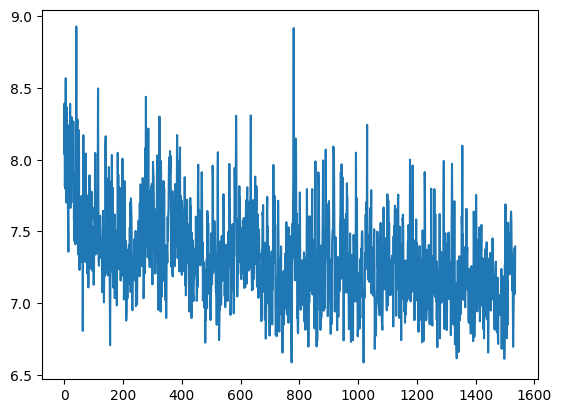

In [12]:
plt.plot(energies)
plt.show()

In [ ]:
print(*energies)

7.551760446899132 7.418465912933124 7.5019691399752535 7.636111771550061 7.7154603388415115 7.811567279322581 7.742969273627918 8.088901781498318 8.052244854595692 8.178066582895411 8.374086877310955 8.550658632201516 8.207799985913757 8.091261624863742 8.613402605232293 8.721853263124883 8.179151371643709 7.711304988871214 8.007761536035567 7.995845200742174 7.511018891758223 7.332502397337702 7.447966213074676 7.5381909620516465 7.518583149723682 7.405482654200391 7.499016940862191 8.015319609916121 7.74778633718181 7.774863787018036 7.816392870572731 7.572900938853179 7.8119907889242075 7.704948456824766 7.686582655690692 8.267454089684898 8.18405958377848 8.640775373834977 7.561330307225921 8.176239818593373 7.788466015499413 8.004362753904324 7.745607533097784 7.99296069358829 7.850867350495199 7.993578477260091 7.802869263309926 7.443942541087531 7.543819030652201 7.993703895226529 8.035528396264082 8.026294984119215 7.0447611387195 7.346569563658356 7.265914623965914 8.241187733